# 应用PINN求解一维欧拉方程（Sod激波管问题）

In [43]:
def train(epoch):
    model.train()
    model.it = epoch
    tocs1 = time.time()
    #print(f'Training time with Adam: {tocs1 - tics1}')
    def closure():
        optimizer.zero_grad()                                                     # Optimizer
        loss_pde = model.loss_pde(x_int_train)                                    # Loss function of PDE
        loss_ic = model.loss_ic(x_ic_train, rho_ic_train,u_ic_train,p_ic_train)   # Loss function of IC
        loss = loss_pde + 10*loss_ic                                          # Total loss function G(theta)
        
        #if (loss < 0.0001):
        #    return
        print(f'epoch {epoch} loss_pde:{loss_pde:.8f}, loss_ic:{loss_ic:.8f}')
        model.it = model.it + 1
        # Print total loss
       # outputfile = open('loss_history_sod.txt','a+')
       # #print(f'epoch {model.it} loss_pde:{loss_pde: .8f},loss_ic:{loss_ic: .8f}',file=outputfile)
       # #print(f'epoch {model.it}: loss {loss:.6f}',file=outputfile)
       # print(f'{model.it}  {loss_pde:.6f}  {loss_ic:.6f}  {loss:.6f}',file=outputfile)
       # outputfile.close()
        #outputfile = open('loss_history_ringV1.txt','a+')
        ## Print iteration, loss of PDE and ICs
        #print(f'epoch {i} loss_pde:{loss_pde: .8f},loss_ic:{loss_ic: .8f}',file=outputfile)
        #print(f'epoch {i}: loss {loss:.6f}',file=outputfile)
        #outputfile.close()
        loss.backward()
        return loss

    # Optimize loss function
    loss = optimizer.step(closure)
    loss_value = loss.item() if not isinstance(loss, float) else loss
    # Print total loss
    print(f'epoch {epoch}: loss {loss_value:.6f}')
 

In [44]:
import torch
import torch.nn as nn
import numpy as np
import time
import scipy.io
# Seeds
torch.manual_seed(12)
np.random.seed(12)

   
# Calculate gradients using torch.autograd.grad
def gradients(outputs, inputs):
    return torch.autograd.grad(outputs, inputs,grad_outputs=torch.ones_like(outputs), create_graph=True)

# Convert torch tensor into np.array
def to_numpy(input):
    if isinstance(input, torch.Tensor):
        return input.detach().cpu().numpy()
    elif isinstance(input, np.ndarray):
        return input
    else:
        raise TypeError('Unknown type of input, expected torch.Tensor or ' \
                        'np.ndarray, but got {}'.format(type(input)))

# Initial conditions
def IC(x):
    N = len(x)
    rho_init = np.zeros((x.shape[0]))                                              # rho - initial condition
    u_init = np.zeros((x.shape[0]))                                                # u - initial condition
    p_init = np.zeros((x.shape[0]))                                                # p - initial condition

    # rho, p - initial condition
    for i in range(N):
        if (x[i] <= 0.5):
            rho_init[i] = 1.0
            p_init[i] = 1.0
        else:
            rho_init[i] = 0.125
            p_init[i] = 0.1

    return rho_init, u_init, p_init

# Generate Neural Network
class DNN(nn.Module):

    def __init__(self):
        super(DNN, self).__init__()
        self.net = nn.Sequential()                                                  # Define neural network
        self.net.add_module('Linear_layer_1', nn.Linear(2, 30))                     # First linear layer
        self.net.add_module('Tanh_layer_1', nn.Tanh())                              # First activation Layer

        for num in range(2, 5):                                                     # Number of layers (2 through 7)
            self.net.add_module('Linear_layer_%d' % (num), nn.Linear(30, 30))       # Linear layer
            self.net.add_module('Tanh_layer_%d' % (num), nn.Tanh())                 # Activation Layer
        self.net.add_module('Linear_layer_final', nn.Linear(30, 3))                 # Output Layer

    # Forward Feed
    def forward(self, x):
        return self.net(x)

    # Loss function for PDE
    def loss_pde(self, x):
        y = self.net(x)                                                # Neural network
        rho,p,u = y[:, 0:1], y[:, 1:2], y[:, 2:]
        
        U2 = rho*u
        U3 = 0.5*rho*u**2 + p/0.4
        
        #F1 = U2
        F2 = rho*u**2+p
        F3 = u*(U3 + p)
        
        gamma = 1.4                                                    # Heat Capacity Ratio

        # Gradients and partial derivatives
        drho_g = gradients(rho, x)[0]                                  # Gradient [rho_t, rho_x]
        rho_t, rho_x = drho_g[:, :1], drho_g[:, 1:]                    # Partial derivatives rho_t, rho_x


        du_g = gradients(u, x)[0]                                      # Gradient [u_t, u_x]
        u_t, u_x = du_g[:, :1], du_g[:, 1:]                            # Partial derivatives u_t, u_x

        dp_g = gradients(p, x)[0]                                      # Gradient [p_t, p_x]
        p_t, p_x = dp_g[:, :1], dp_g[:, 1:]                            # Partial derivatives p_t, p_x
        
        dU2_g = gradients(U2, x)[0]
        U2_t,U2_x = dU2_g[:,:1], dU2_g[:,1:]
        dU3_g = gradients(U3, x)[0]
        U3_t,U3_x = dU3_g[:,:1], dU3_g[:,1:]
        dF2_g = gradients(F2, x)[0]
        F2_t,F2_x = dF2_g[:,:1], dF2_g[:,1:]
        dF3_g = gradients(F3, x)[0]
        F3_t,F3_x = dF3_g[:,:1], dF3_g[:,1:]

        d = 0.1*(abs(u_x)-u_x)  + 1
        d = 0.1*(abs(u_x)-u_x)  + 1
        #d = 1
     
        f = (((rho_t + U2_x)/d)**2).mean() + \
            (((U2_t  + F2_x)/d)**2).mean() + \
            (((U3_t  + F3_x)/d)**2).mean() #+\
           # ((rho_t).mean())**2  +\
           # ((U3_t).mean())**2 
    
        return f

    # Loss function for initial condition
    def loss_ic(self, x_ic, rho_ic, u_ic, p_ic):
        y_ic = self.net(x_ic)                                                      # Initial condition
        rho_ic_nn, p_ic_nn,u_ic_nn = y_ic[:, 0], y_ic[:, 1], y_ic[:, 2]            # rho, u, p - initial condition

        # Loss function for the initial condition
        loss_ics = ((u_ic_nn - u_ic) ** 2).mean() + \
               ((rho_ic_nn- rho_ic) ** 2).mean()  + \
               ((p_ic_nn - p_ic) ** 2).mean()

        return loss_ics
    
device = torch.device('cuda')                                          # Run on CPU
num_x = 100                                                        # Number of points in t
num_t = 200                                                        # Number of points in x
num_i_train = 1000                                                 # Random sampled points from IC0
num_f_train = 10000                                                 # Random sampled points in interior
x = np.linspace(0.0, 1.0, num_x)                                   # Partitioned spatial axis
t = np.linspace(0, 0.2, num_t)                                        # Partitioned time axis
t_grid, x_grid = np.meshgrid(t, x)                                    # (t,x) in [0,0.2]x[a,b]
T = t_grid.flatten()[:, None]                                         # Vectorized t_grid
X = x_grid.flatten()[:, None]                                         # Vectorized x_grid
id_f = np.random.choice(num_x*num_t, num_f_train, replace=False)      # Random sample numbering for interior

x_int = X[:, 0][id_f, None]                                           # Random x - interior
t_int = T[:, 0][id_f, None]                                           # Random t - interior
x_int_train = np.hstack((t_int, x_int))                               # Random (x,t) - vectorized

x = np.linspace(0.0, 1.0, 1000)                                   # Partitioned spatial axis
t = np.linspace(0, 0.2, 100)                                        # Partitioned time axis
t_grid, x_grid = np.meshgrid(t, x)                                    # (t,x) in [0,0.2]x[a,b]
id_ic = np.random.choice(1000, 1000, replace=False)           # Random sample numbering for IC
T = t_grid.flatten()[:, None]                                         # Vectorized t_grid
X = x_grid.flatten()[:, None]                                         # Vectorized x_grid
x_ic = x_grid[id_ic, 0][:, None]                                      # Random x - initial condition
t_ic = t_grid[id_ic, 0][:, None]                                      # random t - initial condition
x_ic_train = np.hstack((t_ic, x_ic))                                  # Random (x,t) - vectorized

rho_ic_train, u_ic_train, p_ic_train = IC(x_ic)                       # Initial condition evaluated at random sample
x_ic_train = torch.tensor(x_ic_train, dtype=torch.float32).to(device)
x_int_train = torch.tensor(x_int_train, requires_grad=True, dtype=torch.float32).to(device)

rho_ic_train = torch.tensor(rho_ic_train, dtype=torch.float32).to(device)
u_ic_train = torch.tensor(u_ic_train, dtype=torch.float32).to(device)
p_ic_train = torch.tensor(p_ic_train, dtype=torch.float32).to(device)

model = DNN().to(device)

print('Start training...')


lr = 0.001                                                           # Learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Start training...


In [19]:
epoch = 0
epochi = epoch

epochs = 8000
tic = time.time()
for epoch in range(1+epochi, epochs+epochi):
    train(epoch)
toc = time.time()
print(f'Total training time: {toc - tic}')

#                                                          'u': u_pred[:,2],
#                                                           'p': u_pred[:,1]})
#


epoch 1 loss_pde:0.00262199, loss_ic:1.29541194
epoch 1: loss 12.956741
epoch 2 loss_pde:0.00199572, loss_ic:1.21595454
epoch 2: loss 12.161542
epoch 3 loss_pde:0.00155079, loss_ic:1.13987565
epoch 3: loss 11.400307
epoch 4 loss_pde:0.00123004, loss_ic:1.06702721
epoch 4: loss 10.671502
epoch 5 loss_pde:0.00102639, loss_ic:0.99720865
epoch 5: loss 9.973113
epoch 6 loss_pde:0.00094434, loss_ic:0.93024635
epoch 6: loss 9.303408
epoch 7 loss_pde:0.00099063, loss_ic:0.86605400
epoch 7: loss 8.661530
epoch 8 loss_pde:0.00117020, loss_ic:0.80465722
epoch 8: loss 8.047742
epoch 9 loss_pde:0.00148372, loss_ic:0.74619746
epoch 9: loss 7.463459
epoch 10 loss_pde:0.00192839, loss_ic:0.69092524
epoch 10: loss 6.911180
epoch 11 loss_pde:0.00249961, loss_ic:0.63918984
epoch 11: loss 6.394398
epoch 12 loss_pde:0.00319190, loss_ic:0.59142506
epoch 12: loss 5.917442
epoch 13 loss_pde:0.00399634, loss_ic:0.54812449
epoch 13: loss 5.485241
epoch 14 loss_pde:0.00489616, loss_ic:0.50980031
epoch 14: loss 5

epoch 123: loss 1.667091
epoch 124 loss_pde:0.34968606, loss_ic:0.13136065
epoch 124: loss 1.663293
epoch 125 loss_pde:0.34691674, loss_ic:0.13124880
epoch 125: loss 1.659405
epoch 126 loss_pde:0.34401545, loss_ic:0.13114081
epoch 126: loss 1.655424
epoch 127 loss_pde:0.34104192, loss_ic:0.13103029
epoch 127: loss 1.651345
epoch 128 loss_pde:0.33804619, loss_ic:0.13091187
epoch 128: loss 1.647165
epoch 129 loss_pde:0.33506534, loss_ic:0.13078161
epoch 129: loss 1.642881
epoch 130 loss_pde:0.33212239, loss_ic:0.13063714
epoch 130: loss 1.638494
epoch 131 loss_pde:0.32922801, loss_ic:0.13047752
epoch 131: loss 1.634003
epoch 132 loss_pde:0.32638296, loss_ic:0.13030282
epoch 132: loss 1.629411
epoch 133 loss_pde:0.32358178, loss_ic:0.13011372
epoch 133: loss 1.624719
epoch 134 loss_pde:0.32081720, loss_ic:0.12991095
epoch 134: loss 1.619927
epoch 135 loss_pde:0.31808370, loss_ic:0.12969500
epoch 135: loss 1.615034
epoch 136 loss_pde:0.31538066, loss_ic:0.12946585
epoch 136: loss 1.610039


epoch 251 loss_pde:0.19561680, loss_ic:0.10070462
epoch 251: loss 1.202663
epoch 252 loss_pde:0.19418858, loss_ic:0.10061193
epoch 252: loss 1.200308
epoch 253 loss_pde:0.19276404, loss_ic:0.10051969
epoch 253: loss 1.197961
epoch 254 loss_pde:0.19134268, loss_ic:0.10042796
epoch 254: loss 1.195622
epoch 255 loss_pde:0.18992426, loss_ic:0.10033675
epoch 255: loss 1.193292
epoch 256 loss_pde:0.18850847, loss_ic:0.10024610
epoch 256: loss 1.190969
epoch 257 loss_pde:0.18709475, loss_ic:0.10015606
epoch 257: loss 1.188655
epoch 258 loss_pde:0.18568289, loss_ic:0.10006666
epoch 258: loss 1.186350
epoch 259 loss_pde:0.18427284, loss_ic:0.09997789
epoch 259: loss 1.184052
epoch 260 loss_pde:0.18286481, loss_ic:0.09988973
epoch 260: loss 1.181762
epoch 261 loss_pde:0.18145855, loss_ic:0.09980217
epoch 261: loss 1.179480
epoch 262 loss_pde:0.18005398, loss_ic:0.09971526
epoch 262: loss 1.177207
epoch 263 loss_pde:0.17865112, loss_ic:0.09962894
epoch 263: loss 1.174940
epoch 264 loss_pde:0.1772

epoch 361: loss 0.961476
epoch 362 loss_pde:0.08288496, loss_ic:0.08767628
epoch 362: loss 0.959648
epoch 363 loss_pde:0.08271417, loss_ic:0.08751269
epoch 363: loss 0.957841
epoch 364 loss_pde:0.08256572, loss_ic:0.08734900
epoch 364: loss 0.956056
epoch 365 loss_pde:0.08243927, loss_ic:0.08718525
epoch 365: loss 0.954292
epoch 366 loss_pde:0.08233407, loss_ic:0.08702151
epoch 366: loss 0.952549
epoch 367 loss_pde:0.08224985, loss_ic:0.08685781
epoch 367: loss 0.950828
epoch 368 loss_pde:0.08218685, loss_ic:0.08669414
epoch 368: loss 0.949128
epoch 369 loss_pde:0.08214474, loss_ic:0.08653049
epoch 369: loss 0.947450
epoch 370 loss_pde:0.08212277, loss_ic:0.08636697
epoch 370: loss 0.945792
epoch 371 loss_pde:0.08212055, loss_ic:0.08620356
epoch 371: loss 0.944156
epoch 372 loss_pde:0.08213800, loss_ic:0.08604028
epoch 372: loss 0.942541
epoch 373 loss_pde:0.08217459, loss_ic:0.08587715
epoch 373: loss 0.940946
epoch 374 loss_pde:0.08222942, loss_ic:0.08571424
epoch 374: loss 0.939372


epoch 474 loss_pde:0.09466113, loss_ic:0.07046150
epoch 474: loss 0.799276
epoch 475 loss_pde:0.09455033, loss_ic:0.07026395
epoch 475: loss 0.797190
epoch 476 loss_pde:0.09443657, loss_ic:0.07006457
epoch 476: loss 0.795082
epoch 477 loss_pde:0.09432012, loss_ic:0.06986341
epoch 477: loss 0.792954
epoch 478 loss_pde:0.09420109, loss_ic:0.06966047
epoch 478: loss 0.790806
epoch 479 loss_pde:0.09407943, loss_ic:0.06945579
epoch 479: loss 0.788637
epoch 480 loss_pde:0.09395552, loss_ic:0.06924938
epoch 480: loss 0.786449
epoch 481 loss_pde:0.09382951, loss_ic:0.06904132
epoch 481: loss 0.784243
epoch 482 loss_pde:0.09370136, loss_ic:0.06883159
epoch 482: loss 0.782017
epoch 483 loss_pde:0.09357134, loss_ic:0.06862026
epoch 483: loss 0.779774
epoch 484 loss_pde:0.09343964, loss_ic:0.06840735
epoch 484: loss 0.777513
epoch 485 loss_pde:0.09330636, loss_ic:0.06819291
epoch 485: loss 0.775235
epoch 486 loss_pde:0.09317140, loss_ic:0.06797706
epoch 486: loss 0.772942
epoch 487 loss_pde:0.0930

epoch 599: loss 0.545443
epoch 600 loss_pde:0.09020701, loss_ic:0.04537387
epoch 600: loss 0.543946
epoch 601 loss_pde:0.09016410, loss_ic:0.04522907
epoch 601: loss 0.542455
epoch 602 loss_pde:0.09012772, loss_ic:0.04508429
epoch 602: loss 0.540971
epoch 603 loss_pde:0.09009235, loss_ic:0.04494010
epoch 603: loss 0.539493
epoch 604 loss_pde:0.09006280, loss_ic:0.04479605
epoch 604: loss 0.538023
epoch 605 loss_pde:0.09003480, loss_ic:0.04465259
epoch 605: loss 0.536561
epoch 606 loss_pde:0.09001252, loss_ic:0.04450931
epoch 606: loss 0.535106
epoch 607 loss_pde:0.08999516, loss_ic:0.04436632
epoch 607: loss 0.533658
epoch 608 loss_pde:0.08998179, loss_ic:0.04422376
epoch 608: loss 0.532219
epoch 609 loss_pde:0.08997545, loss_ic:0.04408130
epoch 609: loss 0.530788
epoch 610 loss_pde:0.08996698, loss_ic:0.04393991
epoch 610: loss 0.529366
epoch 611 loss_pde:0.08996950, loss_ic:0.04379828
epoch 611: loss 0.527952
epoch 612 loss_pde:0.08996765, loss_ic:0.04365798
epoch 612: loss 0.526547


epoch 719 loss_pde:0.08622478, loss_ic:0.03373814
epoch 719: loss 0.423606
epoch 720 loss_pde:0.08604825, loss_ic:0.03367997
epoch 720: loss 0.422848
epoch 721 loss_pde:0.08587287, loss_ic:0.03362179
epoch 721: loss 0.422091
epoch 722 loss_pde:0.08569454, loss_ic:0.03356405
epoch 722: loss 0.421335
epoch 723 loss_pde:0.08551565, loss_ic:0.03350651
epoch 723: loss 0.420581
epoch 724 loss_pde:0.08533507, loss_ic:0.03344928
epoch 724: loss 0.419828
epoch 725 loss_pde:0.08515111, loss_ic:0.03339254
epoch 725: loss 0.419077
epoch 726 loss_pde:0.08496840, loss_ic:0.03333580
epoch 726: loss 0.418326
epoch 727 loss_pde:0.08478203, loss_ic:0.03327957
epoch 727: loss 0.417578
epoch 728 loss_pde:0.08459706, loss_ic:0.03322332
epoch 728: loss 0.416830
epoch 729 loss_pde:0.08440679, loss_ic:0.03316776
epoch 729: loss 0.416084
epoch 730 loss_pde:0.08422016, loss_ic:0.03311196
epoch 730: loss 0.415340
epoch 731 loss_pde:0.08403239, loss_ic:0.03305644
epoch 731: loss 0.414597
epoch 732 loss_pde:0.0838

epoch 838 loss_pde:0.06805834, loss_ic:0.02791180
epoch 838: loss 0.347176
epoch 839 loss_pde:0.06796661, loss_ic:0.02786287
epoch 839: loss 0.346595
epoch 840 loss_pde:0.06781475, loss_ic:0.02781969
epoch 840: loss 0.346012
epoch 841 loss_pde:0.06772220, loss_ic:0.02777026
epoch 841: loss 0.345425
epoch 842 loss_pde:0.06756882, loss_ic:0.02772668
epoch 842: loss 0.344836
epoch 843 loss_pde:0.06747183, loss_ic:0.02767731
epoch 843: loss 0.344245
epoch 844 loss_pde:0.06733011, loss_ic:0.02763231
epoch 844: loss 0.343653
epoch 845 loss_pde:0.06722220, loss_ic:0.02758389
epoch 845: loss 0.343061
epoch 846 loss_pde:0.06708828, loss_ic:0.02753803
epoch 846: loss 0.342469
epoch 847 loss_pde:0.06696728, loss_ic:0.02749083
epoch 847: loss 0.341876
epoch 848 loss_pde:0.06684580, loss_ic:0.02744362
epoch 848: loss 0.341282
epoch 849 loss_pde:0.06671809, loss_ic:0.02739696
epoch 849: loss 0.340688
epoch 850 loss_pde:0.06660305, loss_ic:0.02734891
epoch 850: loss 0.340092
epoch 851 loss_pde:0.0664

epoch 949: loss 0.291196
epoch 950 loss_pde:0.05487239, loss_ic:0.02313646
epoch 950: loss 0.286237
epoch 951 loss_pde:0.05573650, loss_ic:0.02311184
epoch 951: loss 0.286855
epoch 952 loss_pde:0.05960855, loss_ic:0.02307644
epoch 952: loss 0.290373
epoch 953 loss_pde:0.06074489, loss_ic:0.02305999
epoch 953: loss 0.291345
epoch 954 loss_pde:0.05799009, loss_ic:0.02299542
epoch 954: loss 0.287944
epoch 955 loss_pde:0.05457363, loss_ic:0.02295879
epoch 955: loss 0.284162
epoch 956 loss_pde:0.05475862, loss_ic:0.02292535
epoch 956: loss 0.284012
epoch 957 loss_pde:0.05724511, loss_ic:0.02288809
epoch 957: loss 0.286126
epoch 958 loss_pde:0.05778547, loss_ic:0.02286885
epoch 958: loss 0.286474
epoch 959 loss_pde:0.05585752, loss_ic:0.02281712
epoch 959: loss 0.284029
epoch 960 loss_pde:0.05389025, loss_ic:0.02278559
epoch 960: loss 0.281746
epoch 961 loss_pde:0.05431093, loss_ic:0.02275616
epoch 961: loss 0.281873
epoch 962 loss_pde:0.05582336, loss_ic:0.02272039
epoch 962: loss 0.283027


epoch 1058 loss_pde:0.04642871, loss_ic:0.01994780
epoch 1058: loss 0.245907
epoch 1059 loss_pde:0.04649676, loss_ic:0.01991248
epoch 1059: loss 0.245622
epoch 1060 loss_pde:0.04619598, loss_ic:0.01989599
epoch 1060: loss 0.245156
epoch 1061 loss_pde:0.04602433, loss_ic:0.01986152
epoch 1061: loss 0.244640
epoch 1062 loss_pde:0.04582790, loss_ic:0.01983841
epoch 1062: loss 0.244212
epoch 1063 loss_pde:0.04577813, loss_ic:0.01981415
epoch 1063: loss 0.243920
epoch 1064 loss_pde:0.04586018, loss_ic:0.01978470
epoch 1064: loss 0.243707
epoch 1065 loss_pde:0.04581414, loss_ic:0.01976657
epoch 1065: loss 0.243480
epoch 1066 loss_pde:0.04585396, loss_ic:0.01973224
epoch 1066: loss 0.243176
epoch 1067 loss_pde:0.04565855, loss_ic:0.01971370
epoch 1067: loss 0.242796
epoch 1068 loss_pde:0.04557211, loss_ic:0.01968102
epoch 1068: loss 0.242382
epoch 1069 loss_pde:0.04539707, loss_ic:0.01965922
epoch 1069: loss 0.241989
epoch 1070 loss_pde:0.04531869, loss_ic:0.01963277
epoch 1070: loss 0.241646

epoch 1166: loss 0.214670
epoch 1167 loss_pde:0.04039172, loss_ic:0.01740536
epoch 1167: loss 0.214445
epoch 1168 loss_pde:0.04046198, loss_ic:0.01737673
epoch 1168: loss 0.214229
epoch 1169 loss_pde:0.04039123, loss_ic:0.01736346
epoch 1169: loss 0.214026
epoch 1170 loss_pde:0.04051386, loss_ic:0.01733282
epoch 1170: loss 0.213842
epoch 1171 loss_pde:0.04046005, loss_ic:0.01732277
epoch 1171: loss 0.213688
epoch 1172 loss_pde:0.04068649, loss_ic:0.01728937
epoch 1172: loss 0.213580
epoch 1173 loss_pde:0.04070329, loss_ic:0.01728404
epoch 1173: loss 0.213544
epoch 1174 loss_pde:0.04116632, loss_ic:0.01724545
epoch 1174: loss 0.213621
epoch 1175 loss_pde:0.04139416, loss_ic:0.01724753
epoch 1175: loss 0.213869
epoch 1176 loss_pde:0.04237467, loss_ic:0.01720107
epoch 1176: loss 0.214385
epoch 1177 loss_pde:0.04310813, loss_ic:0.01721643
epoch 1177: loss 0.215272
epoch 1178 loss_pde:0.04508170, loss_ic:0.01715910
epoch 1178: loss 0.216673
epoch 1179 loss_pde:0.04665702, loss_ic:0.01719292

epoch 1279: loss 0.191516
epoch 1280 loss_pde:0.03873899, loss_ic:0.01533348
epoch 1280: loss 0.192074
epoch 1281 loss_pde:0.04020789, loss_ic:0.01534392
epoch 1281: loss 0.193647
epoch 1282 loss_pde:0.04131265, loss_ic:0.01530181
epoch 1282: loss 0.194331
epoch 1283 loss_pde:0.04020887, loss_ic:0.01531267
epoch 1283: loss 0.193336
epoch 1284 loss_pde:0.03886766, loss_ic:0.01527043
epoch 1284: loss 0.191572
epoch 1285 loss_pde:0.03788482, loss_ic:0.01526209
epoch 1285: loss 0.190506
epoch 1286 loss_pde:0.03819858, loss_ic:0.01525154
epoch 1286: loss 0.190714
epoch 1287 loss_pde:0.03927701, loss_ic:0.01522320
epoch 1287: loss 0.191509
epoch 1288 loss_pde:0.03951446, loss_ic:0.01522991
epoch 1288: loss 0.191813
epoch 1289 loss_pde:0.03928415, loss_ic:0.01519270
epoch 1289: loss 0.191211
epoch 1290 loss_pde:0.03827226, loss_ic:0.01519063
epoch 1290: loss 0.190179
epoch 1291 loss_pde:0.03784452, loss_ic:0.01516626
epoch 1291: loss 0.189507
epoch 1292 loss_pde:0.03804184, loss_ic:0.01514730

epoch 1391 loss_pde:0.03697254, loss_ic:0.01369691
epoch 1391: loss 0.173942
epoch 1392 loss_pde:0.03784893, loss_ic:0.01369379
epoch 1392: loss 0.174787
epoch 1393 loss_pde:0.03901432, loss_ic:0.01366704
epoch 1393: loss 0.175685
epoch 1394 loss_pde:0.03876351, loss_ic:0.01367228
epoch 1394: loss 0.175486
epoch 1395 loss_pde:0.03791772, loss_ic:0.01364220
epoch 1395: loss 0.174340
epoch 1396 loss_pde:0.03693766, loss_ic:0.01363537
epoch 1396: loss 0.173291
epoch 1397 loss_pde:0.03690489, loss_ic:0.01362053
epoch 1397: loss 0.173110
epoch 1398 loss_pde:0.03759199, loss_ic:0.01359956
epoch 1398: loss 0.173588
epoch 1399 loss_pde:0.03796390, loss_ic:0.01359741
epoch 1399: loss 0.173938
epoch 1400 loss_pde:0.03796133, loss_ic:0.01356969
epoch 1400: loss 0.173658
epoch 1401 loss_pde:0.03727522, loss_ic:0.01356568
epoch 1401: loss 0.172932
epoch 1402 loss_pde:0.03687974, loss_ic:0.01354541
epoch 1402: loss 0.172334
epoch 1403 loss_pde:0.03690005, loss_ic:0.01353097
epoch 1403: loss 0.172210

epoch 1503 loss_pde:0.03512641, loss_ic:0.01226268
epoch 1503: loss 0.157753
epoch 1504 loss_pde:0.03589148, loss_ic:0.01224780
epoch 1504: loss 0.158370
epoch 1505 loss_pde:0.03788850, loss_ic:0.01225435
epoch 1505: loss 0.160432
epoch 1506 loss_pde:0.03855054, loss_ic:0.01222363
epoch 1506: loss 0.160787
epoch 1507 loss_pde:0.03664843, loss_ic:0.01222613
epoch 1507: loss 0.158910
epoch 1508 loss_pde:0.03507591, loss_ic:0.01220386
epoch 1508: loss 0.157114
epoch 1509 loss_pde:0.03527329, loss_ic:0.01219261
epoch 1509: loss 0.157199
epoch 1510 loss_pde:0.03645603, loss_ic:0.01219222
epoch 1510: loss 0.158378
epoch 1511 loss_pde:0.03706555, loss_ic:0.01216622
epoch 1511: loss 0.158728
epoch 1512 loss_pde:0.03604586, loss_ic:0.01216354
epoch 1512: loss 0.157681
epoch 1513 loss_pde:0.03505934, loss_ic:0.01214063
epoch 1513: loss 0.156466
epoch 1514 loss_pde:0.03499363, loss_ic:0.01212889
epoch 1514: loss 0.156283
epoch 1515 loss_pde:0.03564286, loss_ic:0.01212522
epoch 1515: loss 0.156895

epoch 1618: loss 0.145228
epoch 1619 loss_pde:0.03697979, loss_ic:0.01098488
epoch 1619: loss 0.146829
epoch 1620 loss_pde:0.04002356, loss_ic:0.01095786
epoch 1620: loss 0.149602
epoch 1621 loss_pde:0.04417469, loss_ic:0.01098473
epoch 1621: loss 0.154022
epoch 1622 loss_pde:0.05086853, loss_ic:0.01094971
epoch 1622: loss 0.160366
epoch 1623 loss_pde:0.05732297, loss_ic:0.01099868
epoch 1623: loss 0.167310
epoch 1624 loss_pde:0.06200314, loss_ic:0.01094606
epoch 1624: loss 0.171464
epoch 1625 loss_pde:0.05761850, loss_ic:0.01099016
epoch 1625: loss 0.167520
epoch 1626 loss_pde:0.04660057, loss_ic:0.01092065
epoch 1626: loss 0.155807
epoch 1627 loss_pde:0.03512790, loss_ic:0.01092888
epoch 1627: loss 0.144417
epoch 1628 loss_pde:0.03313815, loss_ic:0.01091579
epoch 1628: loss 0.142296
epoch 1629 loss_pde:0.03962102, loss_ic:0.01089970
epoch 1629: loss 0.148618
epoch 1630 loss_pde:0.04532866, loss_ic:0.01092441
epoch 1630: loss 0.154573
epoch 1631 loss_pde:0.04430375, loss_ic:0.01087539

epoch 1730: loss 0.132031
epoch 1731 loss_pde:0.03162921, loss_ic:0.01003180
epoch 1731: loss 0.131947
epoch 1732 loss_pde:0.03161624, loss_ic:0.01002475
epoch 1732: loss 0.131864
epoch 1733 loss_pde:0.03160796, loss_ic:0.01001725
epoch 1733: loss 0.131781
epoch 1734 loss_pde:0.03160635, loss_ic:0.01000911
epoch 1734: loss 0.131697
epoch 1735 loss_pde:0.03160306, loss_ic:0.01000117
epoch 1735: loss 0.131615
epoch 1736 loss_pde:0.03159699, loss_ic:0.00999353
epoch 1736: loss 0.131532
epoch 1737 loss_pde:0.03158240, loss_ic:0.00998675
epoch 1737: loss 0.131450
epoch 1738 loss_pde:0.03156900, loss_ic:0.00997987
epoch 1738: loss 0.131368
epoch 1739 loss_pde:0.03155528, loss_ic:0.00997304
epoch 1739: loss 0.131286
epoch 1740 loss_pde:0.03154907, loss_ic:0.00996548
epoch 1740: loss 0.131204
epoch 1741 loss_pde:0.03154362, loss_ic:0.00995786
epoch 1741: loss 0.131122
epoch 1742 loss_pde:0.03154036, loss_ic:0.00995005
epoch 1742: loss 0.131041
epoch 1743 loss_pde:0.03153161, loss_ic:0.00994281

epoch 1843: loss 0.124124
epoch 1844 loss_pde:0.03082916, loss_ic:0.00932698
epoch 1844: loss 0.124099
epoch 1845 loss_pde:0.03080690, loss_ic:0.00932276
epoch 1845: loss 0.124035
epoch 1846 loss_pde:0.03077970, loss_ic:0.00931595
epoch 1846: loss 0.123939
epoch 1847 loss_pde:0.03073899, loss_ic:0.00931126
epoch 1847: loss 0.123852
epoch 1848 loss_pde:0.03073464, loss_ic:0.00930604
epoch 1848: loss 0.123795
epoch 1849 loss_pde:0.03075885, loss_ic:0.00929991
epoch 1849: loss 0.123758
epoch 1850 loss_pde:0.03075882, loss_ic:0.00929528
epoch 1850: loss 0.123712
epoch 1851 loss_pde:0.03075928, loss_ic:0.00928837
epoch 1851: loss 0.123643
epoch 1852 loss_pde:0.03072807, loss_ic:0.00928350
epoch 1852: loss 0.123563
epoch 1853 loss_pde:0.03071428, loss_ic:0.00927778
epoch 1853: loss 0.123492
epoch 1854 loss_pde:0.03071222, loss_ic:0.00927256
epoch 1854: loss 0.123438
epoch 1855 loss_pde:0.03070959, loss_ic:0.00926816
epoch 1855: loss 0.123391
epoch 1856 loss_pde:0.03071650, loss_ic:0.00926214

epoch 1955 loss_pde:0.03014929, loss_ic:0.00877361
epoch 1955: loss 0.117885
epoch 1956 loss_pde:0.03014174, loss_ic:0.00876924
epoch 1956: loss 0.117834
epoch 1957 loss_pde:0.03013779, loss_ic:0.00876454
epoch 1957: loss 0.117783
epoch 1958 loss_pde:0.03013011, loss_ic:0.00876025
epoch 1958: loss 0.117733
epoch 1959 loss_pde:0.03012800, loss_ic:0.00875547
epoch 1959: loss 0.117683
epoch 1960 loss_pde:0.03012061, loss_ic:0.00875131
epoch 1960: loss 0.117634
epoch 1961 loss_pde:0.03012239, loss_ic:0.00874639
epoch 1961: loss 0.117586
epoch 1962 loss_pde:0.03011696, loss_ic:0.00874245
epoch 1962: loss 0.117541
epoch 1963 loss_pde:0.03012782, loss_ic:0.00873731
epoch 1963: loss 0.117501
epoch 1964 loss_pde:0.03013027, loss_ic:0.00873372
epoch 1964: loss 0.117467
epoch 1965 loss_pde:0.03016429, loss_ic:0.00872819
epoch 1965: loss 0.117446
epoch 1966 loss_pde:0.03019375, loss_ic:0.00872522
epoch 1966: loss 0.117446
epoch 1967 loss_pde:0.03029138, loss_ic:0.00871906
epoch 1967: loss 0.117482

epoch 2066 loss_pde:0.02937929, loss_ic:0.00833553
epoch 2066: loss 0.112735
epoch 2067 loss_pde:0.02937404, loss_ic:0.00833164
epoch 2067: loss 0.112690
epoch 2068 loss_pde:0.02937101, loss_ic:0.00832762
epoch 2068: loss 0.112647
epoch 2069 loss_pde:0.02936387, loss_ic:0.00832396
epoch 2069: loss 0.112603
epoch 2070 loss_pde:0.02935912, loss_ic:0.00831994
epoch 2070: loss 0.112559
epoch 2071 loss_pde:0.02935005, loss_ic:0.00831629
epoch 2071: loss 0.112513
epoch 2072 loss_pde:0.02934391, loss_ic:0.00831236
epoch 2072: loss 0.112467
epoch 2073 loss_pde:0.02933746, loss_ic:0.00830854
epoch 2073: loss 0.112423
epoch 2074 loss_pde:0.02933120, loss_ic:0.00830477
epoch 2074: loss 0.112379
epoch 2075 loss_pde:0.02932666, loss_ic:0.00830084
epoch 2075: loss 0.112335
epoch 2076 loss_pde:0.02931930, loss_ic:0.00829716
epoch 2076: loss 0.112291
epoch 2077 loss_pde:0.02931432, loss_ic:0.00829319
epoch 2077: loss 0.112246
epoch 2078 loss_pde:0.02930661, loss_ic:0.00828947
epoch 2078: loss 0.112201

epoch 2176: loss 0.108510
epoch 2177 loss_pde:0.02966506, loss_ic:0.00792530
epoch 2177: loss 0.108918
epoch 2178 loss_pde:0.03042597, loss_ic:0.00792694
epoch 2178: loss 0.109695
epoch 2179 loss_pde:0.03194790, loss_ic:0.00792009
epoch 2179: loss 0.111149
epoch 2180 loss_pde:0.03449731, loss_ic:0.00792797
epoch 2180: loss 0.113777
epoch 2181 loss_pde:0.03918386, loss_ic:0.00792086
epoch 2181: loss 0.118392
epoch 2182 loss_pde:0.04640324, loss_ic:0.00794170
epoch 2182: loss 0.125820
epoch 2183 loss_pde:0.05701245, loss_ic:0.00793447
epoch 2183: loss 0.136357
epoch 2184 loss_pde:0.06719941, loss_ic:0.00797299
epoch 2184: loss 0.146929
epoch 2185 loss_pde:0.07119438, loss_ic:0.00794813
epoch 2185: loss 0.150676
epoch 2186 loss_pde:0.05984474, loss_ic:0.00797199
epoch 2186: loss 0.139565
epoch 2187 loss_pde:0.04036675, loss_ic:0.00792189
epoch 2187: loss 0.119586
epoch 2188 loss_pde:0.02856964, loss_ic:0.00792099
epoch 2188: loss 0.107780
epoch 2189 loss_pde:0.03371694, loss_ic:0.00792898

epoch 2290 loss_pde:0.02789039, loss_ic:0.00757588
epoch 2290: loss 0.103649
epoch 2291 loss_pde:0.02788386, loss_ic:0.00757280
epoch 2291: loss 0.103612
epoch 2292 loss_pde:0.02787875, loss_ic:0.00756954
epoch 2292: loss 0.103574
epoch 2293 loss_pde:0.02787275, loss_ic:0.00756639
epoch 2293: loss 0.103537
epoch 2294 loss_pde:0.02786741, loss_ic:0.00756319
epoch 2294: loss 0.103499
epoch 2295 loss_pde:0.02786238, loss_ic:0.00755998
epoch 2295: loss 0.103462
epoch 2296 loss_pde:0.02785634, loss_ic:0.00755688
epoch 2296: loss 0.103425
epoch 2297 loss_pde:0.02785117, loss_ic:0.00755367
epoch 2297: loss 0.103388
epoch 2298 loss_pde:0.02784481, loss_ic:0.00755057
epoch 2298: loss 0.103351
epoch 2299 loss_pde:0.02783952, loss_ic:0.00754736
epoch 2299: loss 0.103313
epoch 2300 loss_pde:0.02783387, loss_ic:0.00754420
epoch 2300: loss 0.103276
epoch 2301 loss_pde:0.02782832, loss_ic:0.00754104
epoch 2301: loss 0.103239
epoch 2302 loss_pde:0.02782317, loss_ic:0.00753785
epoch 2302: loss 0.103202

epoch 2403: loss 0.099506
epoch 2404 loss_pde:0.02721477, loss_ic:0.00722558
epoch 2404: loss 0.099471
epoch 2405 loss_pde:0.02721178, loss_ic:0.00722229
epoch 2405: loss 0.099435
epoch 2406 loss_pde:0.02720817, loss_ic:0.00721908
epoch 2406: loss 0.099399
epoch 2407 loss_pde:0.02720434, loss_ic:0.00721594
epoch 2407: loss 0.099364
epoch 2408 loss_pde:0.02719647, loss_ic:0.00721325
epoch 2408: loss 0.099329
epoch 2409 loss_pde:0.02719242, loss_ic:0.00721031
epoch 2409: loss 0.099295
epoch 2410 loss_pde:0.02718802, loss_ic:0.00720762
epoch 2410: loss 0.099264
epoch 2411 loss_pde:0.02719506, loss_ic:0.00720421
epoch 2411: loss 0.099237
epoch 2412 loss_pde:0.02720270, loss_ic:0.00720156
epoch 2412: loss 0.099218
epoch 2413 loss_pde:0.02723550, loss_ic:0.00719798
epoch 2413: loss 0.099215
epoch 2414 loss_pde:0.02728328, loss_ic:0.00719602
epoch 2414: loss 0.099244
epoch 2415 loss_pde:0.02741182, loss_ic:0.00719214
epoch 2415: loss 0.099333
epoch 2416 loss_pde:0.02763366, loss_ic:0.00719113

epoch 2514 loss_pde:0.02654251, loss_ic:0.00694611
epoch 2514: loss 0.096004
epoch 2515 loss_pde:0.02653822, loss_ic:0.00694349
epoch 2515: loss 0.095973
epoch 2516 loss_pde:0.02653335, loss_ic:0.00694108
epoch 2516: loss 0.095944
epoch 2517 loss_pde:0.02653009, loss_ic:0.00693825
epoch 2517: loss 0.095913
epoch 2518 loss_pde:0.02652215, loss_ic:0.00693566
epoch 2518: loss 0.095879
epoch 2519 loss_pde:0.02651703, loss_ic:0.00693294
epoch 2519: loss 0.095846
epoch 2520 loss_pde:0.02651384, loss_ic:0.00693026
epoch 2520: loss 0.095816
epoch 2521 loss_pde:0.02650853, loss_ic:0.00692776
epoch 2521: loss 0.095786
epoch 2522 loss_pde:0.02650454, loss_ic:0.00692493
epoch 2522: loss 0.095754
epoch 2523 loss_pde:0.02649779, loss_ic:0.00692233
epoch 2523: loss 0.095721
epoch 2524 loss_pde:0.02649311, loss_ic:0.00691966
epoch 2524: loss 0.095690
epoch 2525 loss_pde:0.02649034, loss_ic:0.00691690
epoch 2525: loss 0.095659
epoch 2526 loss_pde:0.02648514, loss_ic:0.00691432
epoch 2526: loss 0.095628

epoch 2623 loss_pde:0.02600989, loss_ic:0.00666032
epoch 2623: loss 0.092613
epoch 2624 loss_pde:0.02600460, loss_ic:0.00665777
epoch 2624: loss 0.092582
epoch 2625 loss_pde:0.02599932, loss_ic:0.00665521
epoch 2625: loss 0.092551
epoch 2626 loss_pde:0.02599403, loss_ic:0.00665266
epoch 2626: loss 0.092521
epoch 2627 loss_pde:0.02598872, loss_ic:0.00665011
epoch 2627: loss 0.092490
epoch 2628 loss_pde:0.02598343, loss_ic:0.00664755
epoch 2628: loss 0.092459
epoch 2629 loss_pde:0.02597812, loss_ic:0.00664500
epoch 2629: loss 0.092428
epoch 2630 loss_pde:0.02597280, loss_ic:0.00664245
epoch 2630: loss 0.092397
epoch 2631 loss_pde:0.02596749, loss_ic:0.00663991
epoch 2631: loss 0.092367
epoch 2632 loss_pde:0.02596219, loss_ic:0.00663736
epoch 2632: loss 0.092336
epoch 2633 loss_pde:0.02595686, loss_ic:0.00663481
epoch 2633: loss 0.092305
epoch 2634 loss_pde:0.02595151, loss_ic:0.00663227
epoch 2634: loss 0.092274
epoch 2635 loss_pde:0.02594615, loss_ic:0.00662972
epoch 2635: loss 0.092243

epoch 2743: loss 0.092654
epoch 2744 loss_pde:0.03233579, loss_ic:0.00641323
epoch 2744: loss 0.096468
epoch 2745 loss_pde:0.02799268, loss_ic:0.00640718
epoch 2745: loss 0.092065
epoch 2746 loss_pde:0.02522429, loss_ic:0.00639511
epoch 2746: loss 0.089175
epoch 2747 loss_pde:0.02873896, loss_ic:0.00639137
epoch 2747: loss 0.092653
epoch 2748 loss_pde:0.02952373, loss_ic:0.00640091
epoch 2748: loss 0.093533
epoch 2749 loss_pde:0.02607066, loss_ic:0.00638396
epoch 2749: loss 0.089910
epoch 2750 loss_pde:0.02568164, loss_ic:0.00638199
epoch 2750: loss 0.089502
epoch 2751 loss_pde:0.02813529, loss_ic:0.00638997
epoch 2751: loss 0.092035
epoch 2752 loss_pde:0.02751299, loss_ic:0.00638271
epoch 2752: loss 0.091340
epoch 2753 loss_pde:0.02524117, loss_ic:0.00637830
epoch 2753: loss 0.089024
epoch 2754 loss_pde:0.02601440, loss_ic:0.00637550
epoch 2754: loss 0.089769
epoch 2755 loss_pde:0.02740737, loss_ic:0.00637196
epoch 2755: loss 0.091127
epoch 2756 loss_pde:0.02616449, loss_ic:0.00637293

epoch 2866: loss 0.085869
epoch 2867 loss_pde:0.02471359, loss_ic:0.00611294
epoch 2867: loss 0.085843
epoch 2868 loss_pde:0.02470957, loss_ic:0.00611070
epoch 2868: loss 0.085817
epoch 2869 loss_pde:0.02470520, loss_ic:0.00610851
epoch 2869: loss 0.085790
epoch 2870 loss_pde:0.02470112, loss_ic:0.00610628
epoch 2870: loss 0.085764
epoch 2871 loss_pde:0.02469672, loss_ic:0.00610408
epoch 2871: loss 0.085738
epoch 2872 loss_pde:0.02469241, loss_ic:0.00610187
epoch 2872: loss 0.085711
epoch 2873 loss_pde:0.02468819, loss_ic:0.00609966
epoch 2873: loss 0.085685
epoch 2874 loss_pde:0.02468379, loss_ic:0.00609747
epoch 2874: loss 0.085658
epoch 2875 loss_pde:0.02467975, loss_ic:0.00609524
epoch 2875: loss 0.085632
epoch 2876 loss_pde:0.02467540, loss_ic:0.00609304
epoch 2876: loss 0.085606
epoch 2877 loss_pde:0.02467109, loss_ic:0.00609084
epoch 2877: loss 0.085579
epoch 2878 loss_pde:0.02466679, loss_ic:0.00608863
epoch 2878: loss 0.085553
epoch 2879 loss_pde:0.02466242, loss_ic:0.00608644

epoch 2975: loss 0.083025
epoch 2976 loss_pde:0.02422868, loss_ic:0.00587704
epoch 2976: loss 0.082999
epoch 2977 loss_pde:0.02422427, loss_ic:0.00587490
epoch 2977: loss 0.082973
epoch 2978 loss_pde:0.02422035, loss_ic:0.00587271
epoch 2978: loss 0.082947
epoch 2979 loss_pde:0.02421602, loss_ic:0.00587057
epoch 2979: loss 0.082922
epoch 2980 loss_pde:0.02421091, loss_ic:0.00586850
epoch 2980: loss 0.082896
epoch 2981 loss_pde:0.02420574, loss_ic:0.00586645
epoch 2981: loss 0.082870
epoch 2982 loss_pde:0.02420111, loss_ic:0.00586434
epoch 2982: loss 0.082844
epoch 2983 loss_pde:0.02419696, loss_ic:0.00586218
epoch 2983: loss 0.082819
epoch 2984 loss_pde:0.02419267, loss_ic:0.00586003
epoch 2984: loss 0.082793
epoch 2985 loss_pde:0.02418794, loss_ic:0.00585794
epoch 2985: loss 0.082767
epoch 2986 loss_pde:0.02418296, loss_ic:0.00585586
epoch 2986: loss 0.082742
epoch 2987 loss_pde:0.02417827, loss_ic:0.00585376
epoch 2987: loss 0.082716
epoch 2988 loss_pde:0.02417388, loss_ic:0.00585163

epoch 3086 loss_pde:0.02412507, loss_ic:0.00567625
epoch 3086: loss 0.080888
epoch 3087 loss_pde:0.02361883, loss_ic:0.00567835
epoch 3087: loss 0.080402
epoch 3088 loss_pde:0.02388071, loss_ic:0.00567850
epoch 3088: loss 0.080666
epoch 3089 loss_pde:0.02426742, loss_ic:0.00567115
epoch 3089: loss 0.080979
epoch 3090 loss_pde:0.02398005, loss_ic:0.00567159
epoch 3090: loss 0.080696
epoch 3091 loss_pde:0.02364425, loss_ic:0.00566783
epoch 3091: loss 0.080323
epoch 3092 loss_pde:0.02375717, loss_ic:0.00566682
epoch 3092: loss 0.080425
epoch 3093 loss_pde:0.02396942, loss_ic:0.00566894
epoch 3093: loss 0.080659
epoch 3094 loss_pde:0.02390065, loss_ic:0.00566250
epoch 3094: loss 0.080526
epoch 3095 loss_pde:0.02363747, loss_ic:0.00566096
epoch 3095: loss 0.080247
epoch 3096 loss_pde:0.02366708, loss_ic:0.00565820
epoch 3096: loss 0.080249
epoch 3097 loss_pde:0.02386526, loss_ic:0.00565445
epoch 3097: loss 0.080410
epoch 3098 loss_pde:0.02381285, loss_ic:0.00565555
epoch 3098: loss 0.080368

epoch 3207: loss 0.077726
epoch 3208 loss_pde:0.02329406, loss_ic:0.00544099
epoch 3208: loss 0.077704
epoch 3209 loss_pde:0.02329103, loss_ic:0.00543911
epoch 3209: loss 0.077682
epoch 3210 loss_pde:0.02328785, loss_ic:0.00543726
epoch 3210: loss 0.077660
epoch 3211 loss_pde:0.02328480, loss_ic:0.00543539
epoch 3211: loss 0.077639
epoch 3212 loss_pde:0.02328153, loss_ic:0.00543354
epoch 3212: loss 0.077617
epoch 3213 loss_pde:0.02327836, loss_ic:0.00543168
epoch 3213: loss 0.077595
epoch 3214 loss_pde:0.02327522, loss_ic:0.00542983
epoch 3214: loss 0.077573
epoch 3215 loss_pde:0.02327205, loss_ic:0.00542797
epoch 3215: loss 0.077552
epoch 3216 loss_pde:0.02326895, loss_ic:0.00542611
epoch 3216: loss 0.077530
epoch 3217 loss_pde:0.02326571, loss_ic:0.00542426
epoch 3217: loss 0.077508
epoch 3218 loss_pde:0.02326265, loss_ic:0.00542240
epoch 3218: loss 0.077487
epoch 3219 loss_pde:0.02325946, loss_ic:0.00542055
epoch 3219: loss 0.077465
epoch 3220 loss_pde:0.02325631, loss_ic:0.00541870

epoch 3317: loss 0.075376
epoch 3318 loss_pde:0.02294602, loss_ic:0.00524093
epoch 3318: loss 0.075355
epoch 3319 loss_pde:0.02294360, loss_ic:0.00523908
epoch 3319: loss 0.075334
epoch 3320 loss_pde:0.02293961, loss_ic:0.00523740
epoch 3320: loss 0.075314
epoch 3321 loss_pde:0.02293782, loss_ic:0.00523550
epoch 3321: loss 0.075293
epoch 3322 loss_pde:0.02293351, loss_ic:0.00523388
epoch 3322: loss 0.075272
epoch 3323 loss_pde:0.02293303, loss_ic:0.00523190
epoch 3323: loss 0.075252
epoch 3324 loss_pde:0.02292827, loss_ic:0.00523039
epoch 3324: loss 0.075232
epoch 3325 loss_pde:0.02293072, loss_ic:0.00522826
epoch 3325: loss 0.075213
epoch 3326 loss_pde:0.02292638, loss_ic:0.00522698
epoch 3326: loss 0.075196
epoch 3327 loss_pde:0.02293666, loss_ic:0.00522455
epoch 3327: loss 0.075182
epoch 3328 loss_pde:0.02293727, loss_ic:0.00522368
epoch 3328: loss 0.075174
epoch 3329 loss_pde:0.02297007, loss_ic:0.00522072
epoch 3329: loss 0.075177
epoch 3330 loss_pde:0.02299536, loss_ic:0.00522067

epoch 3429: loss 0.073348
epoch 3430 loss_pde:0.02259180, loss_ic:0.00507412
epoch 3430: loss 0.073333
epoch 3431 loss_pde:0.02258359, loss_ic:0.00507309
epoch 3431: loss 0.073314
epoch 3432 loss_pde:0.02258080, loss_ic:0.00507117
epoch 3432: loss 0.073292
epoch 3433 loss_pde:0.02257685, loss_ic:0.00506957
epoch 3433: loss 0.073273
epoch 3434 loss_pde:0.02257540, loss_ic:0.00506808
epoch 3434: loss 0.073256
epoch 3435 loss_pde:0.02257772, loss_ic:0.00506618
epoch 3435: loss 0.073239
epoch 3436 loss_pde:0.02257094, loss_ic:0.00506489
epoch 3436: loss 0.073220
epoch 3437 loss_pde:0.02256862, loss_ic:0.00506308
epoch 3437: loss 0.073199
epoch 3438 loss_pde:0.02256675, loss_ic:0.00506143
epoch 3438: loss 0.073181
epoch 3439 loss_pde:0.02256500, loss_ic:0.00505992
epoch 3439: loss 0.073164
epoch 3440 loss_pde:0.02256626, loss_ic:0.00505800
epoch 3440: loss 0.073146
epoch 3441 loss_pde:0.02255947, loss_ic:0.00505673
epoch 3441: loss 0.073127
epoch 3442 loss_pde:0.02255645, loss_ic:0.00505510

epoch 3538: loss 0.071373
epoch 3539 loss_pde:0.02234704, loss_ic:0.00490079
epoch 3539: loss 0.071355
epoch 3540 loss_pde:0.02234471, loss_ic:0.00489924
epoch 3540: loss 0.071337
epoch 3541 loss_pde:0.02234234, loss_ic:0.00489769
epoch 3541: loss 0.071319
epoch 3542 loss_pde:0.02233996, loss_ic:0.00489615
epoch 3542: loss 0.071301
epoch 3543 loss_pde:0.02233755, loss_ic:0.00489460
epoch 3543: loss 0.071284
epoch 3544 loss_pde:0.02233524, loss_ic:0.00489305
epoch 3544: loss 0.071266
epoch 3545 loss_pde:0.02233289, loss_ic:0.00489150
epoch 3545: loss 0.071248
epoch 3546 loss_pde:0.02233054, loss_ic:0.00488996
epoch 3546: loss 0.071230
epoch 3547 loss_pde:0.02232813, loss_ic:0.00488842
epoch 3547: loss 0.071212
epoch 3548 loss_pde:0.02232573, loss_ic:0.00488687
epoch 3548: loss 0.071194
epoch 3549 loss_pde:0.02232333, loss_ic:0.00488534
epoch 3549: loss 0.071177
epoch 3550 loss_pde:0.02232094, loss_ic:0.00488379
epoch 3550: loss 0.071159
epoch 3551 loss_pde:0.02232366, loss_ic:0.00488174

epoch 3662 loss_pde:0.02193959, loss_ic:0.00474515
epoch 3662: loss 0.069391
epoch 3663 loss_pde:0.03062067, loss_ic:0.00476934
epoch 3663: loss 0.078314
epoch 3664 loss_pde:0.04038691, loss_ic:0.00475222
epoch 3664: loss 0.087909
epoch 3665 loss_pde:0.03390234, loss_ic:0.00476817
epoch 3665: loss 0.081584
epoch 3666 loss_pde:0.02315507, loss_ic:0.00474082
epoch 3666: loss 0.070563
epoch 3667 loss_pde:0.02423203, loss_ic:0.00474002
epoch 3667: loss 0.071632
epoch 3668 loss_pde:0.03196834, loss_ic:0.00475588
epoch 3668: loss 0.079527
epoch 3669 loss_pde:0.03198535, loss_ic:0.00472460
epoch 3669: loss 0.079231
epoch 3670 loss_pde:0.02430598, loss_ic:0.00472954
epoch 3670: loss 0.071601
epoch 3671 loss_pde:0.02229945, loss_ic:0.00473055
epoch 3671: loss 0.069605
epoch 3672 loss_pde:0.02728859, loss_ic:0.00473089
epoch 3672: loss 0.074598
epoch 3673 loss_pde:0.02881265, loss_ic:0.00474248
epoch 3673: loss 0.076237
epoch 3674 loss_pde:0.02455575, loss_ic:0.00472112
epoch 3674: loss 0.071767

epoch 3771: loss 0.067534
epoch 3772 loss_pde:0.02177965, loss_ic:0.00457388
epoch 3772: loss 0.067518
epoch 3773 loss_pde:0.02177755, loss_ic:0.00457252
epoch 3773: loss 0.067503
epoch 3774 loss_pde:0.02177626, loss_ic:0.00457107
epoch 3774: loss 0.067487
epoch 3775 loss_pde:0.02177294, loss_ic:0.00456982
epoch 3775: loss 0.067471
epoch 3776 loss_pde:0.02177174, loss_ic:0.00456834
epoch 3776: loss 0.067455
epoch 3777 loss_pde:0.02176974, loss_ic:0.00456695
epoch 3777: loss 0.067439
epoch 3778 loss_pde:0.02176761, loss_ic:0.00456558
epoch 3778: loss 0.067423
epoch 3779 loss_pde:0.02176592, loss_ic:0.00456417
epoch 3779: loss 0.067408
epoch 3780 loss_pde:0.02176317, loss_ic:0.00456287
epoch 3780: loss 0.067392
epoch 3781 loss_pde:0.02176205, loss_ic:0.00456139
epoch 3781: loss 0.067376
epoch 3782 loss_pde:0.02175971, loss_ic:0.00456003
epoch 3782: loss 0.067360
epoch 3783 loss_pde:0.02175766, loss_ic:0.00455865
epoch 3783: loss 0.067344
epoch 3784 loss_pde:0.02175592, loss_ic:0.00455725

epoch 3894 loss_pde:0.02150810, loss_ic:0.00440892
epoch 3894: loss 0.065597
epoch 3895 loss_pde:0.02150564, loss_ic:0.00440760
epoch 3895: loss 0.065582
epoch 3896 loss_pde:0.02150316, loss_ic:0.00440628
epoch 3896: loss 0.065566
epoch 3897 loss_pde:0.02150074, loss_ic:0.00440496
epoch 3897: loss 0.065550
epoch 3898 loss_pde:0.02149823, loss_ic:0.00440364
epoch 3898: loss 0.065535
epoch 3899 loss_pde:0.02149578, loss_ic:0.00440233
epoch 3899: loss 0.065519
epoch 3900 loss_pde:0.02149327, loss_ic:0.00440101
epoch 3900: loss 0.065503
epoch 3901 loss_pde:0.02149083, loss_ic:0.00439969
epoch 3901: loss 0.065488
epoch 3902 loss_pde:0.02148829, loss_ic:0.00439838
epoch 3902: loss 0.065472
epoch 3903 loss_pde:0.02148586, loss_ic:0.00439706
epoch 3903: loss 0.065456
epoch 3904 loss_pde:0.02148330, loss_ic:0.00439575
epoch 3904: loss 0.065441
epoch 3905 loss_pde:0.02148088, loss_ic:0.00439442
epoch 3905: loss 0.065425
epoch 3906 loss_pde:0.02147827, loss_ic:0.00439312
epoch 3906: loss 0.065409

epoch 4002: loss 0.064099
epoch 4003 loss_pde:0.02117337, loss_ic:0.00428596
epoch 4003: loss 0.064033
epoch 4004 loss_pde:0.02120538, loss_ic:0.00428480
epoch 4004: loss 0.064053
epoch 4005 loss_pde:0.02127501, loss_ic:0.00428181
epoch 4005: loss 0.064093
epoch 4006 loss_pde:0.02124904, loss_ic:0.00428260
epoch 4006: loss 0.064075
epoch 4007 loss_pde:0.02120767, loss_ic:0.00428011
epoch 4007: loss 0.064009
epoch 4008 loss_pde:0.02116379, loss_ic:0.00427973
epoch 4008: loss 0.063961
epoch 4009 loss_pde:0.02117575, loss_ic:0.00427883
epoch 4009: loss 0.063964
epoch 4010 loss_pde:0.02122007, loss_ic:0.00427627
epoch 4010: loss 0.063983
epoch 4011 loss_pde:0.02120513, loss_ic:0.00427656
epoch 4011: loss 0.063971
epoch 4012 loss_pde:0.02118717, loss_ic:0.00427404
epoch 4012: loss 0.063928
epoch 4013 loss_pde:0.02115580, loss_ic:0.00427342
epoch 4013: loss 0.063890
epoch 4014 loss_pde:0.02115869, loss_ic:0.00427226
epoch 4014: loss 0.063881
epoch 4015 loss_pde:0.02118479, loss_ic:0.00427020

epoch 4109: loss 0.062512
epoch 4110 loss_pde:0.02094765, loss_ic:0.00415498
epoch 4110: loss 0.062497
epoch 4111 loss_pde:0.02094631, loss_ic:0.00415368
epoch 4111: loss 0.062483
epoch 4112 loss_pde:0.02094410, loss_ic:0.00415247
epoch 4112: loss 0.062469
epoch 4113 loss_pde:0.02094119, loss_ic:0.00415133
epoch 4113: loss 0.062455
epoch 4114 loss_pde:0.02093859, loss_ic:0.00415016
epoch 4114: loss 0.062440
epoch 4115 loss_pde:0.02093646, loss_ic:0.00414894
epoch 4115: loss 0.062426
epoch 4116 loss_pde:0.02093427, loss_ic:0.00414773
epoch 4116: loss 0.062412
epoch 4117 loss_pde:0.02093187, loss_ic:0.00414654
epoch 4117: loss 0.062397
epoch 4118 loss_pde:0.02092965, loss_ic:0.00414533
epoch 4118: loss 0.062383
epoch 4119 loss_pde:0.02092713, loss_ic:0.00414415
epoch 4119: loss 0.062369
epoch 4120 loss_pde:0.02092459, loss_ic:0.00414298
epoch 4120: loss 0.062354
epoch 4121 loss_pde:0.02092203, loss_ic:0.00414180
epoch 4121: loss 0.062340
epoch 4122 loss_pde:0.02091995, loss_ic:0.00414057

epoch 4222: loss 0.067290
epoch 4223 loss_pde:0.02419168, loss_ic:0.00406160
epoch 4223: loss 0.064808
epoch 4224 loss_pde:0.02084780, loss_ic:0.00404527
epoch 4224: loss 0.061301
epoch 4225 loss_pde:0.02148603, loss_ic:0.00404092
epoch 4225: loss 0.061895
epoch 4226 loss_pde:0.02395061, loss_ic:0.00405280
epoch 4226: loss 0.064479
epoch 4227 loss_pde:0.02390815, loss_ic:0.00404105
epoch 4227: loss 0.064319
epoch 4228 loss_pde:0.02134478, loss_ic:0.00404785
epoch 4228: loss 0.061823
epoch 4229 loss_pde:0.02057599, loss_ic:0.00404303
epoch 4229: loss 0.061006
epoch 4230 loss_pde:0.02216088, loss_ic:0.00403745
epoch 4230: loss 0.062535
epoch 4231 loss_pde:0.02291727, loss_ic:0.00404240
epoch 4231: loss 0.063341
epoch 4232 loss_pde:0.02176920, loss_ic:0.00403202
epoch 4232: loss 0.062089
epoch 4233 loss_pde:0.02055254, loss_ic:0.00403368
epoch 4233: loss 0.060889
epoch 4234 loss_pde:0.02104635, loss_ic:0.00403557
epoch 4234: loss 0.061402
epoch 4235 loss_pde:0.02205352, loss_ic:0.00402883

epoch 4333 loss_pde:0.02034904, loss_ic:0.00391916
epoch 4333: loss 0.059541
epoch 4334 loss_pde:0.02034723, loss_ic:0.00391803
epoch 4334: loss 0.059528
epoch 4335 loss_pde:0.02034453, loss_ic:0.00391699
epoch 4335: loss 0.059514
epoch 4336 loss_pde:0.02034220, loss_ic:0.00391592
epoch 4336: loss 0.059501
epoch 4337 loss_pde:0.02034010, loss_ic:0.00391482
epoch 4337: loss 0.059488
epoch 4338 loss_pde:0.02033758, loss_ic:0.00391377
epoch 4338: loss 0.059475
epoch 4339 loss_pde:0.02033576, loss_ic:0.00391264
epoch 4339: loss 0.059462
epoch 4340 loss_pde:0.02033311, loss_ic:0.00391160
epoch 4340: loss 0.059449
epoch 4341 loss_pde:0.02033115, loss_ic:0.00391049
epoch 4341: loss 0.059436
epoch 4342 loss_pde:0.02032872, loss_ic:0.00390942
epoch 4342: loss 0.059423
epoch 4343 loss_pde:0.02032633, loss_ic:0.00390835
epoch 4343: loss 0.059410
epoch 4344 loss_pde:0.02032421, loss_ic:0.00390726
epoch 4344: loss 0.059397
epoch 4345 loss_pde:0.02032169, loss_ic:0.00390620
epoch 4345: loss 0.059384

epoch 4443: loss 0.058101
epoch 4444 loss_pde:0.02007407, loss_ic:0.00380140
epoch 4444: loss 0.058088
epoch 4445 loss_pde:0.02007135, loss_ic:0.00380036
epoch 4445: loss 0.058075
epoch 4446 loss_pde:0.02006878, loss_ic:0.00379931
epoch 4446: loss 0.058062
epoch 4447 loss_pde:0.02006598, loss_ic:0.00379828
epoch 4447: loss 0.058049
epoch 4448 loss_pde:0.02006345, loss_ic:0.00379722
epoch 4448: loss 0.058036
epoch 4449 loss_pde:0.02006063, loss_ic:0.00379619
epoch 4449: loss 0.058023
epoch 4450 loss_pde:0.02005813, loss_ic:0.00379513
epoch 4450: loss 0.058009
epoch 4451 loss_pde:0.02005525, loss_ic:0.00379411
epoch 4451: loss 0.057996
epoch 4452 loss_pde:0.02005284, loss_ic:0.00379304
epoch 4452: loss 0.057983
epoch 4453 loss_pde:0.02004985, loss_ic:0.00379203
epoch 4453: loss 0.057970
epoch 4454 loss_pde:0.02004755, loss_ic:0.00379095
epoch 4454: loss 0.057957
epoch 4455 loss_pde:0.02004441, loss_ic:0.00378995
epoch 4455: loss 0.057944
epoch 4456 loss_pde:0.02004239, loss_ic:0.00378885

epoch 4557 loss_pde:0.01973622, loss_ic:0.00370351
epoch 4557: loss 0.056771
epoch 4558 loss_pde:0.01974963, loss_ic:0.00370154
epoch 4558: loss 0.056765
epoch 4559 loss_pde:0.01973266, loss_ic:0.00370122
epoch 4559: loss 0.056745
epoch 4560 loss_pde:0.01972480, loss_ic:0.00369976
epoch 4560: loss 0.056722
epoch 4561 loss_pde:0.01972147, loss_ic:0.00369882
epoch 4561: loss 0.056710
epoch 4562 loss_pde:0.01972175, loss_ic:0.00369830
epoch 4562: loss 0.056705
epoch 4563 loss_pde:0.01972900, loss_ic:0.00369674
epoch 4563: loss 0.056696
epoch 4564 loss_pde:0.01971692, loss_ic:0.00369631
epoch 4564: loss 0.056680
epoch 4565 loss_pde:0.01971260, loss_ic:0.00369490
epoch 4565: loss 0.056662
epoch 4566 loss_pde:0.01970821, loss_ic:0.00369402
epoch 4566: loss 0.056648
epoch 4567 loss_pde:0.01970727, loss_ic:0.00369330
epoch 4567: loss 0.056640
epoch 4568 loss_pde:0.01971330, loss_ic:0.00369177
epoch 4568: loss 0.056631
epoch 4569 loss_pde:0.01970433, loss_ic:0.00369127
epoch 4569: loss 0.056617

epoch 4669 loss_pde:0.01946259, loss_ic:0.00359380
epoch 4669: loss 0.055401
epoch 4670 loss_pde:0.01946000, loss_ic:0.00359285
epoch 4670: loss 0.055388
epoch 4671 loss_pde:0.01945745, loss_ic:0.00359189
epoch 4671: loss 0.055376
epoch 4672 loss_pde:0.01945490, loss_ic:0.00359093
epoch 4672: loss 0.055364
epoch 4673 loss_pde:0.01945234, loss_ic:0.00358997
epoch 4673: loss 0.055352
epoch 4674 loss_pde:0.01944974, loss_ic:0.00358901
epoch 4674: loss 0.055340
epoch 4675 loss_pde:0.01944715, loss_ic:0.00358805
epoch 4675: loss 0.055328
epoch 4676 loss_pde:0.01944462, loss_ic:0.00358709
epoch 4676: loss 0.055315
epoch 4677 loss_pde:0.01944201, loss_ic:0.00358613
epoch 4677: loss 0.055303
epoch 4678 loss_pde:0.01943943, loss_ic:0.00358517
epoch 4678: loss 0.055291
epoch 4679 loss_pde:0.01943682, loss_ic:0.00358422
epoch 4679: loss 0.055279
epoch 4680 loss_pde:0.01943427, loss_ic:0.00358326
epoch 4680: loss 0.055267
epoch 4681 loss_pde:0.01943167, loss_ic:0.00358230
epoch 4681: loss 0.055255

epoch 4779 loss_pde:0.02187331, loss_ic:0.00350353
epoch 4779: loss 0.056909
epoch 4780 loss_pde:0.02414831, loss_ic:0.00352506
epoch 4780: loss 0.059399
epoch 4781 loss_pde:0.02269766, loss_ic:0.00353796
epoch 4781: loss 0.058077
epoch 4782 loss_pde:0.01972551, loss_ic:0.00350551
epoch 4782: loss 0.054781
epoch 4783 loss_pde:0.01967562, loss_ic:0.00348752
epoch 4783: loss 0.054551
epoch 4784 loss_pde:0.02172221, loss_ic:0.00349383
epoch 4784: loss 0.056660
epoch 4785 loss_pde:0.02217276, loss_ic:0.00351604
epoch 4785: loss 0.057333
epoch 4786 loss_pde:0.02048152, loss_ic:0.00353226
epoch 4786: loss 0.055804
epoch 4787 loss_pde:0.01917033, loss_ic:0.00349603
epoch 4787: loss 0.054131
epoch 4788 loss_pde:0.01999057, loss_ic:0.00347984
epoch 4788: loss 0.054789
epoch 4789 loss_pde:0.02121778, loss_ic:0.00348430
epoch 4789: loss 0.056061
epoch 4790 loss_pde:0.02075935, loss_ic:0.00350557
epoch 4790: loss 0.055815
epoch 4791 loss_pde:0.01944060, loss_ic:0.00352542
epoch 4791: loss 0.054695

epoch 4889: loss 0.052851
epoch 4890 loss_pde:0.01892182, loss_ic:0.00339176
epoch 4890: loss 0.052839
epoch 4891 loss_pde:0.01892160, loss_ic:0.00339060
epoch 4891: loss 0.052828
epoch 4892 loss_pde:0.01892428, loss_ic:0.00338914
epoch 4892: loss 0.052816
epoch 4893 loss_pde:0.01891982, loss_ic:0.00338840
epoch 4893: loss 0.052804
epoch 4894 loss_pde:0.01891252, loss_ic:0.00338794
epoch 4894: loss 0.052792
epoch 4895 loss_pde:0.01890869, loss_ic:0.00338713
epoch 4895: loss 0.052780
epoch 4896 loss_pde:0.01890934, loss_ic:0.00338587
epoch 4896: loss 0.052768
epoch 4897 loss_pde:0.01890743, loss_ic:0.00338488
epoch 4897: loss 0.052756
epoch 4898 loss_pde:0.01890105, loss_ic:0.00338433
epoch 4898: loss 0.052744
epoch 4899 loss_pde:0.01889643, loss_ic:0.00338361
epoch 4899: loss 0.052733
epoch 4900 loss_pde:0.01889547, loss_ic:0.00338252
epoch 4900: loss 0.052721
epoch 4901 loss_pde:0.01889489, loss_ic:0.00338139
epoch 4901: loss 0.052709
epoch 4902 loss_pde:0.01888999, loss_ic:0.00338068

epoch 5001: loss 0.051522
epoch 5002 loss_pde:0.01856851, loss_ic:0.00329418
epoch 5002: loss 0.051510
epoch 5003 loss_pde:0.01856432, loss_ic:0.00329352
epoch 5003: loss 0.051500
epoch 5004 loss_pde:0.01856515, loss_ic:0.00329244
epoch 5004: loss 0.051490
epoch 5005 loss_pde:0.01856171, loss_ic:0.00329189
epoch 5005: loss 0.051481
epoch 5006 loss_pde:0.01856716, loss_ic:0.00329066
epoch 5006: loss 0.051474
epoch 5007 loss_pde:0.01856708, loss_ic:0.00329032
epoch 5007: loss 0.051470
epoch 5008 loss_pde:0.01858408, loss_ic:0.00328884
epoch 5008: loss 0.051473
epoch 5009 loss_pde:0.01859622, loss_ic:0.00328884
epoch 5009: loss 0.051485
epoch 5010 loss_pde:0.01864428, loss_ic:0.00328697
epoch 5010: loss 0.051514
epoch 5011 loss_pde:0.01869716, loss_ic:0.00328758
epoch 5011: loss 0.051573
epoch 5012 loss_pde:0.01883431, loss_ic:0.00328504
epoch 5012: loss 0.051685
epoch 5013 loss_pde:0.01902033, loss_ic:0.00328680
epoch 5013: loss 0.051888
epoch 5014 loss_pde:0.01942486, loss_ic:0.00328317

epoch 5115: loss 0.050313
epoch 5116 loss_pde:0.01815334, loss_ic:0.00321468
epoch 5116: loss 0.050300
epoch 5117 loss_pde:0.01814793, loss_ic:0.00321400
epoch 5117: loss 0.050288
epoch 5118 loss_pde:0.01814465, loss_ic:0.00321326
epoch 5118: loss 0.050277
epoch 5119 loss_pde:0.01814397, loss_ic:0.00321234
epoch 5119: loss 0.050267
epoch 5120 loss_pde:0.01814049, loss_ic:0.00321165
epoch 5120: loss 0.050257
epoch 5121 loss_pde:0.01813882, loss_ic:0.00321066
epoch 5121: loss 0.050245
epoch 5122 loss_pde:0.01813359, loss_ic:0.00320997
epoch 5122: loss 0.050233
epoch 5123 loss_pde:0.01813017, loss_ic:0.00320916
epoch 5123: loss 0.050222
epoch 5124 loss_pde:0.01812751, loss_ic:0.00320835
epoch 5124: loss 0.050211
epoch 5125 loss_pde:0.01812440, loss_ic:0.00320763
epoch 5125: loss 0.050201
epoch 5126 loss_pde:0.01812301, loss_ic:0.00320669
epoch 5126: loss 0.050190
epoch 5127 loss_pde:0.01811877, loss_ic:0.00320598
epoch 5127: loss 0.050179
epoch 5128 loss_pde:0.01811631, loss_ic:0.00320507

epoch 5224 loss_pde:0.01781307, loss_ic:0.00312935
epoch 5224: loss 0.049107
epoch 5225 loss_pde:0.01780967, loss_ic:0.00312858
epoch 5225: loss 0.049095
epoch 5226 loss_pde:0.01780681, loss_ic:0.00312775
epoch 5226: loss 0.049084
epoch 5227 loss_pde:0.01780382, loss_ic:0.00312694
epoch 5227: loss 0.049073
epoch 5228 loss_pde:0.01780040, loss_ic:0.00312618
epoch 5228: loss 0.049062
epoch 5229 loss_pde:0.01779692, loss_ic:0.00312541
epoch 5229: loss 0.049051
epoch 5230 loss_pde:0.01779369, loss_ic:0.00312463
epoch 5230: loss 0.049040
epoch 5231 loss_pde:0.01779050, loss_ic:0.00312384
epoch 5231: loss 0.049029
epoch 5232 loss_pde:0.01778730, loss_ic:0.00312305
epoch 5232: loss 0.049018
epoch 5233 loss_pde:0.01778415, loss_ic:0.00312225
epoch 5233: loss 0.049007
epoch 5234 loss_pde:0.01778087, loss_ic:0.00312147
epoch 5234: loss 0.048996
epoch 5235 loss_pde:0.01777740, loss_ic:0.00312071
epoch 5235: loss 0.048984
epoch 5236 loss_pde:0.01777416, loss_ic:0.00311992
epoch 5236: loss 0.048973

epoch 5335: loss 0.048853
epoch 5336 loss_pde:0.01883812, loss_ic:0.00305106
epoch 5336: loss 0.049349
epoch 5337 loss_pde:0.01793057, loss_ic:0.00305358
epoch 5337: loss 0.048466
epoch 5338 loss_pde:0.01736734, loss_ic:0.00305986
epoch 5338: loss 0.047966
epoch 5339 loss_pde:0.01800959, loss_ic:0.00305384
epoch 5339: loss 0.048548
epoch 5340 loss_pde:0.01834106, loss_ic:0.00304823
epoch 5340: loss 0.048823
epoch 5341 loss_pde:0.01771326, loss_ic:0.00304679
epoch 5341: loss 0.048181
epoch 5342 loss_pde:0.01739103, loss_ic:0.00305257
epoch 5342: loss 0.047917
epoch 5343 loss_pde:0.01781069, loss_ic:0.00305068
epoch 5343: loss 0.048318
epoch 5344 loss_pde:0.01797662, loss_ic:0.00304766
epoch 5344: loss 0.048453
epoch 5345 loss_pde:0.01753704, loss_ic:0.00304860
epoch 5345: loss 0.048023
epoch 5346 loss_pde:0.01740565, loss_ic:0.00304469
epoch 5346: loss 0.047853
epoch 5347 loss_pde:0.01772762, loss_ic:0.00304104
epoch 5347: loss 0.048138
epoch 5348 loss_pde:0.01774398, loss_ic:0.00304481

epoch 5447 loss_pde:0.01710731, loss_ic:0.00296521
epoch 5447: loss 0.046759
epoch 5448 loss_pde:0.01710446, loss_ic:0.00296445
epoch 5448: loss 0.046749
epoch 5449 loss_pde:0.01710183, loss_ic:0.00296366
epoch 5449: loss 0.046738
epoch 5450 loss_pde:0.01709897, loss_ic:0.00296289
epoch 5450: loss 0.046728
epoch 5451 loss_pde:0.01709579, loss_ic:0.00296216
epoch 5451: loss 0.046717
epoch 5452 loss_pde:0.01709299, loss_ic:0.00296139
epoch 5452: loss 0.046707
epoch 5453 loss_pde:0.01709023, loss_ic:0.00296061
epoch 5453: loss 0.046696
epoch 5454 loss_pde:0.01708725, loss_ic:0.00295986
epoch 5454: loss 0.046686
epoch 5455 loss_pde:0.01708431, loss_ic:0.00295910
epoch 5455: loss 0.046675
epoch 5456 loss_pde:0.01708148, loss_ic:0.00295833
epoch 5456: loss 0.046665
epoch 5457 loss_pde:0.01707861, loss_ic:0.00295757
epoch 5457: loss 0.046654
epoch 5458 loss_pde:0.01707562, loss_ic:0.00295681
epoch 5458: loss 0.046644
epoch 5459 loss_pde:0.01707282, loss_ic:0.00295604
epoch 5459: loss 0.046633

epoch 5566: loss 0.045506
epoch 5567 loss_pde:0.01674702, loss_ic:0.00287480
epoch 5567: loss 0.045495
epoch 5568 loss_pde:0.01674392, loss_ic:0.00287405
epoch 5568: loss 0.045484
epoch 5569 loss_pde:0.01674083, loss_ic:0.00287330
epoch 5569: loss 0.045474
epoch 5570 loss_pde:0.01673776, loss_ic:0.00287255
epoch 5570: loss 0.045463
epoch 5571 loss_pde:0.01673469, loss_ic:0.00287181
epoch 5571: loss 0.045453
epoch 5572 loss_pde:0.01673159, loss_ic:0.00287106
epoch 5572: loss 0.045442
epoch 5573 loss_pde:0.01672851, loss_ic:0.00287031
epoch 5573: loss 0.045432
epoch 5574 loss_pde:0.01672539, loss_ic:0.00286956
epoch 5574: loss 0.045421
epoch 5575 loss_pde:0.01672232, loss_ic:0.00286882
epoch 5575: loss 0.045410
epoch 5576 loss_pde:0.01671925, loss_ic:0.00286807
epoch 5576: loss 0.045400
epoch 5577 loss_pde:0.01671614, loss_ic:0.00286732
epoch 5577: loss 0.045389
epoch 5578 loss_pde:0.01671302, loss_ic:0.00286658
epoch 5578: loss 0.045379
epoch 5579 loss_pde:0.01670994, loss_ic:0.00286583

epoch 5683: loss 0.045536
epoch 5684 loss_pde:0.01745378, loss_ic:0.00280251
epoch 5684: loss 0.045479
epoch 5685 loss_pde:0.01670131, loss_ic:0.00280161
epoch 5685: loss 0.044717
epoch 5686 loss_pde:0.01634816, loss_ic:0.00279939
epoch 5686: loss 0.044342
epoch 5687 loss_pde:0.01672120, loss_ic:0.00279858
epoch 5687: loss 0.044707
epoch 5688 loss_pde:0.01709792, loss_ic:0.00279944
epoch 5688: loss 0.045092
epoch 5689 loss_pde:0.01692677, loss_ic:0.00279684
epoch 5689: loss 0.044895
epoch 5690 loss_pde:0.01647039, loss_ic:0.00279559
epoch 5690: loss 0.044426
epoch 5691 loss_pde:0.01635947, loss_ic:0.00279512
epoch 5691: loss 0.044311
epoch 5692 loss_pde:0.01662815, loss_ic:0.00279517
epoch 5692: loss 0.044580
epoch 5693 loss_pde:0.01679062, loss_ic:0.00279590
epoch 5693: loss 0.044750
epoch 5694 loss_pde:0.01662117, loss_ic:0.00279438
epoch 5694: loss 0.044565
epoch 5695 loss_pde:0.01636301, loss_ic:0.00279307
epoch 5695: loss 0.044294
epoch 5696 loss_pde:0.01634800, loss_ic:0.00279215

epoch 5802: loss 0.043207
epoch 5803 loss_pde:0.01604188, loss_ic:0.00271557
epoch 5803: loss 0.043198
epoch 5804 loss_pde:0.01603923, loss_ic:0.00271487
epoch 5804: loss 0.043188
epoch 5805 loss_pde:0.01603659, loss_ic:0.00271416
epoch 5805: loss 0.043178
epoch 5806 loss_pde:0.01603397, loss_ic:0.00271345
epoch 5806: loss 0.043168
epoch 5807 loss_pde:0.01603135, loss_ic:0.00271274
epoch 5807: loss 0.043159
epoch 5808 loss_pde:0.01602870, loss_ic:0.00271204
epoch 5808: loss 0.043149
epoch 5809 loss_pde:0.01602609, loss_ic:0.00271133
epoch 5809: loss 0.043139
epoch 5810 loss_pde:0.01602342, loss_ic:0.00271063
epoch 5810: loss 0.043130
epoch 5811 loss_pde:0.01602080, loss_ic:0.00270991
epoch 5811: loss 0.043120
epoch 5812 loss_pde:0.01601821, loss_ic:0.00270920
epoch 5812: loss 0.043110
epoch 5813 loss_pde:0.01601557, loss_ic:0.00270850
epoch 5813: loss 0.043101
epoch 5814 loss_pde:0.01601291, loss_ic:0.00270779
epoch 5814: loss 0.043091
epoch 5815 loss_pde:0.01601026, loss_ic:0.00270709

epoch 5920 loss_pde:0.02542570, loss_ic:0.00266443
epoch 5920: loss 0.052070
epoch 5921 loss_pde:0.01567364, loss_ic:0.00266088
epoch 5921: loss 0.042282
epoch 5922 loss_pde:0.02214144, loss_ic:0.00267302
epoch 5922: loss 0.048872
epoch 5923 loss_pde:0.03174063, loss_ic:0.00267531
epoch 5923: loss 0.058494
epoch 5924 loss_pde:0.02925414, loss_ic:0.00267111
epoch 5924: loss 0.055965
epoch 5925 loss_pde:0.01924631, loss_ic:0.00265107
epoch 5925: loss 0.045757
epoch 5926 loss_pde:0.01595563, loss_ic:0.00264729
epoch 5926: loss 0.042429
epoch 5927 loss_pde:0.02187591, loss_ic:0.00265244
epoch 5927: loss 0.048400
epoch 5928 loss_pde:0.02600569, loss_ic:0.00265423
epoch 5928: loss 0.052548
epoch 5929 loss_pde:0.02190751, loss_ic:0.00264734
epoch 5929: loss 0.048381
epoch 5930 loss_pde:0.01622421, loss_ic:0.00264710
epoch 5930: loss 0.042695
epoch 5931 loss_pde:0.01680890, loss_ic:0.00265014
epoch 5931: loss 0.043310
epoch 5932 loss_pde:0.02099230, loss_ic:0.00265187
epoch 5932: loss 0.047511

epoch 6038: loss 0.041085
epoch 6039 loss_pde:0.01542381, loss_ic:0.00256519
epoch 6039: loss 0.041076
epoch 6040 loss_pde:0.01542175, loss_ic:0.00256451
epoch 6040: loss 0.041067
epoch 6041 loss_pde:0.01541939, loss_ic:0.00256386
epoch 6041: loss 0.041058
epoch 6042 loss_pde:0.01541707, loss_ic:0.00256319
epoch 6042: loss 0.041049
epoch 6043 loss_pde:0.01541474, loss_ic:0.00256253
epoch 6043: loss 0.041040
epoch 6044 loss_pde:0.01541253, loss_ic:0.00256185
epoch 6044: loss 0.041031
epoch 6045 loss_pde:0.01541038, loss_ic:0.00256117
epoch 6045: loss 0.041022
epoch 6046 loss_pde:0.01540804, loss_ic:0.00256052
epoch 6046: loss 0.041013
epoch 6047 loss_pde:0.01540573, loss_ic:0.00255986
epoch 6047: loss 0.041004
epoch 6048 loss_pde:0.01540359, loss_ic:0.00255918
epoch 6048: loss 0.040995
epoch 6049 loss_pde:0.01540144, loss_ic:0.00255850
epoch 6049: loss 0.040986
epoch 6050 loss_pde:0.01539913, loss_ic:0.00255783
epoch 6050: loss 0.040977
epoch 6051 loss_pde:0.01539687, loss_ic:0.00255716

epoch 6157: loss 0.040018
epoch 6158 loss_pde:0.01514809, loss_ic:0.00248610
epoch 6158: loss 0.040009
epoch 6159 loss_pde:0.01514572, loss_ic:0.00248543
epoch 6159: loss 0.040000
epoch 6160 loss_pde:0.01514335, loss_ic:0.00248477
epoch 6160: loss 0.039991
epoch 6161 loss_pde:0.01514107, loss_ic:0.00248410
epoch 6161: loss 0.039982
epoch 6162 loss_pde:0.01513873, loss_ic:0.00248344
epoch 6162: loss 0.039973
epoch 6163 loss_pde:0.01513640, loss_ic:0.00248278
epoch 6163: loss 0.039964
epoch 6164 loss_pde:0.01513407, loss_ic:0.00248212
epoch 6164: loss 0.039955
epoch 6165 loss_pde:0.01513193, loss_ic:0.00248145
epoch 6165: loss 0.039946
epoch 6166 loss_pde:0.01512982, loss_ic:0.00248079
epoch 6166: loss 0.039938
epoch 6167 loss_pde:0.01512797, loss_ic:0.00248013
epoch 6167: loss 0.039929
epoch 6168 loss_pde:0.01512631, loss_ic:0.00247948
epoch 6168: loss 0.039921
epoch 6169 loss_pde:0.01512543, loss_ic:0.00247880
epoch 6169: loss 0.039913
epoch 6170 loss_pde:0.01512527, loss_ic:0.00247816

epoch 6275 loss_pde:0.01486192, loss_ic:0.00242418
epoch 6275: loss 0.039104
epoch 6276 loss_pde:0.01485794, loss_ic:0.00242339
epoch 6276: loss 0.039092
epoch 6277 loss_pde:0.01485131, loss_ic:0.00242293
epoch 6277: loss 0.039081
epoch 6278 loss_pde:0.01484804, loss_ic:0.00242248
epoch 6278: loss 0.039073
epoch 6279 loss_pde:0.01484957, loss_ic:0.00242174
epoch 6279: loss 0.039067
epoch 6280 loss_pde:0.01484923, loss_ic:0.00242105
epoch 6280: loss 0.039060
epoch 6281 loss_pde:0.01484627, loss_ic:0.00242037
epoch 6281: loss 0.039050
epoch 6282 loss_pde:0.01484286, loss_ic:0.00241967
epoch 6282: loss 0.039040
epoch 6283 loss_pde:0.01483954, loss_ic:0.00241912
epoch 6283: loss 0.039031
epoch 6284 loss_pde:0.01483841, loss_ic:0.00241853
epoch 6284: loss 0.039024
epoch 6285 loss_pde:0.01483813, loss_ic:0.00241784
epoch 6285: loss 0.039017
epoch 6286 loss_pde:0.01483502, loss_ic:0.00241730
epoch 6286: loss 0.039008
epoch 6287 loss_pde:0.01483094, loss_ic:0.00241675
epoch 6287: loss 0.038998

epoch 6394 loss_pde:0.01460969, loss_ic:0.00234998
epoch 6394: loss 0.038109
epoch 6395 loss_pde:0.01460751, loss_ic:0.00234936
epoch 6395: loss 0.038101
epoch 6396 loss_pde:0.01460534, loss_ic:0.00234875
epoch 6396: loss 0.038093
epoch 6397 loss_pde:0.01460316, loss_ic:0.00234813
epoch 6397: loss 0.038084
epoch 6398 loss_pde:0.01460100, loss_ic:0.00234751
epoch 6398: loss 0.038076
epoch 6399 loss_pde:0.01459881, loss_ic:0.00234690
epoch 6399: loss 0.038068
epoch 6400 loss_pde:0.01459662, loss_ic:0.00234628
epoch 6400: loss 0.038059
epoch 6401 loss_pde:0.01459446, loss_ic:0.00234566
epoch 6401: loss 0.038051
epoch 6402 loss_pde:0.01459226, loss_ic:0.00234505
epoch 6402: loss 0.038043
epoch 6403 loss_pde:0.01459008, loss_ic:0.00234443
epoch 6403: loss 0.038034
epoch 6404 loss_pde:0.01458788, loss_ic:0.00234382
epoch 6404: loss 0.038026
epoch 6405 loss_pde:0.01458572, loss_ic:0.00234320
epoch 6405: loss 0.038018
epoch 6406 loss_pde:0.01458354, loss_ic:0.00234258
epoch 6406: loss 0.038009

epoch 6513: loss 0.037555
epoch 6514 loss_pde:0.01467109, loss_ic:0.00229208
epoch 6514: loss 0.037592
epoch 6515 loss_pde:0.01446095, loss_ic:0.00229051
epoch 6515: loss 0.037366
epoch 6516 loss_pde:0.01431373, loss_ic:0.00228903
epoch 6516: loss 0.037204
epoch 6517 loss_pde:0.01439916, loss_ic:0.00228821
epoch 6517: loss 0.037281
epoch 6518 loss_pde:0.01452130, loss_ic:0.00228950
epoch 6518: loss 0.037416
epoch 6519 loss_pde:0.01449428, loss_ic:0.00228884
epoch 6519: loss 0.037383
epoch 6520 loss_pde:0.01436115, loss_ic:0.00228710
epoch 6520: loss 0.037232
epoch 6521 loss_pde:0.01429278, loss_ic:0.00228713
epoch 6521: loss 0.037164
epoch 6522 loss_pde:0.01436028, loss_ic:0.00228699
epoch 6522: loss 0.037230
epoch 6523 loss_pde:0.01443346, loss_ic:0.00228610
epoch 6523: loss 0.037294
epoch 6524 loss_pde:0.01439962, loss_ic:0.00228496
epoch 6524: loss 0.037249
epoch 6525 loss_pde:0.01431943, loss_ic:0.00228365
epoch 6525: loss 0.037156
epoch 6526 loss_pde:0.01429637, loss_ic:0.00228306

epoch 6630: loss 0.036320
epoch 6631 loss_pde:0.01409411, loss_ic:0.00222182
epoch 6631: loss 0.036312
epoch 6632 loss_pde:0.01409213, loss_ic:0.00222125
epoch 6632: loss 0.036305
epoch 6633 loss_pde:0.01409010, loss_ic:0.00222068
epoch 6633: loss 0.036297
epoch 6634 loss_pde:0.01408803, loss_ic:0.00222011
epoch 6634: loss 0.036289
epoch 6635 loss_pde:0.01408609, loss_ic:0.00221954
epoch 6635: loss 0.036281
epoch 6636 loss_pde:0.01408404, loss_ic:0.00221897
epoch 6636: loss 0.036274
epoch 6637 loss_pde:0.01408197, loss_ic:0.00221840
epoch 6637: loss 0.036266
epoch 6638 loss_pde:0.01408001, loss_ic:0.00221783
epoch 6638: loss 0.036258
epoch 6639 loss_pde:0.01407797, loss_ic:0.00221726
epoch 6639: loss 0.036251
epoch 6640 loss_pde:0.01407598, loss_ic:0.00221669
epoch 6640: loss 0.036243
epoch 6641 loss_pde:0.01407397, loss_ic:0.00221611
epoch 6641: loss 0.036235
epoch 6642 loss_pde:0.01407187, loss_ic:0.00221555
epoch 6642: loss 0.036227
epoch 6643 loss_pde:0.01406990, loss_ic:0.00221498

epoch 6749 loss_pde:0.07067204, loss_ic:0.00224443
epoch 6749: loss 0.093116
epoch 6750 loss_pde:0.03427903, loss_ic:0.00218905
epoch 6750: loss 0.056170
epoch 6751 loss_pde:0.01389934, loss_ic:0.00220097
epoch 6751: loss 0.035909
epoch 6752 loss_pde:0.02620866, loss_ic:0.00219741
epoch 6752: loss 0.048183
epoch 6753 loss_pde:0.04767755, loss_ic:0.00219733
epoch 6753: loss 0.069651
epoch 6754 loss_pde:0.04671960, loss_ic:0.00220299
epoch 6754: loss 0.068749
epoch 6755 loss_pde:0.02561672, loss_ic:0.00218563
epoch 6755: loss 0.047473
epoch 6756 loss_pde:0.01391244, loss_ic:0.00217580
epoch 6756: loss 0.035670
epoch 6757 loss_pde:0.02399777, loss_ic:0.00220142
epoch 6757: loss 0.046012
epoch 6758 loss_pde:0.03528094, loss_ic:0.00219953
epoch 6758: loss 0.057276
epoch 6759 loss_pde:0.02856294, loss_ic:0.00219152
epoch 6759: loss 0.050478
epoch 6760 loss_pde:0.01565167, loss_ic:0.00218762
epoch 6760: loss 0.037528
epoch 6761 loss_pde:0.01601756, loss_ic:0.00217478
epoch 6761: loss 0.037765

epoch 6866: loss 0.034654
epoch 6867 loss_pde:0.01359522, loss_ic:0.00210516
epoch 6867: loss 0.034647
epoch 6868 loss_pde:0.01359318, loss_ic:0.00210465
epoch 6868: loss 0.034640
epoch 6869 loss_pde:0.01359142, loss_ic:0.00210413
epoch 6869: loss 0.034633
epoch 6870 loss_pde:0.01358985, loss_ic:0.00210359
epoch 6870: loss 0.034626
epoch 6871 loss_pde:0.01358800, loss_ic:0.00210308
epoch 6871: loss 0.034619
epoch 6872 loss_pde:0.01358632, loss_ic:0.00210253
epoch 6872: loss 0.034612
epoch 6873 loss_pde:0.01358451, loss_ic:0.00210200
epoch 6873: loss 0.034604
epoch 6874 loss_pde:0.01358218, loss_ic:0.00210152
epoch 6874: loss 0.034597
epoch 6875 loss_pde:0.01358059, loss_ic:0.00210098
epoch 6875: loss 0.034590
epoch 6876 loss_pde:0.01357899, loss_ic:0.00210044
epoch 6876: loss 0.034583
epoch 6877 loss_pde:0.01357700, loss_ic:0.00209994
epoch 6877: loss 0.034576
epoch 6878 loss_pde:0.01357544, loss_ic:0.00209938
epoch 6878: loss 0.034569
epoch 6879 loss_pde:0.01357335, loss_ic:0.00209888

epoch 6984 loss_pde:0.01337265, loss_ic:0.00204497
epoch 6984: loss 0.033822
epoch 6985 loss_pde:0.01337070, loss_ic:0.00204446
epoch 6985: loss 0.033815
epoch 6986 loss_pde:0.01336873, loss_ic:0.00204395
epoch 6986: loss 0.033808
epoch 6987 loss_pde:0.01336671, loss_ic:0.00204345
epoch 6987: loss 0.033801
epoch 6988 loss_pde:0.01336473, loss_ic:0.00204294
epoch 6988: loss 0.033794
epoch 6989 loss_pde:0.01336276, loss_ic:0.00204243
epoch 6989: loss 0.033787
epoch 6990 loss_pde:0.01336079, loss_ic:0.00204192
epoch 6990: loss 0.033780
epoch 6991 loss_pde:0.01335884, loss_ic:0.00204141
epoch 6991: loss 0.033773
epoch 6992 loss_pde:0.01335681, loss_ic:0.00204091
epoch 6992: loss 0.033766
epoch 6993 loss_pde:0.01335487, loss_ic:0.00204040
epoch 6993: loss 0.033759
epoch 6994 loss_pde:0.01335286, loss_ic:0.00203990
epoch 6994: loss 0.033752
epoch 6995 loss_pde:0.01335087, loss_ic:0.00203940
epoch 6995: loss 0.033745
epoch 6996 loss_pde:0.01334888, loss_ic:0.00203889
epoch 6996: loss 0.033738

epoch 7097 loss_pde:0.01354753, loss_ic:0.00200066
epoch 7097: loss 0.033554
epoch 7098 loss_pde:0.01375980, loss_ic:0.00200288
epoch 7098: loss 0.033789
epoch 7099 loss_pde:0.01351980, loss_ic:0.00199846
epoch 7099: loss 0.033504
epoch 7100 loss_pde:0.01316034, loss_ic:0.00199823
epoch 7100: loss 0.033143
epoch 7101 loss_pde:0.01315767, loss_ic:0.00200180
epoch 7101: loss 0.033176
epoch 7102 loss_pde:0.01343048, loss_ic:0.00200090
epoch 7102: loss 0.033439
epoch 7103 loss_pde:0.01347111, loss_ic:0.00200011
epoch 7103: loss 0.033472
epoch 7104 loss_pde:0.01324990, loss_ic:0.00199886
epoch 7104: loss 0.033239
epoch 7105 loss_pde:0.01310269, loss_ic:0.00199698
epoch 7105: loss 0.033073
epoch 7106 loss_pde:0.01318007, loss_ic:0.00199777
epoch 7106: loss 0.033158
epoch 7107 loss_pde:0.01332162, loss_ic:0.00199760
epoch 7107: loss 0.033298
epoch 7108 loss_pde:0.01330334, loss_ic:0.00199590
epoch 7108: loss 0.033262
epoch 7109 loss_pde:0.01315468, loss_ic:0.00199528
epoch 7109: loss 0.033108

epoch 7210 loss_pde:0.01292135, loss_ic:0.00194686
epoch 7210: loss 0.032390
epoch 7211 loss_pde:0.01291960, loss_ic:0.00194639
epoch 7211: loss 0.032383
epoch 7212 loss_pde:0.01291774, loss_ic:0.00194594
epoch 7212: loss 0.032377
epoch 7213 loss_pde:0.01291593, loss_ic:0.00194548
epoch 7213: loss 0.032371
epoch 7214 loss_pde:0.01291425, loss_ic:0.00194500
epoch 7214: loss 0.032364
epoch 7215 loss_pde:0.01291235, loss_ic:0.00194455
epoch 7215: loss 0.032358
epoch 7216 loss_pde:0.01291053, loss_ic:0.00194409
epoch 7216: loss 0.032351
epoch 7217 loss_pde:0.01290876, loss_ic:0.00194363
epoch 7217: loss 0.032345
epoch 7218 loss_pde:0.01290689, loss_ic:0.00194317
epoch 7218: loss 0.032339
epoch 7219 loss_pde:0.01290509, loss_ic:0.00194272
epoch 7219: loss 0.032332
epoch 7220 loss_pde:0.01290327, loss_ic:0.00194226
epoch 7220: loss 0.032326
epoch 7221 loss_pde:0.01290137, loss_ic:0.00194180
epoch 7221: loss 0.032319
epoch 7222 loss_pde:0.01289966, loss_ic:0.00194133
epoch 7222: loss 0.032313

epoch 7325 loss_pde:0.01284599, loss_ic:0.00189534
epoch 7325: loss 0.031799
epoch 7326 loss_pde:0.01295531, loss_ic:0.00189393
epoch 7326: loss 0.031895
epoch 7327 loss_pde:0.01311428, loss_ic:0.00189501
epoch 7327: loss 0.032064
epoch 7328 loss_pde:0.01343375, loss_ic:0.00189302
epoch 7328: loss 0.032364
epoch 7329 loss_pde:0.01393977, loss_ic:0.00189541
epoch 7329: loss 0.032894
epoch 7330 loss_pde:0.01489681, loss_ic:0.00189262
epoch 7330: loss 0.033823
epoch 7331 loss_pde:0.01648287, loss_ic:0.00189768
epoch 7331: loss 0.035460
epoch 7332 loss_pde:0.01933393, loss_ic:0.00189428
epoch 7332: loss 0.038277
epoch 7333 loss_pde:0.02404225, loss_ic:0.00190479
epoch 7333: loss 0.043090
epoch 7334 loss_pde:0.03174937, loss_ic:0.00190247
epoch 7334: loss 0.050774
epoch 7335 loss_pde:0.04311180, loss_ic:0.00192180
epoch 7335: loss 0.062330
epoch 7336 loss_pde:0.05703935, loss_ic:0.00192473
epoch 7336: loss 0.076287
epoch 7337 loss_pde:0.06906595, loss_ic:0.00194209
epoch 7337: loss 0.088487

epoch 7443: loss 0.031004
epoch 7444 loss_pde:0.01247092, loss_ic:0.00185276
epoch 7444: loss 0.030998
epoch 7445 loss_pde:0.01246989, loss_ic:0.00185231
epoch 7445: loss 0.030993
epoch 7446 loss_pde:0.01246752, loss_ic:0.00185198
epoch 7446: loss 0.030987
epoch 7447 loss_pde:0.01246636, loss_ic:0.00185150
epoch 7447: loss 0.030981
epoch 7448 loss_pde:0.01246420, loss_ic:0.00185110
epoch 7448: loss 0.030975
epoch 7449 loss_pde:0.01246181, loss_ic:0.00185072
epoch 7449: loss 0.030969
epoch 7450 loss_pde:0.01246102, loss_ic:0.00185021
epoch 7450: loss 0.030963
epoch 7451 loss_pde:0.01245880, loss_ic:0.00184986
epoch 7451: loss 0.030957
epoch 7452 loss_pde:0.01245759, loss_ic:0.00184941
epoch 7452: loss 0.030952
epoch 7453 loss_pde:0.01245662, loss_ic:0.00184893
epoch 7453: loss 0.030946
epoch 7454 loss_pde:0.01245394, loss_ic:0.00184860
epoch 7454: loss 0.030940
epoch 7455 loss_pde:0.01245288, loss_ic:0.00184810
epoch 7455: loss 0.030934
epoch 7456 loss_pde:0.01245052, loss_ic:0.00184773

epoch 7560 loss_pde:0.01227067, loss_ic:0.00180489
epoch 7560: loss 0.030320
epoch 7561 loss_pde:0.01226887, loss_ic:0.00180449
epoch 7561: loss 0.030314
epoch 7562 loss_pde:0.01226713, loss_ic:0.00180408
epoch 7562: loss 0.030308
epoch 7563 loss_pde:0.01226529, loss_ic:0.00180367
epoch 7563: loss 0.030302
epoch 7564 loss_pde:0.01226356, loss_ic:0.00180327
epoch 7564: loss 0.030296
epoch 7565 loss_pde:0.01226174, loss_ic:0.00180286
epoch 7565: loss 0.030290
epoch 7566 loss_pde:0.01225999, loss_ic:0.00180246
epoch 7566: loss 0.030285
epoch 7567 loss_pde:0.01225821, loss_ic:0.00180205
epoch 7567: loss 0.030279
epoch 7568 loss_pde:0.01225643, loss_ic:0.00180165
epoch 7568: loss 0.030273
epoch 7569 loss_pde:0.01225464, loss_ic:0.00180124
epoch 7569: loss 0.030267
epoch 7570 loss_pde:0.01225285, loss_ic:0.00180084
epoch 7570: loss 0.030261
epoch 7571 loss_pde:0.01225101, loss_ic:0.00180044
epoch 7571: loss 0.030255
epoch 7572 loss_pde:0.01224933, loss_ic:0.00180002
epoch 7572: loss 0.030250

epoch 7676: loss 0.029739
epoch 7677 loss_pde:0.01204209, loss_ic:0.00177021
epoch 7677: loss 0.029744
epoch 7678 loss_pde:0.01205400, loss_ic:0.00176992
epoch 7678: loss 0.029753
epoch 7679 loss_pde:0.01206023, loss_ic:0.00176852
epoch 7679: loss 0.029745
epoch 7680 loss_pde:0.01203981, loss_ic:0.00176853
epoch 7680: loss 0.029725
epoch 7681 loss_pde:0.01202354, loss_ic:0.00176891
epoch 7681: loss 0.029713
epoch 7682 loss_pde:0.01203767, loss_ic:0.00176758
epoch 7682: loss 0.029714
epoch 7683 loss_pde:0.01204499, loss_ic:0.00176714
epoch 7683: loss 0.029716
epoch 7684 loss_pde:0.01203769, loss_ic:0.00176721
epoch 7684: loss 0.029710
epoch 7685 loss_pde:0.01203322, loss_ic:0.00176627
epoch 7685: loss 0.029696
epoch 7686 loss_pde:0.01202134, loss_ic:0.00176645
epoch 7686: loss 0.029686
epoch 7687 loss_pde:0.01202326, loss_ic:0.00176605
epoch 7687: loss 0.029684
epoch 7688 loss_pde:0.01203485, loss_ic:0.00176489
epoch 7688: loss 0.029684
epoch 7689 loss_pde:0.01202758, loss_ic:0.00176505

epoch 7792 loss_pde:0.01186572, loss_ic:0.00172622
epoch 7792: loss 0.029128
epoch 7793 loss_pde:0.01186411, loss_ic:0.00172585
epoch 7793: loss 0.029123
epoch 7794 loss_pde:0.01186254, loss_ic:0.00172549
epoch 7794: loss 0.029117
epoch 7795 loss_pde:0.01186098, loss_ic:0.00172512
epoch 7795: loss 0.029112
epoch 7796 loss_pde:0.01185939, loss_ic:0.00172476
epoch 7796: loss 0.029107
epoch 7797 loss_pde:0.01185780, loss_ic:0.00172439
epoch 7797: loss 0.029102
epoch 7798 loss_pde:0.01185623, loss_ic:0.00172402
epoch 7798: loss 0.029096
epoch 7799 loss_pde:0.01185468, loss_ic:0.00172365
epoch 7799: loss 0.029091
epoch 7800 loss_pde:0.01185310, loss_ic:0.00172328
epoch 7800: loss 0.029086
epoch 7801 loss_pde:0.01185151, loss_ic:0.00172292
epoch 7801: loss 0.029081
epoch 7802 loss_pde:0.01184992, loss_ic:0.00172255
epoch 7802: loss 0.029075
epoch 7803 loss_pde:0.01184836, loss_ic:0.00172219
epoch 7803: loss 0.029070
epoch 7804 loss_pde:0.01184676, loss_ic:0.00172182
epoch 7804: loss 0.029065

epoch 7907 loss_pde:0.02220403, loss_ic:0.00170872
epoch 7907: loss 0.039291
epoch 7908 loss_pde:0.01178147, loss_ic:0.00171660
epoch 7908: loss 0.028947
epoch 7909 loss_pde:0.02238464, loss_ic:0.00171044
epoch 7909: loss 0.039489
epoch 7910 loss_pde:0.03744533, loss_ic:0.00172033
epoch 7910: loss 0.054649
epoch 7911 loss_pde:0.03818060, loss_ic:0.00171872
epoch 7911: loss 0.055368
epoch 7912 loss_pde:0.02428234, loss_ic:0.00170735
epoch 7912: loss 0.041356
epoch 7913 loss_pde:0.01240808, loss_ic:0.00170379
epoch 7913: loss 0.029446
epoch 7914 loss_pde:0.01505093, loss_ic:0.00171135
epoch 7914: loss 0.032164
epoch 7915 loss_pde:0.02495676, loss_ic:0.00171146
epoch 7915: loss 0.042071
epoch 7916 loss_pde:0.02695676, loss_ic:0.00171702
epoch 7916: loss 0.044127
epoch 7917 loss_pde:0.01898915, loss_ic:0.00170808
epoch 7917: loss 0.036070
epoch 7918 loss_pde:0.01203271, loss_ic:0.00169632
epoch 7918: loss 0.028996
epoch 7919 loss_pde:0.01400565, loss_ic:0.00169982
epoch 7919: loss 0.031004

In [128]:
model = torch.load('sod.pt')


In [129]:
optimizer = torch.optim.LBFGS(model.parameters(),lr=0.01,max_iter=10)

In [130]:

epochi = epoch

epochs = 1000
tic = time.time()
for epoch in range(epochi, epochs+epochi):
    train(epoch)
toc = time.time()
print(f'Total training time: {toc - tic}')

# Evaluate on the whole computational domain
#scipy.io.matlab('Sod_Shock_Tube.mat', {'x': x, 't': t,'rho': u_pred[:,0],
#                                                          'u': u_pred[:,2],
#                                                           'p': u_pred[:,1]})
#


epoch 24228 loss_pde:0.01151533, loss_ic:0.00166100
epoch 24228 loss_pde:0.01246949, loss_ic:0.00166278
epoch 24228 loss_pde:0.01245045, loss_ic:0.00166275
epoch 24228 loss_pde:0.01243174, loss_ic:0.00166273
epoch 24228 loss_pde:0.01241343, loss_ic:0.00166270
epoch 24228 loss_pde:0.01239548, loss_ic:0.00166267
epoch 24228 loss_pde:0.01237785, loss_ic:0.00166265
epoch 24228 loss_pde:0.01236060, loss_ic:0.00166262
epoch 24228 loss_pde:0.01234370, loss_ic:0.00166260
epoch 24228 loss_pde:0.01232712, loss_ic:0.00166257
epoch 24228: loss 0.028125
epoch 24229 loss_pde:0.01231086, loss_ic:0.00166255
epoch 24229 loss_pde:0.01229493, loss_ic:0.00166252
epoch 24229 loss_pde:0.01227935, loss_ic:0.00166250
epoch 24229 loss_pde:0.01226402, loss_ic:0.00166248
epoch 24229 loss_pde:0.01224905, loss_ic:0.00166245
epoch 24229 loss_pde:0.01223437, loss_ic:0.00166243
epoch 24229 loss_pde:0.01221995, loss_ic:0.00166241
epoch 24229 loss_pde:0.01220587, loss_ic:0.00166239
epoch 24229 loss_pde:0.01219200, loss

epoch 24243 loss_pde:0.01155622, loss_ic:0.00166124
epoch 24243 loss_pde:0.01155532, loss_ic:0.00166124
epoch 24243 loss_pde:0.01155443, loss_ic:0.00166124
epoch 24243 loss_pde:0.01155359, loss_ic:0.00166123
epoch 24243 loss_pde:0.01155272, loss_ic:0.00166123
epoch 24243 loss_pde:0.01155190, loss_ic:0.00166123
epoch 24243 loss_pde:0.01155108, loss_ic:0.00166123
epoch 24243: loss 0.028172
epoch 24244 loss_pde:0.01155027, loss_ic:0.00166122
epoch 24244 loss_pde:0.01154948, loss_ic:0.00166122
epoch 24244 loss_pde:0.01154870, loss_ic:0.00166122
epoch 24244 loss_pde:0.01154795, loss_ic:0.00166122
epoch 24244 loss_pde:0.01154720, loss_ic:0.00166122
epoch 24244 loss_pde:0.01154648, loss_ic:0.00166121
epoch 24244 loss_pde:0.01154577, loss_ic:0.00166121
epoch 24244 loss_pde:0.01154508, loss_ic:0.00166121
epoch 24244 loss_pde:0.01154441, loss_ic:0.00166121
epoch 24244 loss_pde:0.01154373, loss_ic:0.00166120
epoch 24244: loss 0.028163
epoch 24245 loss_pde:0.01154310, loss_ic:0.00166120
epoch 2424

epoch 24258 loss_pde:0.01151150, loss_ic:0.00166102
epoch 24258 loss_pde:0.01151144, loss_ic:0.00166101
epoch 24258 loss_pde:0.01151137, loss_ic:0.00166101
epoch 24258 loss_pde:0.01151129, loss_ic:0.00166101
epoch 24258: loss 0.028122
epoch 24259 loss_pde:0.01151122, loss_ic:0.00166101
epoch 24259 loss_pde:0.01151115, loss_ic:0.00166101
epoch 24259 loss_pde:0.01151109, loss_ic:0.00166100
epoch 24259 loss_pde:0.01151102, loss_ic:0.00166100
epoch 24259 loss_pde:0.01151095, loss_ic:0.00166100
epoch 24259 loss_pde:0.01151088, loss_ic:0.00166100
epoch 24259 loss_pde:0.01151081, loss_ic:0.00166100
epoch 24259 loss_pde:0.01151074, loss_ic:0.00166099
epoch 24259 loss_pde:0.01151068, loss_ic:0.00166099
epoch 24259 loss_pde:0.01151061, loss_ic:0.00166099
epoch 24259: loss 0.028121
epoch 24260 loss_pde:0.01151053, loss_ic:0.00166099
epoch 24260 loss_pde:0.01151048, loss_ic:0.00166099
epoch 24260 loss_pde:0.01151041, loss_ic:0.00166098
epoch 24260 loss_pde:0.01151034, loss_ic:0.00166098
epoch 2426

epoch 24274 loss_pde:0.01142748, loss_ic:0.00163609
epoch 24274 loss_pde:0.01142639, loss_ic:0.00163545
epoch 24274 loss_pde:0.01142526, loss_ic:0.00163480
epoch 24274 loss_pde:0.01142411, loss_ic:0.00163410
epoch 24274 loss_pde:0.01142300, loss_ic:0.00163344
epoch 24274 loss_pde:0.01142172, loss_ic:0.00163277
epoch 24274 loss_pde:0.01142061, loss_ic:0.00163202
epoch 24274 loss_pde:0.01141936, loss_ic:0.00163133
epoch 24274 loss_pde:0.01141811, loss_ic:0.00163057
epoch 24274 loss_pde:0.01141644, loss_ic:0.00162982
epoch 24274: loss 0.027788
epoch 24275 loss_pde:0.01141531, loss_ic:0.00162895
epoch 24275 loss_pde:0.01141378, loss_ic:0.00162820
epoch 24275 loss_pde:0.01141223, loss_ic:0.00162741
epoch 24275 loss_pde:0.01141061, loss_ic:0.00162661
epoch 24275 loss_pde:0.01140899, loss_ic:0.00162585
epoch 24275 loss_pde:0.01140992, loss_ic:0.00162469
epoch 24275 loss_pde:0.01140864, loss_ic:0.00162395
epoch 24275 loss_pde:0.01140716, loss_ic:0.00162289
epoch 24275 loss_pde:0.01140600, loss

epoch 24289 loss_pde:0.01113375, loss_ic:0.00147606
epoch 24289 loss_pde:0.01113181, loss_ic:0.00147480
epoch 24289 loss_pde:0.01112952, loss_ic:0.00147351
epoch 24289 loss_pde:0.01112764, loss_ic:0.00147219
epoch 24289 loss_pde:0.01112528, loss_ic:0.00147091
epoch 24289 loss_pde:0.01112342, loss_ic:0.00146968
epoch 24289 loss_pde:0.01112127, loss_ic:0.00146847
epoch 24289 loss_pde:0.01111929, loss_ic:0.00146727
epoch 24289: loss 0.025922
epoch 24290 loss_pde:0.01111753, loss_ic:0.00146590
epoch 24290 loss_pde:0.01111526, loss_ic:0.00146462
epoch 24290 loss_pde:0.01111357, loss_ic:0.00146337
epoch 24290 loss_pde:0.01111155, loss_ic:0.00146221
epoch 24290 loss_pde:0.01110957, loss_ic:0.00146106
epoch 24290 loss_pde:0.01110757, loss_ic:0.00145992
epoch 24290 loss_pde:0.01110495, loss_ic:0.00145881
epoch 24290 loss_pde:0.01110286, loss_ic:0.00145762
epoch 24290 loss_pde:0.01109916, loss_ic:0.00145643
epoch 24290 loss_pde:0.01109700, loss_ic:0.00145534
epoch 24290: loss 0.025777
epoch 2429

epoch 24304 loss_pde:0.01068666, loss_ic:0.00130184
epoch 24304 loss_pde:0.01068416, loss_ic:0.00130104
epoch 24304 loss_pde:0.01068068, loss_ic:0.00130031
epoch 24304 loss_pde:0.01067800, loss_ic:0.00129953
epoch 24304: loss 0.023776
epoch 24305 loss_pde:0.01067972, loss_ic:0.00129815
epoch 24305 loss_pde:0.01067736, loss_ic:0.00129737
epoch 24305 loss_pde:0.01067429, loss_ic:0.00129660
epoch 24305 loss_pde:0.01067186, loss_ic:0.00129570
epoch 24305 loss_pde:0.01066837, loss_ic:0.00129487
epoch 24305 loss_pde:0.01066603, loss_ic:0.00129394
epoch 24305 loss_pde:0.01066271, loss_ic:0.00129313
epoch 24305 loss_pde:0.01066030, loss_ic:0.00129223
epoch 24305 loss_pde:0.01065722, loss_ic:0.00129140
epoch 24305 loss_pde:0.01065459, loss_ic:0.00129045
epoch 24305: loss 0.023661
epoch 24306 loss_pde:0.01065164, loss_ic:0.00128963
epoch 24306 loss_pde:0.01064951, loss_ic:0.00128859
epoch 24306 loss_pde:0.01064684, loss_ic:0.00128778
epoch 24306 loss_pde:0.01064444, loss_ic:0.00128698
epoch 2430

epoch 24320 loss_pde:0.01027007, loss_ic:0.00116365
epoch 24320 loss_pde:0.01026703, loss_ic:0.00116282
epoch 24320 loss_pde:0.01026401, loss_ic:0.00116193
epoch 24320 loss_pde:0.01026088, loss_ic:0.00116108
epoch 24320 loss_pde:0.01025796, loss_ic:0.00116020
epoch 24320 loss_pde:0.01025483, loss_ic:0.00115935
epoch 24320 loss_pde:0.01025192, loss_ic:0.00115847
epoch 24320 loss_pde:0.01024879, loss_ic:0.00115760
epoch 24320 loss_pde:0.01024572, loss_ic:0.00115669
epoch 24320 loss_pde:0.01024251, loss_ic:0.00115578
epoch 24320: loss 0.021907
epoch 24321 loss_pde:0.01023953, loss_ic:0.00115487
epoch 24321 loss_pde:0.01023629, loss_ic:0.00115400
epoch 24321 loss_pde:0.01023347, loss_ic:0.00115310
epoch 24321 loss_pde:0.01023016, loss_ic:0.00115225
epoch 24321 loss_pde:0.01022743, loss_ic:0.00115135
epoch 24321 loss_pde:0.01022412, loss_ic:0.00115052
epoch 24321 loss_pde:0.01022135, loss_ic:0.00114963
epoch 24321 loss_pde:0.01021818, loss_ic:0.00114880
epoch 24321 loss_pde:0.01021538, loss

epoch 24335 loss_pde:0.00935703, loss_ic:0.00104508
epoch 24335 loss_pde:0.00935009, loss_ic:0.00104460
epoch 24335 loss_pde:0.00934208, loss_ic:0.00104417
epoch 24335 loss_pde:0.00933425, loss_ic:0.00104366
epoch 24335 loss_pde:0.00932658, loss_ic:0.00104317
epoch 24335 loss_pde:0.00931895, loss_ic:0.00104268
epoch 24335 loss_pde:0.00931123, loss_ic:0.00104218
epoch 24335: loss 0.019847
epoch 24336 loss_pde:0.00930360, loss_ic:0.00104166
epoch 24336 loss_pde:0.00929551, loss_ic:0.00104120
epoch 24336 loss_pde:0.00928795, loss_ic:0.00104064
epoch 24336 loss_pde:0.00927990, loss_ic:0.00104017
epoch 24336 loss_pde:0.00927287, loss_ic:0.00103967
epoch 24336 loss_pde:0.00926481, loss_ic:0.00103923
epoch 24336 loss_pde:0.00925785, loss_ic:0.00103876
epoch 24336 loss_pde:0.00924987, loss_ic:0.00103833
epoch 24336 loss_pde:0.00924290, loss_ic:0.00103789
epoch 24336 loss_pde:0.00923572, loss_ic:0.00103748
epoch 24336: loss 0.019720
epoch 24337 loss_pde:0.00922697, loss_ic:0.00103689
epoch 2433

epoch 24350 loss_pde:0.00837831, loss_ic:0.00095842
epoch 24350 loss_pde:0.00837236, loss_ic:0.00095768
epoch 24350 loss_pde:0.00836696, loss_ic:0.00095686
epoch 24350: loss 0.018060
epoch 24351 loss_pde:0.00836131, loss_ic:0.00095611
epoch 24351 loss_pde:0.00835415, loss_ic:0.00095536
epoch 24351 loss_pde:0.00834867, loss_ic:0.00095465
epoch 24351 loss_pde:0.00834429, loss_ic:0.00095380
epoch 24351 loss_pde:0.00833960, loss_ic:0.00095306
epoch 24351 loss_pde:0.00833303, loss_ic:0.00095242
epoch 24351 loss_pde:0.00832775, loss_ic:0.00095170
epoch 24351 loss_pde:0.00832355, loss_ic:0.00095082
epoch 24351 loss_pde:0.00831867, loss_ic:0.00095011
epoch 24351 loss_pde:0.00831570, loss_ic:0.00094901
epoch 24351: loss 0.017922
epoch 24352 loss_pde:0.00831131, loss_ic:0.00094828
epoch 24352 loss_pde:0.00830655, loss_ic:0.00094742
epoch 24352 loss_pde:0.00830181, loss_ic:0.00094668
epoch 24352 loss_pde:0.00829777, loss_ic:0.00094592
epoch 24352 loss_pde:0.00829240, loss_ic:0.00094509
epoch 2435

epoch 24366 loss_pde:0.00807603, loss_ic:0.00084088
epoch 24366 loss_pde:0.00807605, loss_ic:0.00084005
epoch 24366 loss_pde:0.00807656, loss_ic:0.00083916
epoch 24366 loss_pde:0.00807670, loss_ic:0.00083833
epoch 24366 loss_pde:0.00807766, loss_ic:0.00083726
epoch 24366 loss_pde:0.00807771, loss_ic:0.00083644
epoch 24366 loss_pde:0.00807836, loss_ic:0.00083560
epoch 24366 loss_pde:0.00807843, loss_ic:0.00083481
epoch 24366 loss_pde:0.00807898, loss_ic:0.00083399
epoch 24366: loss 0.016493
epoch 24367 loss_pde:0.00807941, loss_ic:0.00083300
epoch 24367 loss_pde:0.00808001, loss_ic:0.00083219
epoch 24367 loss_pde:0.00808028, loss_ic:0.00083140
epoch 24367 loss_pde:0.00808080, loss_ic:0.00083061
epoch 24367 loss_pde:0.00808114, loss_ic:0.00082981
epoch 24367 loss_pde:0.00808160, loss_ic:0.00082892
epoch 24367 loss_pde:0.00808235, loss_ic:0.00082809
epoch 24367 loss_pde:0.00808269, loss_ic:0.00082732
epoch 24367 loss_pde:0.00808335, loss_ic:0.00082655
epoch 24367 loss_pde:0.00808366, loss

epoch 24381 loss_pde:0.00819528, loss_ic:0.00071404
epoch 24381 loss_pde:0.00819610, loss_ic:0.00071339
epoch 24381 loss_pde:0.00819743, loss_ic:0.00071264
epoch 24381 loss_pde:0.00819835, loss_ic:0.00071193
epoch 24381 loss_pde:0.00819951, loss_ic:0.00071110
epoch 24381 loss_pde:0.00820046, loss_ic:0.00071038
epoch 24381: loss 0.015360
epoch 24382 loss_pde:0.00820145, loss_ic:0.00070965
epoch 24382 loss_pde:0.00820241, loss_ic:0.00070892
epoch 24382 loss_pde:0.00820336, loss_ic:0.00070821
epoch 24382 loss_pde:0.00820428, loss_ic:0.00070748
epoch 24382 loss_pde:0.00820527, loss_ic:0.00070675
epoch 24382 loss_pde:0.00820614, loss_ic:0.00070600
epoch 24382 loss_pde:0.00820732, loss_ic:0.00070523
epoch 24382 loss_pde:0.00820801, loss_ic:0.00070452
epoch 24382 loss_pde:0.00820932, loss_ic:0.00070374
epoch 24382 loss_pde:0.00821005, loss_ic:0.00070304
epoch 24382: loss 0.015298
epoch 24383 loss_pde:0.00821293, loss_ic:0.00070132
epoch 24383 loss_pde:0.00821339, loss_ic:0.00070065
epoch 2438

epoch 24396 loss_pde:0.00826976, loss_ic:0.00061642
epoch 24396: loss 0.014483
epoch 24397 loss_pde:0.00826912, loss_ic:0.00061593
epoch 24397 loss_pde:0.00826823, loss_ic:0.00061548
epoch 24397 loss_pde:0.00826758, loss_ic:0.00061501
epoch 24397 loss_pde:0.00826657, loss_ic:0.00061457
epoch 24397 loss_pde:0.00826603, loss_ic:0.00061408
epoch 24397 loss_pde:0.00826499, loss_ic:0.00061365
epoch 24397 loss_pde:0.00826443, loss_ic:0.00061318
epoch 24397 loss_pde:0.00826333, loss_ic:0.00061276
epoch 24397 loss_pde:0.00826280, loss_ic:0.00061229
epoch 24397 loss_pde:0.00826154, loss_ic:0.00061187
epoch 24397: loss 0.014428
epoch 24398 loss_pde:0.00826093, loss_ic:0.00061137
epoch 24398 loss_pde:0.00825974, loss_ic:0.00061093
epoch 24398 loss_pde:0.00825885, loss_ic:0.00061047
epoch 24398 loss_pde:0.00825794, loss_ic:0.00061001
epoch 24398 loss_pde:0.00825672, loss_ic:0.00060960
epoch 24398 loss_pde:0.00825590, loss_ic:0.00060915
epoch 24398 loss_pde:0.00825472, loss_ic:0.00060875
epoch 2439

epoch 24412 loss_pde:0.00809330, loss_ic:0.00056811
epoch 24412 loss_pde:0.00809223, loss_ic:0.00056784
epoch 24412 loss_pde:0.00809099, loss_ic:0.00056762
epoch 24412 loss_pde:0.00809000, loss_ic:0.00056737
epoch 24412 loss_pde:0.00808878, loss_ic:0.00056715
epoch 24412 loss_pde:0.00808788, loss_ic:0.00056689
epoch 24412 loss_pde:0.00808682, loss_ic:0.00056666
epoch 24412 loss_pde:0.00808573, loss_ic:0.00056645
epoch 24412: loss 0.013782
epoch 24413 loss_pde:0.00808431, loss_ic:0.00056620
epoch 24413 loss_pde:0.00808307, loss_ic:0.00056595
epoch 24413 loss_pde:0.00808179, loss_ic:0.00056568
epoch 24413 loss_pde:0.00808048, loss_ic:0.00056545
epoch 24413 loss_pde:0.00807937, loss_ic:0.00056519
epoch 24413 loss_pde:0.00807811, loss_ic:0.00056496
epoch 24413 loss_pde:0.00807683, loss_ic:0.00056473
epoch 24413 loss_pde:0.00807562, loss_ic:0.00056450
epoch 24413 loss_pde:0.00807431, loss_ic:0.00056429
epoch 24413 loss_pde:0.00807310, loss_ic:0.00056405
epoch 24413: loss 0.013746
epoch 2441

epoch 24427 loss_pde:0.00763973, loss_ic:0.00052786
epoch 24427 loss_pde:0.00763605, loss_ic:0.00052759
epoch 24427: loss 0.012966
epoch 24428 loss_pde:0.00763265, loss_ic:0.00052735
epoch 24428 loss_pde:0.00762841, loss_ic:0.00052715
epoch 24428 loss_pde:0.00762494, loss_ic:0.00052691
epoch 24428 loss_pde:0.00762151, loss_ic:0.00052655
epoch 24428 loss_pde:0.00761801, loss_ic:0.00052630
epoch 24428 loss_pde:0.00761386, loss_ic:0.00052609
epoch 24428 loss_pde:0.00761004, loss_ic:0.00052575
epoch 24428 loss_pde:0.00760562, loss_ic:0.00052550
epoch 24428 loss_pde:0.00760194, loss_ic:0.00052520
epoch 24428 loss_pde:0.00759765, loss_ic:0.00052495
epoch 24428: loss 0.012906
epoch 24429 loss_pde:0.00759368, loss_ic:0.00052467
epoch 24429 loss_pde:0.00758989, loss_ic:0.00052438
epoch 24429 loss_pde:0.00758540, loss_ic:0.00052413
epoch 24429 loss_pde:0.00758173, loss_ic:0.00052384
epoch 24429 loss_pde:0.00757684, loss_ic:0.00052362
epoch 24429 loss_pde:0.00757319, loss_ic:0.00052335
epoch 2442

epoch 24443 loss_pde:0.00726717, loss_ic:0.00048970
epoch 24443 loss_pde:0.00726601, loss_ic:0.00048953
epoch 24443 loss_pde:0.00726570, loss_ic:0.00048921
epoch 24443 loss_pde:0.00726461, loss_ic:0.00048902
epoch 24443 loss_pde:0.00726364, loss_ic:0.00048881
epoch 24443 loss_pde:0.00726247, loss_ic:0.00048861
epoch 24443 loss_pde:0.00726138, loss_ic:0.00048840
epoch 24443 loss_pde:0.00726018, loss_ic:0.00048820
epoch 24443: loss 0.012171
epoch 24444 loss_pde:0.00725890, loss_ic:0.00048802
epoch 24444 loss_pde:0.00725786, loss_ic:0.00048778
epoch 24444 loss_pde:0.00725636, loss_ic:0.00048759
epoch 24444 loss_pde:0.00725534, loss_ic:0.00048737
epoch 24444 loss_pde:0.00725393, loss_ic:0.00048719
epoch 24444 loss_pde:0.00725287, loss_ic:0.00048698
epoch 24444 loss_pde:0.00725157, loss_ic:0.00048679
epoch 24444 loss_pde:0.00725034, loss_ic:0.00048658
epoch 24444 loss_pde:0.00724919, loss_ic:0.00048636
epoch 24444 loss_pde:0.00724797, loss_ic:0.00048616
epoch 24444: loss 0.012139
epoch 2444

epoch 24458 loss_pde:0.00682774, loss_ic:0.00044417
epoch 24458 loss_pde:0.00682349, loss_ic:0.00044377
epoch 24458 loss_pde:0.00681941, loss_ic:0.00044340
epoch 24458 loss_pde:0.00681439, loss_ic:0.00044294
epoch 24458: loss 0.011319
epoch 24459 loss_pde:0.00681019, loss_ic:0.00044256
epoch 24459 loss_pde:0.00680621, loss_ic:0.00044219
epoch 24459 loss_pde:0.00680224, loss_ic:0.00044182
epoch 24459 loss_pde:0.00679834, loss_ic:0.00044145
epoch 24459 loss_pde:0.00679476, loss_ic:0.00044108
epoch 24459 loss_pde:0.00679035, loss_ic:0.00044074
epoch 24459 loss_pde:0.00678656, loss_ic:0.00044038
epoch 24459 loss_pde:0.00678221, loss_ic:0.00044005
epoch 24459 loss_pde:0.00677854, loss_ic:0.00043968
epoch 24459 loss_pde:0.00677402, loss_ic:0.00043938
epoch 24459: loss 0.011236
epoch 24460 loss_pde:0.00677022, loss_ic:0.00043904
epoch 24460 loss_pde:0.00676671, loss_ic:0.00043856
epoch 24460 loss_pde:0.00676337, loss_ic:0.00043822
epoch 24460 loss_pde:0.00675951, loss_ic:0.00043788
epoch 2446

epoch 24473 loss_pde:0.00652040, loss_ic:0.00038406
epoch 24473: loss 0.010402
epoch 24474 loss_pde:0.00651977, loss_ic:0.00038368
epoch 24474 loss_pde:0.00651879, loss_ic:0.00038330
epoch 24474 loss_pde:0.00651821, loss_ic:0.00038289
epoch 24474 loss_pde:0.00651730, loss_ic:0.00038253
epoch 24474 loss_pde:0.00651681, loss_ic:0.00038213
epoch 24474 loss_pde:0.00651613, loss_ic:0.00038176
epoch 24474 loss_pde:0.00651542, loss_ic:0.00038140
epoch 24474 loss_pde:0.00651462, loss_ic:0.00038104
epoch 24474 loss_pde:0.00651394, loss_ic:0.00038067
epoch 24474 loss_pde:0.00651311, loss_ic:0.00038032
epoch 24474: loss 0.010357
epoch 24475 loss_pde:0.00651240, loss_ic:0.00037995
epoch 24475 loss_pde:0.00651163, loss_ic:0.00037960
epoch 24475 loss_pde:0.00651107, loss_ic:0.00037923
epoch 24475 loss_pde:0.00650934, loss_ic:0.00037886
epoch 24475 loss_pde:0.00650860, loss_ic:0.00037851
epoch 24475 loss_pde:0.00650755, loss_ic:0.00037819
epoch 24475 loss_pde:0.00650687, loss_ic:0.00037784
epoch 2447

epoch 24489 loss_pde:0.00634391, loss_ic:0.00034050
epoch 24489 loss_pde:0.00634240, loss_ic:0.00034034
epoch 24489 loss_pde:0.00634145, loss_ic:0.00034007
epoch 24489 loss_pde:0.00634010, loss_ic:0.00033992
epoch 24489 loss_pde:0.00633806, loss_ic:0.00033978
epoch 24489 loss_pde:0.00633662, loss_ic:0.00033963
epoch 24489 loss_pde:0.00633576, loss_ic:0.00033938
epoch 24489: loss 0.009760
epoch 24490 loss_pde:0.00633429, loss_ic:0.00033923
epoch 24490 loss_pde:0.00633269, loss_ic:0.00033906
epoch 24490 loss_pde:0.00633108, loss_ic:0.00033892
epoch 24490 loss_pde:0.00632966, loss_ic:0.00033875
epoch 24490 loss_pde:0.00632798, loss_ic:0.00033858
epoch 24490 loss_pde:0.00632625, loss_ic:0.00033841
epoch 24490 loss_pde:0.00632475, loss_ic:0.00033823
epoch 24490 loss_pde:0.00632300, loss_ic:0.00033808
epoch 24490 loss_pde:0.00632158, loss_ic:0.00033789
epoch 24490 loss_pde:0.00632002, loss_ic:0.00033773
epoch 24490: loss 0.009727
epoch 24491 loss_pde:0.00631863, loss_ic:0.00033756
epoch 2449

epoch 24504 loss_pde:0.00595900, loss_ic:0.00032058
epoch 24504 loss_pde:0.00595588, loss_ic:0.00032048
epoch 24504 loss_pde:0.00595271, loss_ic:0.00032038
epoch 24504: loss 0.009195
epoch 24505 loss_pde:0.00594978, loss_ic:0.00032024
epoch 24505 loss_pde:0.00594618, loss_ic:0.00032015
epoch 24505 loss_pde:0.00594308, loss_ic:0.00032004
epoch 24505 loss_pde:0.00593979, loss_ic:0.00031994
epoch 24505 loss_pde:0.00593694, loss_ic:0.00031985
epoch 24505 loss_pde:0.00593373, loss_ic:0.00031975
epoch 24505 loss_pde:0.00593114, loss_ic:0.00031966
epoch 24505 loss_pde:0.00592812, loss_ic:0.00031959
epoch 24505 loss_pde:0.00592517, loss_ic:0.00031949
epoch 24505 loss_pde:0.00592197, loss_ic:0.00031941
epoch 24505: loss 0.009152
epoch 24506 loss_pde:0.00591916, loss_ic:0.00031932
epoch 24506 loss_pde:0.00591606, loss_ic:0.00031923
epoch 24506 loss_pde:0.00591333, loss_ic:0.00031913
epoch 24506 loss_pde:0.00591080, loss_ic:0.00031903
epoch 24506 loss_pde:0.00590778, loss_ic:0.00031894
epoch 2450

epoch 24519: loss 0.008854
epoch 24520 loss_pde:0.00573718, loss_ic:0.00031099
epoch 24520 loss_pde:0.00573684, loss_ic:0.00031096
epoch 24520 loss_pde:0.00573646, loss_ic:0.00031094
epoch 24520 loss_pde:0.00573612, loss_ic:0.00031090
epoch 24520 loss_pde:0.00573568, loss_ic:0.00031087
epoch 24520 loss_pde:0.00573534, loss_ic:0.00031084
epoch 24520 loss_pde:0.00573489, loss_ic:0.00031080
epoch 24520 loss_pde:0.00573456, loss_ic:0.00031077
epoch 24520 loss_pde:0.00573423, loss_ic:0.00031074
epoch 24520 loss_pde:0.00573379, loss_ic:0.00031070
epoch 24520: loss 0.008847
epoch 24521 loss_pde:0.00573348, loss_ic:0.00031068
epoch 24521 loss_pde:0.00573314, loss_ic:0.00031064
epoch 24521 loss_pde:0.00573276, loss_ic:0.00031061
epoch 24521 loss_pde:0.00573233, loss_ic:0.00031058
epoch 24521 loss_pde:0.00573195, loss_ic:0.00031055
epoch 24521 loss_pde:0.00573158, loss_ic:0.00031052
epoch 24521 loss_pde:0.00573117, loss_ic:0.00031048
epoch 24521 loss_pde:0.00573078, loss_ic:0.00031045
epoch 2452

epoch 24535 loss_pde:0.00558331, loss_ic:0.00030601
epoch 24535 loss_pde:0.00558159, loss_ic:0.00030597
epoch 24535 loss_pde:0.00557956, loss_ic:0.00030593
epoch 24535 loss_pde:0.00557783, loss_ic:0.00030589
epoch 24535 loss_pde:0.00557495, loss_ic:0.00030586
epoch 24535 loss_pde:0.00557315, loss_ic:0.00030581
epoch 24535: loss 0.008652
epoch 24536 loss_pde:0.00557121, loss_ic:0.00030579
epoch 24536 loss_pde:0.00556934, loss_ic:0.00030573
epoch 24536 loss_pde:0.00556720, loss_ic:0.00030570
epoch 24536 loss_pde:0.00556503, loss_ic:0.00030562
epoch 24536 loss_pde:0.00556308, loss_ic:0.00030557
epoch 24536 loss_pde:0.00556039, loss_ic:0.00030554
epoch 24536 loss_pde:0.00555858, loss_ic:0.00030550
epoch 24536 loss_pde:0.00555659, loss_ic:0.00030545
epoch 24536 loss_pde:0.00555458, loss_ic:0.00030540
epoch 24536 loss_pde:0.00555259, loss_ic:0.00030535
epoch 24536: loss 0.008629
epoch 24537 loss_pde:0.00555058, loss_ic:0.00030530
epoch 24537 loss_pde:0.00554858, loss_ic:0.00030525
epoch 2453

epoch 24550 loss_pde:0.00528871, loss_ic:0.00029253
epoch 24550 loss_pde:0.00528774, loss_ic:0.00029243
epoch 24550 loss_pde:0.00528623, loss_ic:0.00029233
epoch 24550: loss 0.008239
epoch 24551 loss_pde:0.00528529, loss_ic:0.00029222
epoch 24551 loss_pde:0.00528388, loss_ic:0.00029213
epoch 24551 loss_pde:0.00528286, loss_ic:0.00029202
epoch 24551 loss_pde:0.00528168, loss_ic:0.00029190
epoch 24551 loss_pde:0.00528069, loss_ic:0.00029179
epoch 24551 loss_pde:0.00527946, loss_ic:0.00029169
epoch 24551 loss_pde:0.00527846, loss_ic:0.00029158
epoch 24551 loss_pde:0.00527732, loss_ic:0.00029147
epoch 24551 loss_pde:0.00527630, loss_ic:0.00029135
epoch 24551 loss_pde:0.00527489, loss_ic:0.00029125
epoch 24551: loss 0.008208
epoch 24552 loss_pde:0.00527395, loss_ic:0.00029114
epoch 24552 loss_pde:0.00527292, loss_ic:0.00029103
epoch 24552 loss_pde:0.00527188, loss_ic:0.00029091
epoch 24552 loss_pde:0.00527086, loss_ic:0.00029079
epoch 24552 loss_pde:0.00526971, loss_ic:0.00029066
epoch 2455

epoch 24566 loss_pde:0.00518589, loss_ic:0.00027005
epoch 24566 loss_pde:0.00518582, loss_ic:0.00026989
epoch 24566 loss_pde:0.00518553, loss_ic:0.00026974
epoch 24566 loss_pde:0.00518541, loss_ic:0.00026959
epoch 24566 loss_pde:0.00518519, loss_ic:0.00026944
epoch 24566 loss_pde:0.00518501, loss_ic:0.00026929
epoch 24566 loss_pde:0.00518485, loss_ic:0.00026914
epoch 24566 loss_pde:0.00518462, loss_ic:0.00026897
epoch 24566 loss_pde:0.00518445, loss_ic:0.00026882
epoch 24566: loss 0.007888
epoch 24567 loss_pde:0.00518434, loss_ic:0.00026865
epoch 24567 loss_pde:0.00518418, loss_ic:0.00026850
epoch 24567 loss_pde:0.00518384, loss_ic:0.00026833
epoch 24567 loss_pde:0.00518366, loss_ic:0.00026818
epoch 24567 loss_pde:0.00518325, loss_ic:0.00026803
epoch 24567 loss_pde:0.00518302, loss_ic:0.00026789
epoch 24567 loss_pde:0.00518289, loss_ic:0.00026772
epoch 24567 loss_pde:0.00518268, loss_ic:0.00026756
epoch 24567 loss_pde:0.00518251, loss_ic:0.00026739
epoch 24567 loss_pde:0.00518224, loss

epoch 24581 loss_pde:0.00512754, loss_ic:0.00024577
epoch 24581 loss_pde:0.00512722, loss_ic:0.00024553
epoch 24581 loss_pde:0.00512669, loss_ic:0.00024539
epoch 24581 loss_pde:0.00512605, loss_ic:0.00024525
epoch 24581 loss_pde:0.00512550, loss_ic:0.00024510
epoch 24581: loss 0.007596
epoch 24582 loss_pde:0.00512454, loss_ic:0.00024497
epoch 24582 loss_pde:0.00512395, loss_ic:0.00024483
epoch 24582 loss_pde:0.00512349, loss_ic:0.00024466
epoch 24582 loss_pde:0.00512279, loss_ic:0.00024452
epoch 24582 loss_pde:0.00512230, loss_ic:0.00024434
epoch 24582 loss_pde:0.00512164, loss_ic:0.00024419
epoch 24582 loss_pde:0.00512109, loss_ic:0.00024401
epoch 24582 loss_pde:0.00512043, loss_ic:0.00024386
epoch 24582 loss_pde:0.00511981, loss_ic:0.00024370
epoch 24582 loss_pde:0.00511902, loss_ic:0.00024354
epoch 24582: loss 0.007574
epoch 24583 loss_pde:0.00511828, loss_ic:0.00024338
epoch 24583 loss_pde:0.00511750, loss_ic:0.00024323
epoch 24583 loss_pde:0.00511679, loss_ic:0.00024307
epoch 2458

epoch 24596 loss_pde:0.00500880, loss_ic:0.00022350
epoch 24596: loss 0.007257
epoch 24597 loss_pde:0.00500815, loss_ic:0.00022343
epoch 24597 loss_pde:0.00500769, loss_ic:0.00022334
epoch 24597 loss_pde:0.00500735, loss_ic:0.00022323
epoch 24597 loss_pde:0.00500693, loss_ic:0.00022314
epoch 24597 loss_pde:0.00500642, loss_ic:0.00022305
epoch 24597 loss_pde:0.00500599, loss_ic:0.00022295
epoch 24597 loss_pde:0.00500550, loss_ic:0.00022286
epoch 24597 loss_pde:0.00500507, loss_ic:0.00022276
epoch 24597 loss_pde:0.00500460, loss_ic:0.00022267
epoch 24597 loss_pde:0.00500412, loss_ic:0.00022257
epoch 24597: loss 0.007242
epoch 24598 loss_pde:0.00500366, loss_ic:0.00022247
epoch 24598 loss_pde:0.00500319, loss_ic:0.00022237
epoch 24598 loss_pde:0.00500276, loss_ic:0.00022226
epoch 24598 loss_pde:0.00500226, loss_ic:0.00022216
epoch 24598 loss_pde:0.00500182, loss_ic:0.00022205
epoch 24598 loss_pde:0.00500138, loss_ic:0.00022197
epoch 24598 loss_pde:0.00500090, loss_ic:0.00022187
epoch 2459

epoch 24612 loss_pde:0.00491403, loss_ic:0.00020064
epoch 24612 loss_pde:0.00491337, loss_ic:0.00020045
epoch 24612 loss_pde:0.00491290, loss_ic:0.00020020
epoch 24612 loss_pde:0.00491224, loss_ic:0.00020000
epoch 24612 loss_pde:0.00491159, loss_ic:0.00019981
epoch 24612 loss_pde:0.00491095, loss_ic:0.00019959
epoch 24612 loss_pde:0.00491022, loss_ic:0.00019938
epoch 24612: loss 0.006929
epoch 24613 loss_pde:0.00490962, loss_ic:0.00019916
epoch 24613 loss_pde:0.00490896, loss_ic:0.00019897
epoch 24613 loss_pde:0.00490839, loss_ic:0.00019877
epoch 24613 loss_pde:0.00490778, loss_ic:0.00019857
epoch 24613 loss_pde:0.00490726, loss_ic:0.00019837
epoch 24613 loss_pde:0.00490639, loss_ic:0.00019818
epoch 24613 loss_pde:0.00490578, loss_ic:0.00019797
epoch 24613 loss_pde:0.00490458, loss_ic:0.00019776
epoch 24613 loss_pde:0.00490409, loss_ic:0.00019758
epoch 24613 loss_pde:0.00490347, loss_ic:0.00019736
epoch 24613: loss 0.006901
epoch 24614 loss_pde:0.00490292, loss_ic:0.00019716
epoch 2461

epoch 24627 loss_pde:0.00484523, loss_ic:0.00017253
epoch 24627 loss_pde:0.00484466, loss_ic:0.00017237
epoch 24627: loss 0.006585
epoch 24628 loss_pde:0.00484425, loss_ic:0.00017223
epoch 24628 loss_pde:0.00484378, loss_ic:0.00017211
epoch 24628 loss_pde:0.00484340, loss_ic:0.00017198
epoch 24628 loss_pde:0.00484290, loss_ic:0.00017187
epoch 24628 loss_pde:0.00484252, loss_ic:0.00017172
epoch 24628 loss_pde:0.00484195, loss_ic:0.00017160
epoch 24628 loss_pde:0.00484149, loss_ic:0.00017146
epoch 24628 loss_pde:0.00484123, loss_ic:0.00017125
epoch 24628 loss_pde:0.00484084, loss_ic:0.00017114
epoch 24628 loss_pde:0.00484032, loss_ic:0.00017103
epoch 24628: loss 0.006567
epoch 24629 loss_pde:0.00483987, loss_ic:0.00017090
epoch 24629 loss_pde:0.00483935, loss_ic:0.00017077
epoch 24629 loss_pde:0.00483885, loss_ic:0.00017066
epoch 24629 loss_pde:0.00483833, loss_ic:0.00017052
epoch 24629 loss_pde:0.00483786, loss_ic:0.00017041
epoch 24629 loss_pde:0.00483742, loss_ic:0.00017030
epoch 2462

epoch 24643 loss_pde:0.00473087, loss_ic:0.00015768
epoch 24643 loss_pde:0.00473015, loss_ic:0.00015760
epoch 24643 loss_pde:0.00472942, loss_ic:0.00015752
epoch 24643 loss_pde:0.00472863, loss_ic:0.00015744
epoch 24643 loss_pde:0.00472790, loss_ic:0.00015736
epoch 24643 loss_pde:0.00472707, loss_ic:0.00015729
epoch 24643 loss_pde:0.00472627, loss_ic:0.00015720
epoch 24643 loss_pde:0.00472543, loss_ic:0.00015709
epoch 24643 loss_pde:0.00472471, loss_ic:0.00015701
epoch 24643: loss 0.006309
epoch 24644 loss_pde:0.00472390, loss_ic:0.00015693
epoch 24644 loss_pde:0.00472322, loss_ic:0.00015684
epoch 24644 loss_pde:0.00472218, loss_ic:0.00015677
epoch 24644 loss_pde:0.00472138, loss_ic:0.00015669
epoch 24644 loss_pde:0.00472060, loss_ic:0.00015661
epoch 24644 loss_pde:0.00471967, loss_ic:0.00015649
epoch 24644 loss_pde:0.00471883, loss_ic:0.00015640
epoch 24644 loss_pde:0.00471795, loss_ic:0.00015632
epoch 24644 loss_pde:0.00471716, loss_ic:0.00015623
epoch 24644 loss_pde:0.00471637, loss

epoch 24658 loss_pde:0.00458673, loss_ic:0.00013994
epoch 24658 loss_pde:0.00458590, loss_ic:0.00013983
epoch 24658 loss_pde:0.00458521, loss_ic:0.00013972
epoch 24658 loss_pde:0.00458415, loss_ic:0.00013960
epoch 24658: loss 0.005998
epoch 24659 loss_pde:0.00458330, loss_ic:0.00013949
epoch 24659 loss_pde:0.00458264, loss_ic:0.00013938
epoch 24659 loss_pde:0.00458196, loss_ic:0.00013926
epoch 24659 loss_pde:0.00458108, loss_ic:0.00013915
epoch 24659 loss_pde:0.00458035, loss_ic:0.00013902
epoch 24659 loss_pde:0.00457953, loss_ic:0.00013891
epoch 24659 loss_pde:0.00457882, loss_ic:0.00013879
epoch 24659 loss_pde:0.00457809, loss_ic:0.00013869
epoch 24659 loss_pde:0.00457730, loss_ic:0.00013857
epoch 24659 loss_pde:0.00457664, loss_ic:0.00013847
epoch 24659: loss 0.005978
epoch 24660 loss_pde:0.00457614, loss_ic:0.00013834
epoch 24660 loss_pde:0.00457546, loss_ic:0.00013824
epoch 24660 loss_pde:0.00457483, loss_ic:0.00013813
epoch 24660 loss_pde:0.00457414, loss_ic:0.00013803
epoch 2466

epoch 24674 loss_pde:0.00452234, loss_ic:0.00012022
epoch 24674 loss_pde:0.00452203, loss_ic:0.00012002
epoch 24674 loss_pde:0.00452165, loss_ic:0.00011985
epoch 24674 loss_pde:0.00452135, loss_ic:0.00011966
epoch 24674 loss_pde:0.00452088, loss_ic:0.00011949
epoch 24674 loss_pde:0.00452058, loss_ic:0.00011930
epoch 24674 loss_pde:0.00452027, loss_ic:0.00011911
epoch 24674 loss_pde:0.00451993, loss_ic:0.00011893
epoch 24674 loss_pde:0.00451968, loss_ic:0.00011874
epoch 24674 loss_pde:0.00451931, loss_ic:0.00011855
epoch 24674: loss 0.005724
epoch 24675 loss_pde:0.00451903, loss_ic:0.00011837
epoch 24675 loss_pde:0.00451848, loss_ic:0.00011816
epoch 24675 loss_pde:0.00451817, loss_ic:0.00011799
epoch 24675 loss_pde:0.00451780, loss_ic:0.00011776
epoch 24675 loss_pde:0.00451745, loss_ic:0.00011759
epoch 24675 loss_pde:0.00451717, loss_ic:0.00011740
epoch 24675 loss_pde:0.00451675, loss_ic:0.00011722
epoch 24675 loss_pde:0.00451651, loss_ic:0.00011701
epoch 24675 loss_pde:0.00451610, loss

epoch 24689 loss_pde:0.00438941, loss_ic:0.00009396
epoch 24689 loss_pde:0.00438813, loss_ic:0.00009385
epoch 24689 loss_pde:0.00438689, loss_ic:0.00009373
epoch 24689 loss_pde:0.00438556, loss_ic:0.00009361
epoch 24689 loss_pde:0.00438426, loss_ic:0.00009348
epoch 24689 loss_pde:0.00438281, loss_ic:0.00009334
epoch 24689: loss 0.005341
epoch 24690 loss_pde:0.00438114, loss_ic:0.00009323
epoch 24690 loss_pde:0.00437986, loss_ic:0.00009311
epoch 24690 loss_pde:0.00437844, loss_ic:0.00009302
epoch 24690 loss_pde:0.00437715, loss_ic:0.00009290
epoch 24690 loss_pde:0.00437592, loss_ic:0.00009279
epoch 24690 loss_pde:0.00437476, loss_ic:0.00009267
epoch 24690 loss_pde:0.00437329, loss_ic:0.00009256
epoch 24690 loss_pde:0.00437206, loss_ic:0.00009243
epoch 24690 loss_pde:0.00437075, loss_ic:0.00009232
epoch 24690 loss_pde:0.00436943, loss_ic:0.00009220
epoch 24690: loss 0.005313
epoch 24691 loss_pde:0.00436817, loss_ic:0.00009210
epoch 24691 loss_pde:0.00436675, loss_ic:0.00009198
epoch 2469

epoch 24704 loss_pde:0.00426335, loss_ic:0.00008318
epoch 24704 loss_pde:0.00426291, loss_ic:0.00008314
epoch 24704: loss 0.005101
epoch 24705 loss_pde:0.00426250, loss_ic:0.00008310
epoch 24705 loss_pde:0.00426211, loss_ic:0.00008306
epoch 24705 loss_pde:0.00426169, loss_ic:0.00008303
epoch 24705 loss_pde:0.00426118, loss_ic:0.00008299
epoch 24705 loss_pde:0.00426072, loss_ic:0.00008295
epoch 24705 loss_pde:0.00426035, loss_ic:0.00008291
epoch 24705 loss_pde:0.00426008, loss_ic:0.00008285
epoch 24705 loss_pde:0.00425963, loss_ic:0.00008281
epoch 24705 loss_pde:0.00425920, loss_ic:0.00008277
epoch 24705 loss_pde:0.00425876, loss_ic:0.00008274
epoch 24705: loss 0.005094
epoch 24706 loss_pde:0.00425838, loss_ic:0.00008269
epoch 24706 loss_pde:0.00425794, loss_ic:0.00008265
epoch 24706 loss_pde:0.00425756, loss_ic:0.00008261
epoch 24706 loss_pde:0.00425710, loss_ic:0.00008257
epoch 24706 loss_pde:0.00425671, loss_ic:0.00008253
epoch 24706 loss_pde:0.00425624, loss_ic:0.00008249
epoch 2470

epoch 24720 loss_pde:0.00417983, loss_ic:0.00007744
epoch 24720 loss_pde:0.00417920, loss_ic:0.00007738
epoch 24720 loss_pde:0.00417863, loss_ic:0.00007735
epoch 24720 loss_pde:0.00417805, loss_ic:0.00007730
epoch 24720 loss_pde:0.00417741, loss_ic:0.00007726
epoch 24720 loss_pde:0.00417681, loss_ic:0.00007721
epoch 24720 loss_pde:0.00417612, loss_ic:0.00007717
epoch 24720 loss_pde:0.00417555, loss_ic:0.00007714
epoch 24720: loss 0.004956
epoch 24721 loss_pde:0.00417492, loss_ic:0.00007710
epoch 24721 loss_pde:0.00417423, loss_ic:0.00007706
epoch 24721 loss_pde:0.00417357, loss_ic:0.00007702
epoch 24721 loss_pde:0.00417294, loss_ic:0.00007698
epoch 24721 loss_pde:0.00417199, loss_ic:0.00007695
epoch 24721 loss_pde:0.00417141, loss_ic:0.00007691
epoch 24721 loss_pde:0.00417081, loss_ic:0.00007687
epoch 24721 loss_pde:0.00417030, loss_ic:0.00007683
epoch 24721 loss_pde:0.00416958, loss_ic:0.00007680
epoch 24721 loss_pde:0.00416895, loss_ic:0.00007675
epoch 24721: loss 0.004946
epoch 2472

epoch 24735 loss_pde:0.00405398, loss_ic:0.00006984
epoch 24735 loss_pde:0.00405334, loss_ic:0.00006979
epoch 24735 loss_pde:0.00405271, loss_ic:0.00006973
epoch 24735 loss_pde:0.00405212, loss_ic:0.00006968
epoch 24735: loss 0.004760
epoch 24736 loss_pde:0.00405148, loss_ic:0.00006963
epoch 24736 loss_pde:0.00405089, loss_ic:0.00006957
epoch 24736 loss_pde:0.00405030, loss_ic:0.00006951
epoch 24736 loss_pde:0.00404973, loss_ic:0.00006945
epoch 24736 loss_pde:0.00404916, loss_ic:0.00006940
epoch 24736 loss_pde:0.00404819, loss_ic:0.00006931
epoch 24736 loss_pde:0.00404762, loss_ic:0.00006925
epoch 24736 loss_pde:0.00404705, loss_ic:0.00006920
epoch 24736 loss_pde:0.00404649, loss_ic:0.00006914
epoch 24736 loss_pde:0.00404596, loss_ic:0.00006909
epoch 24736: loss 0.004748
epoch 24737 loss_pde:0.00404540, loss_ic:0.00006903
epoch 24737 loss_pde:0.00404483, loss_ic:0.00006897
epoch 24737 loss_pde:0.00404425, loss_ic:0.00006889
epoch 24737 loss_pde:0.00404369, loss_ic:0.00006884
epoch 2473

epoch 24750: loss 0.004569
epoch 24751 loss_pde:0.00396116, loss_ic:0.00005960
epoch 24751 loss_pde:0.00396044, loss_ic:0.00005954
epoch 24751 loss_pde:0.00395985, loss_ic:0.00005949
epoch 24751 loss_pde:0.00395935, loss_ic:0.00005944
epoch 24751 loss_pde:0.00395880, loss_ic:0.00005939
epoch 24751 loss_pde:0.00395832, loss_ic:0.00005934
epoch 24751 loss_pde:0.00395775, loss_ic:0.00005929
epoch 24751 loss_pde:0.00395729, loss_ic:0.00005924
epoch 24751 loss_pde:0.00395655, loss_ic:0.00005919
epoch 24751 loss_pde:0.00395606, loss_ic:0.00005914
epoch 24751: loss 0.004557
epoch 24752 loss_pde:0.00395551, loss_ic:0.00005910
epoch 24752 loss_pde:0.00395498, loss_ic:0.00005905
epoch 24752 loss_pde:0.00395435, loss_ic:0.00005900
epoch 24752 loss_pde:0.00395378, loss_ic:0.00005895
epoch 24752 loss_pde:0.00395322, loss_ic:0.00005891
epoch 24752 loss_pde:0.00395276, loss_ic:0.00005886
epoch 24752 loss_pde:0.00395223, loss_ic:0.00005881
epoch 24752 loss_pde:0.00395174, loss_ic:0.00005876
epoch 2475

epoch 24766 loss_pde:0.00386355, loss_ic:0.00005348
epoch 24766 loss_pde:0.00386305, loss_ic:0.00005346
epoch 24766 loss_pde:0.00386256, loss_ic:0.00005343
epoch 24766 loss_pde:0.00386189, loss_ic:0.00005342
epoch 24766 loss_pde:0.00386143, loss_ic:0.00005340
epoch 24766 loss_pde:0.00386098, loss_ic:0.00005337
epoch 24766: loss 0.004402
epoch 24767 loss_pde:0.00386046, loss_ic:0.00005335
epoch 24767 loss_pde:0.00385981, loss_ic:0.00005333
epoch 24767 loss_pde:0.00385935, loss_ic:0.00005330
epoch 24767 loss_pde:0.00385896, loss_ic:0.00005327
epoch 24767 loss_pde:0.00385847, loss_ic:0.00005325
epoch 24767 loss_pde:0.00385795, loss_ic:0.00005321
epoch 24767 loss_pde:0.00385756, loss_ic:0.00005319
epoch 24767 loss_pde:0.00385711, loss_ic:0.00005317
epoch 24767 loss_pde:0.00385660, loss_ic:0.00005315
epoch 24767 loss_pde:0.00385618, loss_ic:0.00005312
epoch 24767: loss 0.004394
epoch 24768 loss_pde:0.00385572, loss_ic:0.00005310
epoch 24768 loss_pde:0.00385527, loss_ic:0.00005308
epoch 2476

epoch 24781 loss_pde:0.00379321, loss_ic:0.00004980
epoch 24781 loss_pde:0.00379283, loss_ic:0.00004977
epoch 24781: loss 0.004296
epoch 24782 loss_pde:0.00379242, loss_ic:0.00004975
epoch 24782 loss_pde:0.00379199, loss_ic:0.00004972
epoch 24782 loss_pde:0.00379166, loss_ic:0.00004969
epoch 24782 loss_pde:0.00379131, loss_ic:0.00004967
epoch 24782 loss_pde:0.00379096, loss_ic:0.00004965
epoch 24782 loss_pde:0.00379063, loss_ic:0.00004963
epoch 24782 loss_pde:0.00379028, loss_ic:0.00004961
epoch 24782 loss_pde:0.00378988, loss_ic:0.00004959
epoch 24782 loss_pde:0.00378950, loss_ic:0.00004956
epoch 24782 loss_pde:0.00378914, loss_ic:0.00004954
epoch 24782: loss 0.004290
epoch 24783 loss_pde:0.00378872, loss_ic:0.00004952
epoch 24783 loss_pde:0.00378835, loss_ic:0.00004949
epoch 24783 loss_pde:0.00378796, loss_ic:0.00004947
epoch 24783 loss_pde:0.00378756, loss_ic:0.00004945
epoch 24783 loss_pde:0.00378712, loss_ic:0.00004943
epoch 24783 loss_pde:0.00378659, loss_ic:0.00004941
epoch 2478

epoch 24797 loss_pde:0.00372571, loss_ic:0.00004473
epoch 24797 loss_pde:0.00372538, loss_ic:0.00004471
epoch 24797 loss_pde:0.00372504, loss_ic:0.00004468
epoch 24797 loss_pde:0.00372476, loss_ic:0.00004466
epoch 24797 loss_pde:0.00372445, loss_ic:0.00004464
epoch 24797 loss_pde:0.00372414, loss_ic:0.00004462
epoch 24797 loss_pde:0.00372383, loss_ic:0.00004459
epoch 24797 loss_pde:0.00372351, loss_ic:0.00004457
epoch 24797: loss 0.004174
epoch 24798 loss_pde:0.00372319, loss_ic:0.00004455
epoch 24798 loss_pde:0.00372290, loss_ic:0.00004452
epoch 24798 loss_pde:0.00372261, loss_ic:0.00004450
epoch 24798 loss_pde:0.00372233, loss_ic:0.00004448
epoch 24798 loss_pde:0.00372203, loss_ic:0.00004445
epoch 24798 loss_pde:0.00372176, loss_ic:0.00004444
epoch 24798 loss_pde:0.00372150, loss_ic:0.00004441
epoch 24798 loss_pde:0.00372120, loss_ic:0.00004439
epoch 24798 loss_pde:0.00372089, loss_ic:0.00004436
epoch 24798 loss_pde:0.00372062, loss_ic:0.00004434
epoch 24798: loss 0.004169
epoch 2479

epoch 24812 loss_pde:0.00369560, loss_ic:0.00004202
epoch 24812 loss_pde:0.00369540, loss_ic:0.00004200
epoch 24812 loss_pde:0.00369522, loss_ic:0.00004199
epoch 24812 loss_pde:0.00369501, loss_ic:0.00004198
epoch 24812: loss 0.004118
epoch 24813 loss_pde:0.00369482, loss_ic:0.00004196
epoch 24813 loss_pde:0.00369473, loss_ic:0.00004193
epoch 24813 loss_pde:0.00369454, loss_ic:0.00004192
epoch 24813 loss_pde:0.00369431, loss_ic:0.00004190
epoch 24813 loss_pde:0.00369409, loss_ic:0.00004189
epoch 24813 loss_pde:0.00369378, loss_ic:0.00004188
epoch 24813 loss_pde:0.00369359, loss_ic:0.00004187
epoch 24813 loss_pde:0.00369337, loss_ic:0.00004185
epoch 24813 loss_pde:0.00369316, loss_ic:0.00004184
epoch 24813 loss_pde:0.00369295, loss_ic:0.00004183
epoch 24813: loss 0.004114
epoch 24814 loss_pde:0.00369271, loss_ic:0.00004182
epoch 24814 loss_pde:0.00369246, loss_ic:0.00004180
epoch 24814 loss_pde:0.00369226, loss_ic:0.00004179
epoch 24814 loss_pde:0.00369193, loss_ic:0.00004178
epoch 2481

epoch 24828 loss_pde:0.00364530, loss_ic:0.00003996
epoch 24828 loss_pde:0.00364491, loss_ic:0.00003995
epoch 24828 loss_pde:0.00364457, loss_ic:0.00003992
epoch 24828 loss_pde:0.00364408, loss_ic:0.00003990
epoch 24828: loss 0.004049
epoch 24829 loss_pde:0.00364365, loss_ic:0.00003989
epoch 24829 loss_pde:0.00364327, loss_ic:0.00003987
epoch 24829 loss_pde:0.00364273, loss_ic:0.00003986
epoch 24829 loss_pde:0.00364235, loss_ic:0.00003984
epoch 24829 loss_pde:0.00364206, loss_ic:0.00003981
epoch 24829 loss_pde:0.00364167, loss_ic:0.00003979
epoch 24829 loss_pde:0.00364129, loss_ic:0.00003977
epoch 24829 loss_pde:0.00364090, loss_ic:0.00003975
epoch 24829 loss_pde:0.00364051, loss_ic:0.00003973
epoch 24829 loss_pde:0.00364011, loss_ic:0.00003971
epoch 24829: loss 0.004043
epoch 24830 loss_pde:0.00363971, loss_ic:0.00003969
epoch 24830 loss_pde:0.00363932, loss_ic:0.00003967
epoch 24830 loss_pde:0.00363893, loss_ic:0.00003964
epoch 24830 loss_pde:0.00363834, loss_ic:0.00003962
epoch 2483

epoch 24844 loss_pde:0.00359170, loss_ic:0.00003703
epoch 24844 loss_pde:0.00359146, loss_ic:0.00003702
epoch 24844 loss_pde:0.00359117, loss_ic:0.00003700
epoch 24844 loss_pde:0.00359098, loss_ic:0.00003698
epoch 24844 loss_pde:0.00359072, loss_ic:0.00003697
epoch 24844 loss_pde:0.00359043, loss_ic:0.00003695
epoch 24844 loss_pde:0.00359019, loss_ic:0.00003694
epoch 24844 loss_pde:0.00358994, loss_ic:0.00003692
epoch 24844 loss_pde:0.00358966, loss_ic:0.00003691
epoch 24844 loss_pde:0.00358937, loss_ic:0.00003689
epoch 24844: loss 0.003962
epoch 24845 loss_pde:0.00358912, loss_ic:0.00003687
epoch 24845 loss_pde:0.00358891, loss_ic:0.00003686
epoch 24845 loss_pde:0.00358854, loss_ic:0.00003685
epoch 24845 loss_pde:0.00358829, loss_ic:0.00003683
epoch 24845 loss_pde:0.00358800, loss_ic:0.00003682
epoch 24845 loss_pde:0.00358774, loss_ic:0.00003681
epoch 24845 loss_pde:0.00358748, loss_ic:0.00003679
epoch 24845 loss_pde:0.00358720, loss_ic:0.00003677
epoch 24845 loss_pde:0.00358693, loss

epoch 24859 loss_pde:0.00352928, loss_ic:0.00003505
epoch 24859 loss_pde:0.00352883, loss_ic:0.00003504
epoch 24859 loss_pde:0.00352834, loss_ic:0.00003503
epoch 24859 loss_pde:0.00352777, loss_ic:0.00003503
epoch 24859 loss_pde:0.00352734, loss_ic:0.00003501
epoch 24859 loss_pde:0.00352687, loss_ic:0.00003501
epoch 24859: loss 0.003882
epoch 24860 loss_pde:0.00352624, loss_ic:0.00003501
epoch 24860 loss_pde:0.00352575, loss_ic:0.00003501
epoch 24860 loss_pde:0.00352527, loss_ic:0.00003500
epoch 24860 loss_pde:0.00352476, loss_ic:0.00003500
epoch 24860 loss_pde:0.00352427, loss_ic:0.00003499
epoch 24860 loss_pde:0.00352382, loss_ic:0.00003499
epoch 24860 loss_pde:0.00352338, loss_ic:0.00003498
epoch 24860 loss_pde:0.00352290, loss_ic:0.00003498
epoch 24860 loss_pde:0.00352240, loss_ic:0.00003497
epoch 24860 loss_pde:0.00352194, loss_ic:0.00003496
epoch 24860: loss 0.003876
epoch 24861 loss_pde:0.00352147, loss_ic:0.00003496
epoch 24861 loss_pde:0.00352098, loss_ic:0.00003495
epoch 2486

epoch 24874 loss_pde:0.00346891, loss_ic:0.00003407
epoch 24874 loss_pde:0.00346862, loss_ic:0.00003407
epoch 24874: loss 0.003813
epoch 24875 loss_pde:0.00346816, loss_ic:0.00003406
epoch 24875 loss_pde:0.00346786, loss_ic:0.00003405
epoch 24875 loss_pde:0.00346754, loss_ic:0.00003404
epoch 24875 loss_pde:0.00346724, loss_ic:0.00003403
epoch 24875 loss_pde:0.00346682, loss_ic:0.00003403
epoch 24875 loss_pde:0.00346653, loss_ic:0.00003402
epoch 24875 loss_pde:0.00346622, loss_ic:0.00003401
epoch 24875 loss_pde:0.00346590, loss_ic:0.00003400
epoch 24875 loss_pde:0.00346558, loss_ic:0.00003400
epoch 24875 loss_pde:0.00346524, loss_ic:0.00003399
epoch 24875: loss 0.003809
epoch 24876 loss_pde:0.00346466, loss_ic:0.00003400
epoch 24876 loss_pde:0.00346433, loss_ic:0.00003400
epoch 24876 loss_pde:0.00346403, loss_ic:0.00003399
epoch 24876 loss_pde:0.00346372, loss_ic:0.00003398
epoch 24876 loss_pde:0.00346343, loss_ic:0.00003397
epoch 24876 loss_pde:0.00346310, loss_ic:0.00003396
epoch 2487

epoch 24890 loss_pde:0.00341039, loss_ic:0.00003238
epoch 24890 loss_pde:0.00341005, loss_ic:0.00003237
epoch 24890 loss_pde:0.00340970, loss_ic:0.00003236
epoch 24890 loss_pde:0.00340934, loss_ic:0.00003236
epoch 24890 loss_pde:0.00340897, loss_ic:0.00003234
epoch 24890 loss_pde:0.00340866, loss_ic:0.00003233
epoch 24890 loss_pde:0.00340832, loss_ic:0.00003232
epoch 24890: loss 0.003736
epoch 24891 loss_pde:0.00340797, loss_ic:0.00003231
epoch 24891 loss_pde:0.00340769, loss_ic:0.00003230
epoch 24891 loss_pde:0.00340737, loss_ic:0.00003229
epoch 24891 loss_pde:0.00340704, loss_ic:0.00003228
epoch 24891 loss_pde:0.00340671, loss_ic:0.00003227
epoch 24891 loss_pde:0.00340637, loss_ic:0.00003227
epoch 24891 loss_pde:0.00340606, loss_ic:0.00003225
epoch 24891 loss_pde:0.00340559, loss_ic:0.00003224
epoch 24891 loss_pde:0.00340530, loss_ic:0.00003223
epoch 24891 loss_pde:0.00340500, loss_ic:0.00003222
epoch 24891: loss 0.003731
epoch 24892 loss_pde:0.00340470, loss_ic:0.00003221
epoch 2489

epoch 24905 loss_pde:0.00337229, loss_ic:0.00003108
epoch 24905 loss_pde:0.00337208, loss_ic:0.00003107
epoch 24905 loss_pde:0.00337190, loss_ic:0.00003106
epoch 24905 loss_pde:0.00337173, loss_ic:0.00003105
epoch 24905: loss 0.003685
epoch 24906 loss_pde:0.00337151, loss_ic:0.00003105
epoch 24906 loss_pde:0.00337127, loss_ic:0.00003104
epoch 24906 loss_pde:0.00337105, loss_ic:0.00003103
epoch 24906 loss_pde:0.00337085, loss_ic:0.00003103
epoch 24906 loss_pde:0.00337060, loss_ic:0.00003102
epoch 24906 loss_pde:0.00337037, loss_ic:0.00003101
epoch 24906 loss_pde:0.00337014, loss_ic:0.00003100
epoch 24906 loss_pde:0.00336992, loss_ic:0.00003100
epoch 24906 loss_pde:0.00336974, loss_ic:0.00003099
epoch 24906 loss_pde:0.00336955, loss_ic:0.00003098
epoch 24906: loss 0.003682
epoch 24907 loss_pde:0.00336927, loss_ic:0.00003098
epoch 24907 loss_pde:0.00336907, loss_ic:0.00003097
epoch 24907 loss_pde:0.00336883, loss_ic:0.00003096
epoch 24907 loss_pde:0.00336865, loss_ic:0.00003095
epoch 2490

epoch 24920: loss 0.003640
epoch 24921 loss_pde:0.00333906, loss_ic:0.00002974
epoch 24921 loss_pde:0.00333882, loss_ic:0.00002973
epoch 24921 loss_pde:0.00333845, loss_ic:0.00002973
epoch 24921 loss_pde:0.00333828, loss_ic:0.00002971
epoch 24921 loss_pde:0.00333784, loss_ic:0.00002971
epoch 24921 loss_pde:0.00333762, loss_ic:0.00002970
epoch 24921 loss_pde:0.00333739, loss_ic:0.00002968
epoch 24921 loss_pde:0.00333717, loss_ic:0.00002967
epoch 24921 loss_pde:0.00333698, loss_ic:0.00002966
epoch 24921 loss_pde:0.00333672, loss_ic:0.00002965
epoch 24921: loss 0.003636
epoch 24922 loss_pde:0.00333650, loss_ic:0.00002963
epoch 24922 loss_pde:0.00333626, loss_ic:0.00002962
epoch 24922 loss_pde:0.00333605, loss_ic:0.00002961
epoch 24922 loss_pde:0.00333584, loss_ic:0.00002959
epoch 24922 loss_pde:0.00333552, loss_ic:0.00002958
epoch 24922 loss_pde:0.00333530, loss_ic:0.00002957
epoch 24922 loss_pde:0.00333377, loss_ic:0.00002967
epoch 24922 loss_pde:0.00333358, loss_ic:0.00002966
epoch 2492

epoch 24936 loss_pde:0.00330265, loss_ic:0.00002749
epoch 24936 loss_pde:0.00330247, loss_ic:0.00002748
epoch 24936 loss_pde:0.00330224, loss_ic:0.00002746
epoch 24936 loss_pde:0.00330203, loss_ic:0.00002744
epoch 24936 loss_pde:0.00330179, loss_ic:0.00002743
epoch 24936 loss_pde:0.00330156, loss_ic:0.00002741
epoch 24936: loss 0.003579
epoch 24937 loss_pde:0.00330135, loss_ic:0.00002739
epoch 24937 loss_pde:0.00330109, loss_ic:0.00002737
epoch 24937 loss_pde:0.00330090, loss_ic:0.00002736
epoch 24937 loss_pde:0.00330059, loss_ic:0.00002734
epoch 24937 loss_pde:0.00330033, loss_ic:0.00002732
epoch 24937 loss_pde:0.00330011, loss_ic:0.00002730
epoch 24937 loss_pde:0.00329995, loss_ic:0.00002728
epoch 24937 loss_pde:0.00329971, loss_ic:0.00002726
epoch 24937 loss_pde:0.00329950, loss_ic:0.00002725
epoch 24937 loss_pde:0.00329925, loss_ic:0.00002721
epoch 24937: loss 0.003575
epoch 24938 loss_pde:0.00329905, loss_ic:0.00002719
epoch 24938 loss_pde:0.00329880, loss_ic:0.00002718
epoch 2493

epoch 24951 loss_pde:0.00327115, loss_ic:0.00002531
epoch 24951 loss_pde:0.00327092, loss_ic:0.00002530
epoch 24951 loss_pde:0.00327071, loss_ic:0.00002529
epoch 24951: loss 0.003527
epoch 24952 loss_pde:0.00327047, loss_ic:0.00002528
epoch 24952 loss_pde:0.00327025, loss_ic:0.00002527
epoch 24952 loss_pde:0.00327001, loss_ic:0.00002526
epoch 24952 loss_pde:0.00326983, loss_ic:0.00002524
epoch 24952 loss_pde:0.00326961, loss_ic:0.00002523
epoch 24952 loss_pde:0.00326944, loss_ic:0.00002521
epoch 24952 loss_pde:0.00326927, loss_ic:0.00002520
epoch 24952 loss_pde:0.00326903, loss_ic:0.00002519
epoch 24952 loss_pde:0.00326879, loss_ic:0.00002518
epoch 24952 loss_pde:0.00326859, loss_ic:0.00002517
epoch 24952: loss 0.003523
epoch 24953 loss_pde:0.00326837, loss_ic:0.00002516
epoch 24953 loss_pde:0.00326815, loss_ic:0.00002515
epoch 24953 loss_pde:0.00326793, loss_ic:0.00002514
epoch 24953 loss_pde:0.00326774, loss_ic:0.00002512
epoch 24953 loss_pde:0.00326751, loss_ic:0.00002511
epoch 2495

epoch 24967 loss_pde:0.00324202, loss_ic:0.00002356
epoch 24967 loss_pde:0.00324184, loss_ic:0.00002355
epoch 24967 loss_pde:0.00324168, loss_ic:0.00002354
epoch 24967 loss_pde:0.00324149, loss_ic:0.00002353
epoch 24967 loss_pde:0.00324133, loss_ic:0.00002351
epoch 24967 loss_pde:0.00324114, loss_ic:0.00002350
epoch 24967 loss_pde:0.00324097, loss_ic:0.00002349
epoch 24967 loss_pde:0.00324082, loss_ic:0.00002348
epoch 24967 loss_pde:0.00324063, loss_ic:0.00002347
epoch 24967: loss 0.003478
epoch 24968 loss_pde:0.00324043, loss_ic:0.00002345
epoch 24968 loss_pde:0.00324027, loss_ic:0.00002344
epoch 24968 loss_pde:0.00324013, loss_ic:0.00002343
epoch 24968 loss_pde:0.00323994, loss_ic:0.00002342
epoch 24968 loss_pde:0.00323978, loss_ic:0.00002341
epoch 24968 loss_pde:0.00323961, loss_ic:0.00002340
epoch 24968 loss_pde:0.00323944, loss_ic:0.00002338
epoch 24968 loss_pde:0.00323928, loss_ic:0.00002337
epoch 24968 loss_pde:0.00323911, loss_ic:0.00002336
epoch 24968 loss_pde:0.00323895, loss

epoch 24982 loss_pde:0.00321365, loss_ic:0.00002200
epoch 24982 loss_pde:0.00321341, loss_ic:0.00002199
epoch 24982 loss_pde:0.00321320, loss_ic:0.00002198
epoch 24982 loss_pde:0.00321294, loss_ic:0.00002198
epoch 24982 loss_pde:0.00321269, loss_ic:0.00002197
epoch 24982: loss 0.003435
epoch 24983 loss_pde:0.00321244, loss_ic:0.00002196
epoch 24983 loss_pde:0.00321221, loss_ic:0.00002196
epoch 24983 loss_pde:0.00321196, loss_ic:0.00002195
epoch 24983 loss_pde:0.00321175, loss_ic:0.00002194
epoch 24983 loss_pde:0.00321154, loss_ic:0.00002194
epoch 24983 loss_pde:0.00321115, loss_ic:0.00002193
epoch 24983 loss_pde:0.00321093, loss_ic:0.00002193
epoch 24983 loss_pde:0.00321073, loss_ic:0.00002192
epoch 24983 loss_pde:0.00321048, loss_ic:0.00002191
epoch 24983 loss_pde:0.00321026, loss_ic:0.00002191
epoch 24983: loss 0.003432
epoch 24984 loss_pde:0.00321000, loss_ic:0.00002190
epoch 24984 loss_pde:0.00320975, loss_ic:0.00002189
epoch 24984 loss_pde:0.00320953, loss_ic:0.00002189
epoch 2498

epoch 24997 loss_pde:0.00317886, loss_ic:0.00002099
epoch 24997 loss_pde:0.00317872, loss_ic:0.00002099
epoch 24997: loss 0.003391
epoch 24998 loss_pde:0.00317855, loss_ic:0.00002098
epoch 24998 loss_pde:0.00317834, loss_ic:0.00002098
epoch 24998 loss_pde:0.00317805, loss_ic:0.00002098
epoch 24998 loss_pde:0.00317786, loss_ic:0.00002097
epoch 24998 loss_pde:0.00317766, loss_ic:0.00002097
epoch 24998 loss_pde:0.00317751, loss_ic:0.00002096
epoch 24998 loss_pde:0.00317734, loss_ic:0.00002096
epoch 24998 loss_pde:0.00317704, loss_ic:0.00002096
epoch 24998 loss_pde:0.00317685, loss_ic:0.00002095
epoch 24998 loss_pde:0.00317664, loss_ic:0.00002095
epoch 24998: loss 0.003388
epoch 24999 loss_pde:0.00317647, loss_ic:0.00002094
epoch 24999 loss_pde:0.00317631, loss_ic:0.00002094
epoch 24999 loss_pde:0.00317610, loss_ic:0.00002092
epoch 24999 loss_pde:0.00317593, loss_ic:0.00002092
epoch 24999 loss_pde:0.00317572, loss_ic:0.00002091
epoch 24999 loss_pde:0.00317553, loss_ic:0.00002091
epoch 2499

epoch 25013 loss_pde:0.00314180, loss_ic:0.00002022
epoch 25013 loss_pde:0.00314151, loss_ic:0.00002021
epoch 25013 loss_pde:0.00314108, loss_ic:0.00002021
epoch 25013 loss_pde:0.00314076, loss_ic:0.00002021
epoch 25013 loss_pde:0.00314050, loss_ic:0.00002020
epoch 25013 loss_pde:0.00314017, loss_ic:0.00002019
epoch 25013 loss_pde:0.00313984, loss_ic:0.00002019
epoch 25013 loss_pde:0.00313955, loss_ic:0.00002018
epoch 25013: loss 0.003345
epoch 25014 loss_pde:0.00313919, loss_ic:0.00002017
epoch 25014 loss_pde:0.00313890, loss_ic:0.00002017
epoch 25014 loss_pde:0.00313852, loss_ic:0.00002016
epoch 25014 loss_pde:0.00313815, loss_ic:0.00002015
epoch 25014 loss_pde:0.00313781, loss_ic:0.00002015
epoch 25014 loss_pde:0.00313749, loss_ic:0.00002014
epoch 25014 loss_pde:0.00313714, loss_ic:0.00002013
epoch 25014 loss_pde:0.00313682, loss_ic:0.00002013
epoch 25014 loss_pde:0.00313684, loss_ic:0.00002007
epoch 25014 loss_pde:0.00313653, loss_ic:0.00002007
epoch 25014: loss 0.003341
epoch 2501

epoch 25028 loss_pde:0.00309831, loss_ic:0.00001910
epoch 25028 loss_pde:0.00309812, loss_ic:0.00001909
epoch 25028 loss_pde:0.00309794, loss_ic:0.00001909
epoch 25028 loss_pde:0.00309778, loss_ic:0.00001908
epoch 25028: loss 0.003291
epoch 25029 loss_pde:0.00309759, loss_ic:0.00001908
epoch 25029 loss_pde:0.00309739, loss_ic:0.00001908
epoch 25029 loss_pde:0.00309720, loss_ic:0.00001907
epoch 25029 loss_pde:0.00309683, loss_ic:0.00001907
epoch 25029 loss_pde:0.00309666, loss_ic:0.00001907
epoch 25029 loss_pde:0.00309647, loss_ic:0.00001907
epoch 25029 loss_pde:0.00309632, loss_ic:0.00001906
epoch 25029 loss_pde:0.00309612, loss_ic:0.00001906
epoch 25029 loss_pde:0.00309596, loss_ic:0.00001905
epoch 25029 loss_pde:0.00309573, loss_ic:0.00001905
epoch 25029: loss 0.003288
epoch 25030 loss_pde:0.00309548, loss_ic:0.00001905
epoch 25030 loss_pde:0.00309535, loss_ic:0.00001904
epoch 25030 loss_pde:0.00309520, loss_ic:0.00001904
epoch 25030 loss_pde:0.00309499, loss_ic:0.00001904
epoch 2503

epoch 25044 loss_pde:0.00306230, loss_ic:0.00001814
epoch 25044 loss_pde:0.00306208, loss_ic:0.00001813
epoch 25044 loss_pde:0.00306190, loss_ic:0.00001812
epoch 25044 loss_pde:0.00306171, loss_ic:0.00001811
epoch 25044 loss_pde:0.00306149, loss_ic:0.00001810
epoch 25044 loss_pde:0.00306132, loss_ic:0.00001809
epoch 25044 loss_pde:0.00306113, loss_ic:0.00001808
epoch 25044 loss_pde:0.00306074, loss_ic:0.00001808
epoch 25044 loss_pde:0.00306055, loss_ic:0.00001807
epoch 25044 loss_pde:0.00306037, loss_ic:0.00001806
epoch 25044: loss 0.003244
epoch 25045 loss_pde:0.00306020, loss_ic:0.00001805
epoch 25045 loss_pde:0.00306003, loss_ic:0.00001805
epoch 25045 loss_pde:0.00305985, loss_ic:0.00001804
epoch 25045 loss_pde:0.00305967, loss_ic:0.00001803
epoch 25045 loss_pde:0.00305951, loss_ic:0.00001802
epoch 25045 loss_pde:0.00305935, loss_ic:0.00001801
epoch 25045 loss_pde:0.00305917, loss_ic:0.00001800
epoch 25045 loss_pde:0.00305906, loss_ic:0.00001799
epoch 25045 loss_pde:0.00305879, loss

epoch 25059 loss_pde:0.00304347, loss_ic:0.00001703
epoch 25059 loss_pde:0.00304330, loss_ic:0.00001703
epoch 25059 loss_pde:0.00304315, loss_ic:0.00001702
epoch 25059 loss_pde:0.00304300, loss_ic:0.00001701
epoch 25059 loss_pde:0.00304286, loss_ic:0.00001701
epoch 25059 loss_pde:0.00304270, loss_ic:0.00001700
epoch 25059: loss 0.003215
epoch 25060 loss_pde:0.00304237, loss_ic:0.00001700
epoch 25060 loss_pde:0.00304223, loss_ic:0.00001699
epoch 25060 loss_pde:0.00304206, loss_ic:0.00001699
epoch 25060 loss_pde:0.00304191, loss_ic:0.00001698
epoch 25060 loss_pde:0.00304171, loss_ic:0.00001697
epoch 25060 loss_pde:0.00304156, loss_ic:0.00001697
epoch 25060 loss_pde:0.00304138, loss_ic:0.00001696
epoch 25060 loss_pde:0.00304122, loss_ic:0.00001695
epoch 25060 loss_pde:0.00304102, loss_ic:0.00001694
epoch 25060 loss_pde:0.00304085, loss_ic:0.00001694
epoch 25060: loss 0.003212
epoch 25061 loss_pde:0.00304068, loss_ic:0.00001693
epoch 25061 loss_pde:0.00304042, loss_ic:0.00001692
epoch 2506

epoch 25074 loss_pde:0.00298320, loss_ic:0.00001570
epoch 25074 loss_pde:0.00298267, loss_ic:0.00001569
epoch 25074: loss 0.003146
epoch 25075 loss_pde:0.00298208, loss_ic:0.00001568
epoch 25075 loss_pde:0.00298153, loss_ic:0.00001567
epoch 25075 loss_pde:0.00298091, loss_ic:0.00001567
epoch 25075 loss_pde:0.00298034, loss_ic:0.00001566
epoch 25075 loss_pde:0.00297980, loss_ic:0.00001565
epoch 25075 loss_pde:0.00297926, loss_ic:0.00001563
epoch 25075 loss_pde:0.00297871, loss_ic:0.00001562
epoch 25075 loss_pde:0.00297821, loss_ic:0.00001562
epoch 25075 loss_pde:0.00297756, loss_ic:0.00001561
epoch 25075 loss_pde:0.00297706, loss_ic:0.00001560
epoch 25075: loss 0.003139
epoch 25076 loss_pde:0.00297656, loss_ic:0.00001560
epoch 25076 loss_pde:0.00297600, loss_ic:0.00001559
epoch 25076 loss_pde:0.00297547, loss_ic:0.00001558
epoch 25076 loss_pde:0.00297495, loss_ic:0.00001557
epoch 25076 loss_pde:0.00297442, loss_ic:0.00001557
epoch 25076 loss_pde:0.00297391, loss_ic:0.00001556
epoch 2507

epoch 25090 loss_pde:0.00292450, loss_ic:0.00001473
epoch 25090 loss_pde:0.00292403, loss_ic:0.00001472
epoch 25090 loss_pde:0.00292364, loss_ic:0.00001471
epoch 25090 loss_pde:0.00292325, loss_ic:0.00001470
epoch 25090 loss_pde:0.00292288, loss_ic:0.00001470
epoch 25090 loss_pde:0.00292246, loss_ic:0.00001469
epoch 25090 loss_pde:0.00292208, loss_ic:0.00001468
epoch 25090 loss_pde:0.00292159, loss_ic:0.00001467
epoch 25090: loss 0.003073
epoch 25091 loss_pde:0.00292122, loss_ic:0.00001466
epoch 25091 loss_pde:0.00291940, loss_ic:0.00001475
epoch 25091 loss_pde:0.00291907, loss_ic:0.00001474
epoch 25091 loss_pde:0.00291871, loss_ic:0.00001473
epoch 25091 loss_pde:0.00291831, loss_ic:0.00001472
epoch 25091 loss_pde:0.00291796, loss_ic:0.00001471
epoch 25091 loss_pde:0.00291760, loss_ic:0.00001470
epoch 25091 loss_pde:0.00291721, loss_ic:0.00001470
epoch 25091 loss_pde:0.00291688, loss_ic:0.00001468
epoch 25091 loss_pde:0.00291629, loss_ic:0.00001468
epoch 25091: loss 0.003068
epoch 2509

epoch 25105 loss_pde:0.00287126, loss_ic:0.00001370
epoch 25105 loss_pde:0.00287100, loss_ic:0.00001369
epoch 25105 loss_pde:0.00287073, loss_ic:0.00001368
epoch 25105 loss_pde:0.00287046, loss_ic:0.00001368
epoch 25105: loss 0.003010
epoch 25106 loss_pde:0.00287014, loss_ic:0.00001367
epoch 25106 loss_pde:0.00286982, loss_ic:0.00001367
epoch 25106 loss_pde:0.00286943, loss_ic:0.00001365
epoch 25106 loss_pde:0.00286916, loss_ic:0.00001365
epoch 25106 loss_pde:0.00286889, loss_ic:0.00001365
epoch 25106 loss_pde:0.00286864, loss_ic:0.00001364
epoch 25106 loss_pde:0.00286827, loss_ic:0.00001364
epoch 25106 loss_pde:0.00286798, loss_ic:0.00001363
epoch 25106 loss_pde:0.00286771, loss_ic:0.00001363
epoch 25106 loss_pde:0.00286743, loss_ic:0.00001362
epoch 25106: loss 0.003007
epoch 25107 loss_pde:0.00286720, loss_ic:0.00001361
epoch 25107 loss_pde:0.00286695, loss_ic:0.00001361
epoch 25107 loss_pde:0.00286668, loss_ic:0.00001360
epoch 25107 loss_pde:0.00286643, loss_ic:0.00001360
epoch 2510

epoch 25121 loss_pde:0.00282619, loss_ic:0.00001306
epoch 25121 loss_pde:0.00282585, loss_ic:0.00001305
epoch 25121 loss_pde:0.00282555, loss_ic:0.00001305
epoch 25121 loss_pde:0.00282526, loss_ic:0.00001304
epoch 25121 loss_pde:0.00282494, loss_ic:0.00001304
epoch 25121 loss_pde:0.00282464, loss_ic:0.00001303
epoch 25121 loss_pde:0.00282436, loss_ic:0.00001303
epoch 25121 loss_pde:0.00282403, loss_ic:0.00001303
epoch 25121 loss_pde:0.00282367, loss_ic:0.00001301
epoch 25121: loss 0.002957
epoch 25122 loss_pde:0.00282342, loss_ic:0.00001300
epoch 25122 loss_pde:0.00282313, loss_ic:0.00001300
epoch 25122 loss_pde:0.00282281, loss_ic:0.00001299
epoch 25122 loss_pde:0.00282254, loss_ic:0.00001299
epoch 25122 loss_pde:0.00282225, loss_ic:0.00001298
epoch 25122 loss_pde:0.00282197, loss_ic:0.00001298
epoch 25122 loss_pde:0.00282171, loss_ic:0.00001297
epoch 25122 loss_pde:0.00282133, loss_ic:0.00001297
epoch 25122 loss_pde:0.00282105, loss_ic:0.00001297
epoch 25122 loss_pde:0.00282075, loss

epoch 25136 loss_pde:0.00279249, loss_ic:0.00001226
epoch 25136 loss_pde:0.00279228, loss_ic:0.00001225
epoch 25136 loss_pde:0.00279211, loss_ic:0.00001225
epoch 25136 loss_pde:0.00279190, loss_ic:0.00001224
epoch 25136 loss_pde:0.00279170, loss_ic:0.00001224
epoch 25136 loss_pde:0.00279153, loss_ic:0.00001224
epoch 25136 loss_pde:0.00279131, loss_ic:0.00001223
epoch 25136: loss 0.002916
epoch 25137 loss_pde:0.00279111, loss_ic:0.00001223
epoch 25137 loss_pde:0.00279085, loss_ic:0.00001222
epoch 25137 loss_pde:0.00279064, loss_ic:0.00001221
epoch 25137 loss_pde:0.00279046, loss_ic:0.00001221
epoch 25137 loss_pde:0.00279028, loss_ic:0.00001220
epoch 25137 loss_pde:0.00279011, loss_ic:0.00001219
epoch 25137 loss_pde:0.00278982, loss_ic:0.00001219
epoch 25137 loss_pde:0.00278958, loss_ic:0.00001218
epoch 25137 loss_pde:0.00278939, loss_ic:0.00001218
epoch 25137 loss_pde:0.00278917, loss_ic:0.00001217
epoch 25137: loss 0.002913
epoch 25138 loss_pde:0.00278897, loss_ic:0.00001217
epoch 2513

epoch 25151 loss_pde:0.00274866, loss_ic:0.00001115
epoch 25151 loss_pde:0.00274840, loss_ic:0.00001114
epoch 25151 loss_pde:0.00274809, loss_ic:0.00001114
epoch 25151 loss_pde:0.00274784, loss_ic:0.00001112
epoch 25151: loss 0.002863
epoch 25152 loss_pde:0.00274759, loss_ic:0.00001111
epoch 25152 loss_pde:0.00274728, loss_ic:0.00001110
epoch 25152 loss_pde:0.00274699, loss_ic:0.00001109
epoch 25152 loss_pde:0.00274668, loss_ic:0.00001109
epoch 25152 loss_pde:0.00274638, loss_ic:0.00001108
epoch 25152 loss_pde:0.00274608, loss_ic:0.00001107
epoch 25152 loss_pde:0.00274577, loss_ic:0.00001106
epoch 25152 loss_pde:0.00274544, loss_ic:0.00001105
epoch 25152 loss_pde:0.00274510, loss_ic:0.00001104
epoch 25152 loss_pde:0.00274477, loss_ic:0.00001104
epoch 25152: loss 0.002859
epoch 25153 loss_pde:0.00274448, loss_ic:0.00001103
epoch 25153 loss_pde:0.00274413, loss_ic:0.00001102
epoch 25153 loss_pde:0.00274383, loss_ic:0.00001101
epoch 25153 loss_pde:0.00274331, loss_ic:0.00001101
epoch 2515

epoch 25166 loss_pde:0.00269611, loss_ic:0.00001034
epoch 25166 loss_pde:0.00269571, loss_ic:0.00001034
epoch 25166 loss_pde:0.00269532, loss_ic:0.00001034
epoch 25166 loss_pde:0.00269493, loss_ic:0.00001034
epoch 25166: loss 0.002802
epoch 25167 loss_pde:0.00269453, loss_ic:0.00001033
epoch 25167 loss_pde:0.00269414, loss_ic:0.00001033
epoch 25167 loss_pde:0.00269374, loss_ic:0.00001033
epoch 25167 loss_pde:0.00269337, loss_ic:0.00001033
epoch 25167 loss_pde:0.00269298, loss_ic:0.00001033
epoch 25167 loss_pde:0.00269255, loss_ic:0.00001033
epoch 25167 loss_pde:0.00269211, loss_ic:0.00001032
epoch 25167 loss_pde:0.00269168, loss_ic:0.00001032
epoch 25167 loss_pde:0.00269131, loss_ic:0.00001032
epoch 25167 loss_pde:0.00269092, loss_ic:0.00001031
epoch 25167: loss 0.002798
epoch 25168 loss_pde:0.00269054, loss_ic:0.00001031
epoch 25168 loss_pde:0.00269016, loss_ic:0.00001031
epoch 25168 loss_pde:0.00268977, loss_ic:0.00001031
epoch 25168 loss_pde:0.00268937, loss_ic:0.00001031
epoch 2516

epoch 25181 loss_pde:0.00263850, loss_ic:0.00001040
epoch 25181: loss 0.002746
epoch 25182 loss_pde:0.00263806, loss_ic:0.00001040
epoch 25182 loss_pde:0.00263770, loss_ic:0.00001040
epoch 25182 loss_pde:0.00263733, loss_ic:0.00001040
epoch 25182 loss_pde:0.00263695, loss_ic:0.00001040
epoch 25182 loss_pde:0.00263656, loss_ic:0.00001040
epoch 25182 loss_pde:0.00263618, loss_ic:0.00001040
epoch 25182 loss_pde:0.00263577, loss_ic:0.00001040
epoch 25182 loss_pde:0.00263544, loss_ic:0.00001040
epoch 25182 loss_pde:0.00263509, loss_ic:0.00001040
epoch 25182 loss_pde:0.00263466, loss_ic:0.00001040
epoch 25182: loss 0.002742
epoch 25183 loss_pde:0.00263431, loss_ic:0.00001040
epoch 25183 loss_pde:0.00263389, loss_ic:0.00001040
epoch 25183 loss_pde:0.00263348, loss_ic:0.00001040
epoch 25183 loss_pde:0.00263308, loss_ic:0.00001040
epoch 25183 loss_pde:0.00263273, loss_ic:0.00001040
epoch 25183 loss_pde:0.00263229, loss_ic:0.00001040
epoch 25183 loss_pde:0.00263189, loss_ic:0.00001040
epoch 2518

epoch 25197 loss_pde:0.00258913, loss_ic:0.00001034
epoch 25197 loss_pde:0.00258889, loss_ic:0.00001034
epoch 25197 loss_pde:0.00258866, loss_ic:0.00001034
epoch 25197 loss_pde:0.00258842, loss_ic:0.00001034
epoch 25197 loss_pde:0.00258811, loss_ic:0.00001034
epoch 25197 loss_pde:0.00258786, loss_ic:0.00001034
epoch 25197 loss_pde:0.00258764, loss_ic:0.00001034
epoch 25197 loss_pde:0.00258743, loss_ic:0.00001033
epoch 25197 loss_pde:0.00258714, loss_ic:0.00001034
epoch 25197 loss_pde:0.00258691, loss_ic:0.00001033
epoch 25197: loss 0.002693
epoch 25198 loss_pde:0.00258660, loss_ic:0.00001033
epoch 25198 loss_pde:0.00258636, loss_ic:0.00001033
epoch 25198 loss_pde:0.00258616, loss_ic:0.00001032
epoch 25198 loss_pde:0.00258594, loss_ic:0.00001032
epoch 25198 loss_pde:0.00258570, loss_ic:0.00001032
epoch 25198 loss_pde:0.00258549, loss_ic:0.00001032
epoch 25198 loss_pde:0.00258525, loss_ic:0.00001031
epoch 25198 loss_pde:0.00258504, loss_ic:0.00001031
epoch 25198 loss_pde:0.00258479, loss

epoch 25212 loss_pde:0.00254937, loss_ic:0.00000982
epoch 25212 loss_pde:0.00254899, loss_ic:0.00000981
epoch 25212 loss_pde:0.00254866, loss_ic:0.00000981
epoch 25212 loss_pde:0.00254834, loss_ic:0.00000980
epoch 25212 loss_pde:0.00254800, loss_ic:0.00000980
epoch 25212 loss_pde:0.00254769, loss_ic:0.00000979
epoch 25212 loss_pde:0.00254737, loss_ic:0.00000979
epoch 25212 loss_pde:0.00254703, loss_ic:0.00000979
epoch 25212: loss 0.002648
epoch 25213 loss_pde:0.00254673, loss_ic:0.00000978
epoch 25213 loss_pde:0.00254604, loss_ic:0.00000979
epoch 25213 loss_pde:0.00254577, loss_ic:0.00000978
epoch 25213 loss_pde:0.00254549, loss_ic:0.00000978
epoch 25213 loss_pde:0.00254516, loss_ic:0.00000978
epoch 25213 loss_pde:0.00254486, loss_ic:0.00000977
epoch 25213 loss_pde:0.00254455, loss_ic:0.00000976
epoch 25213 loss_pde:0.00254418, loss_ic:0.00000976
epoch 25213 loss_pde:0.00254385, loss_ic:0.00000975
epoch 25213 loss_pde:0.00254353, loss_ic:0.00000975
epoch 25213: loss 0.002644
epoch 2521

epoch 25227 loss_pde:0.00251309, loss_ic:0.00000913
epoch 25227 loss_pde:0.00251282, loss_ic:0.00000912
epoch 25227 loss_pde:0.00251255, loss_ic:0.00000912
epoch 25227 loss_pde:0.00251224, loss_ic:0.00000911
epoch 25227 loss_pde:0.00251198, loss_ic:0.00000911
epoch 25227: loss 0.002606
Total training time: 188.90174388885498


In [131]:
lr = 0.0001                                                           # Learning rate
#optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.LBFGS(model.parameters(),lr=0.1,max_iter=30)

In [135]:

epochi = epoch

epochs = 1000
tic = time.time()
for epoch in range(epochi, epochs+epochi):
    train(epoch)
toc = time.time()
print(f'Total training time: {toc - tic}')

# Evaluate on the whole computational domain
#scipy.io.matlab('Sod_Shock_Tube.mat', {'x': x, 't': t,'rho': u_pred[:,0],
#                                                          'u': u_pred[:,2],
#                                                           'p': u_pred[:,1]})
#


epoch 25227 loss_pde:0.00251162, loss_ic:0.00000911
epoch 25227 loss_pde:0.18818912, loss_ic:0.00001401
epoch 25227 loss_pde:0.15297827, loss_ic:0.00001316
epoch 25227 loss_pde:0.12424574, loss_ic:0.00001247
epoch 25227 loss_pde:0.10100122, loss_ic:0.00001193
epoch 25227 loss_pde:0.08220456, loss_ic:0.00001149
epoch 25227 loss_pde:0.06699188, loss_ic:0.00001114
epoch 25227 loss_pde:0.05469453, loss_ic:0.00001087
epoch 25227 loss_pde:0.04473719, loss_ic:0.00001065
epoch 25227 loss_pde:0.03668564, loss_ic:0.00001048
epoch 25227 loss_pde:0.03017057, loss_ic:0.00001034
epoch 25227 loss_pde:0.02490404, loss_ic:0.00001023
epoch 25227 loss_pde:0.02063465, loss_ic:0.00001014
epoch 25227 loss_pde:0.01718589, loss_ic:0.00001007
epoch 25227 loss_pde:0.01439108, loss_ic:0.00001002
epoch 25227 loss_pde:0.01212997, loss_ic:0.00000997
epoch 25227 loss_pde:0.01029995, loss_ic:0.00000994
epoch 25227 loss_pde:0.00881605, loss_ic:0.00000991
epoch 25227 loss_pde:0.00761672, loss_ic:0.00000988
epoch 25227 

epoch 25232 loss_pde:0.00248593, loss_ic:0.00000919
epoch 25232 loss_pde:0.00248589, loss_ic:0.00000918
epoch 25232 loss_pde:0.00248585, loss_ic:0.00000916
epoch 25232 loss_pde:0.00248578, loss_ic:0.00000914
epoch 25232 loss_pde:0.00248572, loss_ic:0.00000912
epoch 25232 loss_pde:0.00248561, loss_ic:0.00000911
epoch 25232 loss_pde:0.00248548, loss_ic:0.00000909
epoch 25232 loss_pde:0.00248531, loss_ic:0.00000907
epoch 25232 loss_pde:0.00248515, loss_ic:0.00000906
epoch 25232 loss_pde:0.00248494, loss_ic:0.00000905
epoch 25232 loss_pde:0.00248470, loss_ic:0.00000903
epoch 25232 loss_pde:0.00248444, loss_ic:0.00000903
epoch 25232 loss_pde:0.00248416, loss_ic:0.00000902
epoch 25232 loss_pde:0.00248380, loss_ic:0.00000901
epoch 25232 loss_pde:0.00248352, loss_ic:0.00000900
epoch 25232 loss_pde:0.00248315, loss_ic:0.00000900
epoch 25232 loss_pde:0.00248284, loss_ic:0.00000900
epoch 25232 loss_pde:0.00248249, loss_ic:0.00000899
epoch 25232 loss_pde:0.00248215, loss_ic:0.00000899
epoch 25232 

epoch 25237 loss_pde:0.00241392, loss_ic:0.00000905
epoch 25237 loss_pde:0.00241337, loss_ic:0.00000906
epoch 25237 loss_pde:0.00241286, loss_ic:0.00000906
epoch 25237 loss_pde:0.00241241, loss_ic:0.00000907
epoch 25237 loss_pde:0.00241198, loss_ic:0.00000908
epoch 25237 loss_pde:0.00241150, loss_ic:0.00000909
epoch 25237 loss_pde:0.00241101, loss_ic:0.00000910
epoch 25237 loss_pde:0.00241056, loss_ic:0.00000910
epoch 25237 loss_pde:0.00240998, loss_ic:0.00000912
epoch 25237 loss_pde:0.00240990, loss_ic:0.00000908
epoch 25237 loss_pde:0.00240952, loss_ic:0.00000908
epoch 25237 loss_pde:0.00240902, loss_ic:0.00000909
epoch 25237 loss_pde:0.00240859, loss_ic:0.00000910
epoch 25237: loss 0.002511
epoch 25238 loss_pde:0.00240806, loss_ic:0.00000910
epoch 25238 loss_pde:0.00240754, loss_ic:0.00000911
epoch 25238 loss_pde:0.00240713, loss_ic:0.00000911
epoch 25238 loss_pde:0.00240668, loss_ic:0.00000912
epoch 25238 loss_pde:0.00240629, loss_ic:0.00000912
epoch 25238 loss_pde:0.00240583, loss

epoch 25242 loss_pde:0.00233805, loss_ic:0.00000829
epoch 25242 loss_pde:0.00233794, loss_ic:0.00000828
epoch 25242 loss_pde:0.00233782, loss_ic:0.00000827
epoch 25242 loss_pde:0.00233772, loss_ic:0.00000826
epoch 25242 loss_pde:0.00233760, loss_ic:0.00000825
epoch 25242 loss_pde:0.00233749, loss_ic:0.00000824
epoch 25242: loss 0.002432
epoch 25243 loss_pde:0.00233739, loss_ic:0.00000823
epoch 25243 loss_pde:0.00233730, loss_ic:0.00000822
epoch 25243 loss_pde:0.00233721, loss_ic:0.00000821
epoch 25243 loss_pde:0.00233707, loss_ic:0.00000820
epoch 25243 loss_pde:0.00233693, loss_ic:0.00000819
epoch 25243 loss_pde:0.00233675, loss_ic:0.00000819
epoch 25243 loss_pde:0.00233669, loss_ic:0.00000818
epoch 25243 loss_pde:0.00233660, loss_ic:0.00000817
epoch 25243 loss_pde:0.00233642, loss_ic:0.00000816
epoch 25243 loss_pde:0.00233641, loss_ic:0.00000814
epoch 25243 loss_pde:0.00233628, loss_ic:0.00000813
epoch 25243 loss_pde:0.00233614, loss_ic:0.00000812
epoch 25243 loss_pde:0.00233596, loss

epoch 25248 loss_pde:0.00228159, loss_ic:0.00000793
epoch 25248 loss_pde:0.00228117, loss_ic:0.00000794
epoch 25248 loss_pde:0.00228070, loss_ic:0.00000795
epoch 25248 loss_pde:0.00228033, loss_ic:0.00000796
epoch 25248 loss_pde:0.00227993, loss_ic:0.00000797
epoch 25248 loss_pde:0.00227953, loss_ic:0.00000798
epoch 25248 loss_pde:0.00227915, loss_ic:0.00000798
epoch 25248 loss_pde:0.00227868, loss_ic:0.00000800
epoch 25248 loss_pde:0.00227831, loss_ic:0.00000801
epoch 25248 loss_pde:0.00227801, loss_ic:0.00000801
epoch 25248 loss_pde:0.00227768, loss_ic:0.00000802
epoch 25248 loss_pde:0.00227736, loss_ic:0.00000802
epoch 25248 loss_pde:0.00227694, loss_ic:0.00000803
epoch 25248 loss_pde:0.00227681, loss_ic:0.00000801
epoch 25248 loss_pde:0.00227646, loss_ic:0.00000801
epoch 25248 loss_pde:0.00227612, loss_ic:0.00000802
epoch 25248 loss_pde:0.00227560, loss_ic:0.00000803
epoch 25248 loss_pde:0.00227512, loss_ic:0.00000804
epoch 25248 loss_pde:0.00227464, loss_ic:0.00000805
epoch 25248 

epoch 25253 loss_pde:0.00222713, loss_ic:0.00000814
epoch 25253 loss_pde:0.00222659, loss_ic:0.00000816
epoch 25253 loss_pde:0.00222611, loss_ic:0.00000817
epoch 25253 loss_pde:0.00222565, loss_ic:0.00000819
epoch 25253 loss_pde:0.00222520, loss_ic:0.00000820
epoch 25253 loss_pde:0.00222475, loss_ic:0.00000821
epoch 25253 loss_pde:0.00222440, loss_ic:0.00000822
epoch 25253 loss_pde:0.00222395, loss_ic:0.00000824
epoch 25253 loss_pde:0.00222351, loss_ic:0.00000825
epoch 25253 loss_pde:0.00222304, loss_ic:0.00000826
epoch 25253 loss_pde:0.00222257, loss_ic:0.00000828
epoch 25253 loss_pde:0.00222205, loss_ic:0.00000829
epoch 25253 loss_pde:0.00222142, loss_ic:0.00000831
epoch 25253 loss_pde:0.00222099, loss_ic:0.00000831
epoch 25253 loss_pde:0.00221986, loss_ic:0.00000837
epoch 25253 loss_pde:0.00221940, loss_ic:0.00000837
epoch 25253 loss_pde:0.00221913, loss_ic:0.00000835
epoch 25253: loss 0.002313
epoch 25254 loss_pde:0.00221861, loss_ic:0.00000836
epoch 25254 loss_pde:0.00221818, loss

epoch 25258 loss_pde:0.00215624, loss_ic:0.00000843
epoch 25258 loss_pde:0.00215586, loss_ic:0.00000843
epoch 25258: loss 0.002252
epoch 25259 loss_pde:0.00215546, loss_ic:0.00000843
epoch 25259 loss_pde:0.00215511, loss_ic:0.00000843
epoch 25259 loss_pde:0.00215471, loss_ic:0.00000843
epoch 25259 loss_pde:0.00215435, loss_ic:0.00000843
epoch 25259 loss_pde:0.00215390, loss_ic:0.00000844
epoch 25259 loss_pde:0.00215364, loss_ic:0.00000843
epoch 25259 loss_pde:0.00215331, loss_ic:0.00000843
epoch 25259 loss_pde:0.00215298, loss_ic:0.00000843
epoch 25259 loss_pde:0.00215254, loss_ic:0.00000843
epoch 25259 loss_pde:0.00215216, loss_ic:0.00000842
epoch 25259 loss_pde:0.00215170, loss_ic:0.00000843
epoch 25259 loss_pde:0.00215136, loss_ic:0.00000842
epoch 25259 loss_pde:0.00215098, loss_ic:0.00000842
epoch 25259 loss_pde:0.00215073, loss_ic:0.00000840
epoch 25259 loss_pde:0.00215043, loss_ic:0.00000840
epoch 25259 loss_pde:0.00215009, loss_ic:0.00000841
epoch 25259 loss_pde:0.00214974, loss

epoch 25264 loss_pde:0.00209204, loss_ic:0.00000878
epoch 25264 loss_pde:0.00209200, loss_ic:0.00000877
epoch 25264 loss_pde:0.00209197, loss_ic:0.00000877
epoch 25264 loss_pde:0.00209194, loss_ic:0.00000876
epoch 25264 loss_pde:0.00209190, loss_ic:0.00000875
epoch 25264 loss_pde:0.00209188, loss_ic:0.00000874
epoch 25264 loss_pde:0.00209185, loss_ic:0.00000873
epoch 25264 loss_pde:0.00209182, loss_ic:0.00000872
epoch 25264 loss_pde:0.00209179, loss_ic:0.00000871
epoch 25264 loss_pde:0.00209177, loss_ic:0.00000870
epoch 25264 loss_pde:0.00209168, loss_ic:0.00000870
epoch 25264 loss_pde:0.00209164, loss_ic:0.00000869
epoch 25264 loss_pde:0.00209160, loss_ic:0.00000868
epoch 25264 loss_pde:0.00209164, loss_ic:0.00000865
epoch 25264 loss_pde:0.00209161, loss_ic:0.00000864
epoch 25264 loss_pde:0.00209153, loss_ic:0.00000863
epoch 25264 loss_pde:0.00209130, loss_ic:0.00000863
epoch 25264 loss_pde:0.00209123, loss_ic:0.00000861
epoch 25264: loss 0.002183
epoch 25265 loss_pde:0.00209112, loss

epoch 25269 loss_pde:0.00204715, loss_ic:0.00000921
epoch 25269 loss_pde:0.00204674, loss_ic:0.00000922
epoch 25269 loss_pde:0.00204623, loss_ic:0.00000923
epoch 25269 loss_pde:0.00204581, loss_ic:0.00000922
epoch 25269 loss_pde:0.00204495, loss_ic:0.00000926
epoch 25269 loss_pde:0.00204467, loss_ic:0.00000926
epoch 25269 loss_pde:0.00204437, loss_ic:0.00000926
epoch 25269 loss_pde:0.00204408, loss_ic:0.00000925
epoch 25269: loss 0.002147
epoch 25270 loss_pde:0.00204382, loss_ic:0.00000924
epoch 25270 loss_pde:0.00204357, loss_ic:0.00000923
epoch 25270 loss_pde:0.00204335, loss_ic:0.00000922
epoch 25270 loss_pde:0.00204318, loss_ic:0.00000921
epoch 25270 loss_pde:0.00204299, loss_ic:0.00000920
epoch 25270 loss_pde:0.00204284, loss_ic:0.00000918
epoch 25270 loss_pde:0.00204275, loss_ic:0.00000917
epoch 25270 loss_pde:0.00204265, loss_ic:0.00000915
epoch 25270 loss_pde:0.00204274, loss_ic:0.00000912
epoch 25270 loss_pde:0.00204268, loss_ic:0.00000910
epoch 25270 loss_pde:0.00204261, loss

epoch 25274 loss_pde:0.00200789, loss_ic:0.00000858
epoch 25274 loss_pde:0.00200761, loss_ic:0.00000857
epoch 25274: loss 0.002099
epoch 25275 loss_pde:0.00200724, loss_ic:0.00000858
epoch 25275 loss_pde:0.00200696, loss_ic:0.00000858
epoch 25275 loss_pde:0.00200662, loss_ic:0.00000858
epoch 25275 loss_pde:0.00200631, loss_ic:0.00000858
epoch 25275 loss_pde:0.00200600, loss_ic:0.00000859
epoch 25275 loss_pde:0.00200574, loss_ic:0.00000859
epoch 25275 loss_pde:0.00200545, loss_ic:0.00000859
epoch 25275 loss_pde:0.00200521, loss_ic:0.00000858
epoch 25275 loss_pde:0.00200493, loss_ic:0.00000858
epoch 25275 loss_pde:0.00200468, loss_ic:0.00000857
epoch 25275 loss_pde:0.00200437, loss_ic:0.00000857
epoch 25275 loss_pde:0.00200410, loss_ic:0.00000856
epoch 25275 loss_pde:0.00200379, loss_ic:0.00000855
epoch 25275 loss_pde:0.00200346, loss_ic:0.00000855
epoch 25275 loss_pde:0.00200315, loss_ic:0.00000854
epoch 25275 loss_pde:0.00200272, loss_ic:0.00000854
epoch 25275 loss_pde:0.00200238, loss

epoch 25280 loss_pde:0.00194263, loss_ic:0.00000901
epoch 25280 loss_pde:0.00194223, loss_ic:0.00000902
epoch 25280 loss_pde:0.00194212, loss_ic:0.00000900
epoch 25280 loss_pde:0.00194170, loss_ic:0.00000901
epoch 25280 loss_pde:0.00194128, loss_ic:0.00000902
epoch 25280 loss_pde:0.00194084, loss_ic:0.00000903
epoch 25280 loss_pde:0.00194037, loss_ic:0.00000904
epoch 25280 loss_pde:0.00193990, loss_ic:0.00000905
epoch 25280 loss_pde:0.00193940, loss_ic:0.00000906
epoch 25280 loss_pde:0.00193892, loss_ic:0.00000906
epoch 25280 loss_pde:0.00193844, loss_ic:0.00000907
epoch 25280 loss_pde:0.00193799, loss_ic:0.00000908
epoch 25280 loss_pde:0.00193752, loss_ic:0.00000909
epoch 25280 loss_pde:0.00193707, loss_ic:0.00000910
epoch 25280 loss_pde:0.00193660, loss_ic:0.00000911
epoch 25280 loss_pde:0.00193618, loss_ic:0.00000911
epoch 25280 loss_pde:0.00193552, loss_ic:0.00000912
epoch 25280 loss_pde:0.00193518, loss_ic:0.00000912
epoch 25280 loss_pde:0.00193477, loss_ic:0.00000913
epoch 25280:

epoch 25285 loss_pde:0.00189850, loss_ic:0.00000877
epoch 25285 loss_pde:0.00189821, loss_ic:0.00000877
epoch 25285 loss_pde:0.00189803, loss_ic:0.00000877
epoch 25285 loss_pde:0.00189780, loss_ic:0.00000877
epoch 25285: loss 0.001993
epoch 25286 loss_pde:0.00189761, loss_ic:0.00000876
epoch 25286 loss_pde:0.00189745, loss_ic:0.00000875
epoch 25286 loss_pde:0.00189733, loss_ic:0.00000873
epoch 25286 loss_pde:0.00189717, loss_ic:0.00000872
epoch 25286 loss_pde:0.00189696, loss_ic:0.00000872
epoch 25286 loss_pde:0.00189682, loss_ic:0.00000871
epoch 25286 loss_pde:0.00189667, loss_ic:0.00000870
epoch 25286 loss_pde:0.00189655, loss_ic:0.00000868
epoch 25286 loss_pde:0.00189639, loss_ic:0.00000867
epoch 25286 loss_pde:0.00189625, loss_ic:0.00000865
epoch 25286 loss_pde:0.00189611, loss_ic:0.00000863
epoch 25286 loss_pde:0.00189597, loss_ic:0.00000861
epoch 25286 loss_pde:0.00189582, loss_ic:0.00000859
epoch 25286 loss_pde:0.00189569, loss_ic:0.00000856
epoch 25286 loss_pde:0.00189557, loss

epoch 25291 loss_pde:0.00186601, loss_ic:0.00000778
epoch 25291 loss_pde:0.00186553, loss_ic:0.00000779
epoch 25291 loss_pde:0.00186527, loss_ic:0.00000779
epoch 25291 loss_pde:0.00186487, loss_ic:0.00000779
epoch 25291 loss_pde:0.00186450, loss_ic:0.00000780
epoch 25291 loss_pde:0.00186393, loss_ic:0.00000781
epoch 25291 loss_pde:0.00186354, loss_ic:0.00000782
epoch 25291 loss_pde:0.00186318, loss_ic:0.00000782
epoch 25291 loss_pde:0.00186273, loss_ic:0.00000784
epoch 25291 loss_pde:0.00186224, loss_ic:0.00000785
epoch 25291 loss_pde:0.00186177, loss_ic:0.00000786
epoch 25291 loss_pde:0.00186128, loss_ic:0.00000787
epoch 25291 loss_pde:0.00186074, loss_ic:0.00000788
epoch 25291 loss_pde:0.00186022, loss_ic:0.00000789
epoch 25291 loss_pde:0.00185968, loss_ic:0.00000790
epoch 25291 loss_pde:0.00185915, loss_ic:0.00000791
epoch 25291 loss_pde:0.00185863, loss_ic:0.00000792
epoch 25291 loss_pde:0.00185806, loss_ic:0.00000794
epoch 25291 loss_pde:0.00185792, loss_ic:0.00000792
epoch 25291 

epoch 25296 loss_pde:0.00182161, loss_ic:0.00000800
epoch 25296 loss_pde:0.00182120, loss_ic:0.00000800
epoch 25296 loss_pde:0.00182083, loss_ic:0.00000801
epoch 25296 loss_pde:0.00182047, loss_ic:0.00000801
epoch 25296 loss_pde:0.00182005, loss_ic:0.00000802
epoch 25296 loss_pde:0.00181965, loss_ic:0.00000802
epoch 25296 loss_pde:0.00181924, loss_ic:0.00000803
epoch 25296 loss_pde:0.00181882, loss_ic:0.00000803
epoch 25296 loss_pde:0.00181843, loss_ic:0.00000803
epoch 25296 loss_pde:0.00181807, loss_ic:0.00000803
epoch 25296 loss_pde:0.00181767, loss_ic:0.00000804
epoch 25296 loss_pde:0.00181728, loss_ic:0.00000804
epoch 25296 loss_pde:0.00181682, loss_ic:0.00000804
epoch 25296 loss_pde:0.00181637, loss_ic:0.00000804
epoch 25296 loss_pde:0.00181605, loss_ic:0.00000804
epoch 25296 loss_pde:0.00181542, loss_ic:0.00000806
epoch 25296: loss 0.001906
epoch 25297 loss_pde:0.00181508, loss_ic:0.00000806
epoch 25297 loss_pde:0.00181470, loss_ic:0.00000807
epoch 25297 loss_pde:0.00181435, loss

epoch 25301 loss_pde:0.00179124, loss_ic:0.00000684
epoch 25301 loss_pde:0.00179121, loss_ic:0.00000683
epoch 25301 loss_pde:0.00179120, loss_ic:0.00000682
epoch 25301 loss_pde:0.00179110, loss_ic:0.00000680
epoch 25301 loss_pde:0.00179101, loss_ic:0.00000679
epoch 25301 loss_pde:0.00179097, loss_ic:0.00000678
epoch 25301 loss_pde:0.00179083, loss_ic:0.00000677
epoch 25301 loss_pde:0.00179075, loss_ic:0.00000675
epoch 25301 loss_pde:0.00179065, loss_ic:0.00000673
epoch 25301: loss 0.001864
epoch 25302 loss_pde:0.00179054, loss_ic:0.00000673
epoch 25302 loss_pde:0.00179049, loss_ic:0.00000671
epoch 25302 loss_pde:0.00179028, loss_ic:0.00000670
epoch 25302 loss_pde:0.00179017, loss_ic:0.00000669
epoch 25302 loss_pde:0.00178996, loss_ic:0.00000669
epoch 25302 loss_pde:0.00178980, loss_ic:0.00000669
epoch 25302 loss_pde:0.00178963, loss_ic:0.00000668
epoch 25302 loss_pde:0.00178941, loss_ic:0.00000668
epoch 25302 loss_pde:0.00178914, loss_ic:0.00000668
epoch 25302 loss_pde:0.00178886, loss

epoch 25307 loss_pde:0.00176170, loss_ic:0.00000665
epoch 25307 loss_pde:0.00176174, loss_ic:0.00000664
epoch 25307 loss_pde:0.00176178, loss_ic:0.00000663
epoch 25307 loss_pde:0.00176183, loss_ic:0.00000662
epoch 25307 loss_pde:0.00176187, loss_ic:0.00000661
epoch 25307 loss_pde:0.00176191, loss_ic:0.00000660
epoch 25307 loss_pde:0.00176186, loss_ic:0.00000660
epoch 25307 loss_pde:0.00176190, loss_ic:0.00000659
epoch 25307 loss_pde:0.00176192, loss_ic:0.00000658
epoch 25307 loss_pde:0.00176195, loss_ic:0.00000657
epoch 25307 loss_pde:0.00176197, loss_ic:0.00000657
epoch 25307 loss_pde:0.00176206, loss_ic:0.00000655
epoch 25307 loss_pde:0.00176206, loss_ic:0.00000654
epoch 25307 loss_pde:0.00176206, loss_ic:0.00000654
epoch 25307 loss_pde:0.00176207, loss_ic:0.00000653
epoch 25307 loss_pde:0.00176204, loss_ic:0.00000652
epoch 25307 loss_pde:0.00176202, loss_ic:0.00000651
epoch 25307 loss_pde:0.00176196, loss_ic:0.00000650
epoch 25307 loss_pde:0.00176192, loss_ic:0.00000649
epoch 25307 

epoch 25312 loss_pde:0.00174218, loss_ic:0.00000585
epoch 25312 loss_pde:0.00174197, loss_ic:0.00000586
epoch 25312 loss_pde:0.00174178, loss_ic:0.00000587
epoch 25312 loss_pde:0.00174157, loss_ic:0.00000587
epoch 25312 loss_pde:0.00174140, loss_ic:0.00000587
epoch 25312 loss_pde:0.00174124, loss_ic:0.00000587
epoch 25312 loss_pde:0.00174104, loss_ic:0.00000587
epoch 25312 loss_pde:0.00174083, loss_ic:0.00000587
epoch 25312 loss_pde:0.00174061, loss_ic:0.00000587
epoch 25312 loss_pde:0.00174043, loss_ic:0.00000586
epoch 25312 loss_pde:0.00174001, loss_ic:0.00000588
epoch 25312 loss_pde:0.00173990, loss_ic:0.00000587
epoch 25312 loss_pde:0.00173977, loss_ic:0.00000586
epoch 25312 loss_pde:0.00173968, loss_ic:0.00000585
epoch 25312 loss_pde:0.00173939, loss_ic:0.00000585
epoch 25312 loss_pde:0.00173936, loss_ic:0.00000583
epoch 25312 loss_pde:0.00173915, loss_ic:0.00000584
epoch 25312 loss_pde:0.00173913, loss_ic:0.00000582
epoch 25312 loss_pde:0.00173911, loss_ic:0.00000581
epoch 25312 

epoch 25317 loss_pde:0.00171043, loss_ic:0.00000510
epoch 25317 loss_pde:0.00171006, loss_ic:0.00000510
epoch 25317 loss_pde:0.00170971, loss_ic:0.00000509
epoch 25317 loss_pde:0.00170937, loss_ic:0.00000508
epoch 25317 loss_pde:0.00170905, loss_ic:0.00000508
epoch 25317 loss_pde:0.00170879, loss_ic:0.00000507
epoch 25317 loss_pde:0.00170827, loss_ic:0.00000508
epoch 25317 loss_pde:0.00170794, loss_ic:0.00000508
epoch 25317 loss_pde:0.00170786, loss_ic:0.00000505
epoch 25317 loss_pde:0.00170759, loss_ic:0.00000504
epoch 25317 loss_pde:0.00170730, loss_ic:0.00000504
epoch 25317: loss 0.001768
epoch 25318 loss_pde:0.00170700, loss_ic:0.00000503
epoch 25318 loss_pde:0.00170673, loss_ic:0.00000503
epoch 25318 loss_pde:0.00170636, loss_ic:0.00000502
epoch 25318 loss_pde:0.00170611, loss_ic:0.00000501
epoch 25318 loss_pde:0.00170569, loss_ic:0.00000501
epoch 25318 loss_pde:0.00170543, loss_ic:0.00000501
epoch 25318 loss_pde:0.00170515, loss_ic:0.00000500
epoch 25318 loss_pde:0.00170487, loss

epoch 25323 loss_pde:0.00167226, loss_ic:0.00000490
epoch 25323 loss_pde:0.00167201, loss_ic:0.00000490
epoch 25323 loss_pde:0.00167182, loss_ic:0.00000490
epoch 25323 loss_pde:0.00167161, loss_ic:0.00000490
epoch 25323 loss_pde:0.00167142, loss_ic:0.00000489
epoch 25323 loss_pde:0.00167123, loss_ic:0.00000489
epoch 25323 loss_pde:0.00167105, loss_ic:0.00000489
epoch 25323 loss_pde:0.00167076, loss_ic:0.00000489
epoch 25323 loss_pde:0.00167059, loss_ic:0.00000489
epoch 25323 loss_pde:0.00167023, loss_ic:0.00000490
epoch 25323 loss_pde:0.00167003, loss_ic:0.00000490
epoch 25323 loss_pde:0.00166982, loss_ic:0.00000489
epoch 25323 loss_pde:0.00166956, loss_ic:0.00000489
epoch 25323 loss_pde:0.00166930, loss_ic:0.00000489
epoch 25323 loss_pde:0.00166894, loss_ic:0.00000489
epoch 25323 loss_pde:0.00166899, loss_ic:0.00000485
epoch 25323 loss_pde:0.00166868, loss_ic:0.00000486
epoch 25323 loss_pde:0.00166832, loss_ic:0.00000486
epoch 25323 loss_pde:0.00166791, loss_ic:0.00000487
epoch 25323 

epoch 25328 loss_pde:0.00162645, loss_ic:0.00000538
epoch 25328 loss_pde:0.00162607, loss_ic:0.00000539
epoch 25328 loss_pde:0.00162573, loss_ic:0.00000539
epoch 25328 loss_pde:0.00162542, loss_ic:0.00000539
epoch 25328 loss_pde:0.00162514, loss_ic:0.00000539
epoch 25328 loss_pde:0.00162486, loss_ic:0.00000540
epoch 25328 loss_pde:0.00162462, loss_ic:0.00000540
epoch 25328 loss_pde:0.00162438, loss_ic:0.00000540
epoch 25328 loss_pde:0.00162420, loss_ic:0.00000539
epoch 25328 loss_pde:0.00162390, loss_ic:0.00000540
epoch 25328 loss_pde:0.00162374, loss_ic:0.00000540
epoch 25328 loss_pde:0.00162358, loss_ic:0.00000540
epoch 25328 loss_pde:0.00162342, loss_ic:0.00000539
epoch 25328 loss_pde:0.00162324, loss_ic:0.00000539
epoch 25328 loss_pde:0.00162306, loss_ic:0.00000539
epoch 25328 loss_pde:0.00162282, loss_ic:0.00000539
epoch 25328 loss_pde:0.00162263, loss_ic:0.00000538
epoch 25328 loss_pde:0.00162247, loss_ic:0.00000538
epoch 25328: loss 0.001683
epoch 25329 loss_pde:0.00162225, loss

epoch 25333 loss_pde:0.00158261, loss_ic:0.00000551
epoch 25333 loss_pde:0.00158199, loss_ic:0.00000556
epoch 25333 loss_pde:0.00158172, loss_ic:0.00000557
epoch 25333 loss_pde:0.00158143, loss_ic:0.00000558
epoch 25333 loss_pde:0.00158116, loss_ic:0.00000558
epoch 25333 loss_pde:0.00158088, loss_ic:0.00000559
epoch 25333: loss 0.001643
epoch 25334 loss_pde:0.00158059, loss_ic:0.00000560
epoch 25334 loss_pde:0.00158031, loss_ic:0.00000560
epoch 25334 loss_pde:0.00158005, loss_ic:0.00000561
epoch 25334 loss_pde:0.00157980, loss_ic:0.00000562
epoch 25334 loss_pde:0.00157954, loss_ic:0.00000562
epoch 25334 loss_pde:0.00157932, loss_ic:0.00000563
epoch 25334 loss_pde:0.00157906, loss_ic:0.00000563
epoch 25334 loss_pde:0.00157885, loss_ic:0.00000564
epoch 25334 loss_pde:0.00157864, loss_ic:0.00000564
epoch 25334 loss_pde:0.00157847, loss_ic:0.00000565
epoch 25334 loss_pde:0.00157830, loss_ic:0.00000565
epoch 25334 loss_pde:0.00157812, loss_ic:0.00000565
epoch 25334 loss_pde:0.00157801, loss

epoch 25339 loss_pde:0.00153960, loss_ic:0.00000597
epoch 25339 loss_pde:0.00153923, loss_ic:0.00000598
epoch 25339 loss_pde:0.00153889, loss_ic:0.00000597
epoch 25339 loss_pde:0.00153855, loss_ic:0.00000597
epoch 25339 loss_pde:0.00153801, loss_ic:0.00000599
epoch 25339 loss_pde:0.00153770, loss_ic:0.00000598
epoch 25339 loss_pde:0.00153740, loss_ic:0.00000598
epoch 25339 loss_pde:0.00153710, loss_ic:0.00000598
epoch 25339 loss_pde:0.00153697, loss_ic:0.00000597
epoch 25339 loss_pde:0.00153672, loss_ic:0.00000596
epoch 25339 loss_pde:0.00153627, loss_ic:0.00000598
epoch 25339 loss_pde:0.00153599, loss_ic:0.00000597
epoch 25339 loss_pde:0.00153576, loss_ic:0.00000597
epoch 25339 loss_pde:0.00153550, loss_ic:0.00000596
epoch 25339 loss_pde:0.00153532, loss_ic:0.00000596
epoch 25339 loss_pde:0.00153512, loss_ic:0.00000595
epoch 25339 loss_pde:0.00153496, loss_ic:0.00000594
epoch 25339 loss_pde:0.00153474, loss_ic:0.00000593
epoch 25339 loss_pde:0.00153459, loss_ic:0.00000592
epoch 25339 

epoch 25344 loss_pde:0.00150471, loss_ic:0.00000550
epoch 25344 loss_pde:0.00150452, loss_ic:0.00000550
epoch 25344 loss_pde:0.00150435, loss_ic:0.00000550
epoch 25344 loss_pde:0.00150418, loss_ic:0.00000550
epoch 25344 loss_pde:0.00150404, loss_ic:0.00000550
epoch 25344 loss_pde:0.00150391, loss_ic:0.00000550
epoch 25344 loss_pde:0.00150378, loss_ic:0.00000550
epoch 25344 loss_pde:0.00150370, loss_ic:0.00000550
epoch 25344 loss_pde:0.00150358, loss_ic:0.00000550
epoch 25344 loss_pde:0.00150350, loss_ic:0.00000549
epoch 25344 loss_pde:0.00150342, loss_ic:0.00000549
epoch 25344 loss_pde:0.00150334, loss_ic:0.00000549
epoch 25344 loss_pde:0.00150327, loss_ic:0.00000549
epoch 25344 loss_pde:0.00150318, loss_ic:0.00000549
epoch 25344 loss_pde:0.00150309, loss_ic:0.00000549
epoch 25344: loss 0.001564
epoch 25345 loss_pde:0.00150300, loss_ic:0.00000549
epoch 25345 loss_pde:0.00150292, loss_ic:0.00000549
epoch 25345 loss_pde:0.00150284, loss_ic:0.00000549
epoch 25345 loss_pde:0.00150276, loss

epoch 25349 loss_pde:0.00148290, loss_ic:0.00000553
epoch 25349 loss_pde:0.00148280, loss_ic:0.00000553
epoch 25349 loss_pde:0.00148268, loss_ic:0.00000554
epoch 25349 loss_pde:0.00148253, loss_ic:0.00000554
epoch 25349 loss_pde:0.00148230, loss_ic:0.00000555
epoch 25349 loss_pde:0.00148213, loss_ic:0.00000555
epoch 25349: loss 0.001541
epoch 25350 loss_pde:0.00148193, loss_ic:0.00000556
epoch 25350 loss_pde:0.00148183, loss_ic:0.00000555
epoch 25350 loss_pde:0.00148160, loss_ic:0.00000556
epoch 25350 loss_pde:0.00148138, loss_ic:0.00000556
epoch 25350 loss_pde:0.00148117, loss_ic:0.00000556
epoch 25350 loss_pde:0.00148085, loss_ic:0.00000557
epoch 25350 loss_pde:0.00148056, loss_ic:0.00000557
epoch 25350 loss_pde:0.00148030, loss_ic:0.00000557
epoch 25350 loss_pde:0.00148005, loss_ic:0.00000556
epoch 25350 loss_pde:0.00147972, loss_ic:0.00000556
epoch 25350 loss_pde:0.00147946, loss_ic:0.00000556
epoch 25350 loss_pde:0.00147922, loss_ic:0.00000555
epoch 25350 loss_pde:0.00147865, loss

epoch 25355 loss_pde:0.00145689, loss_ic:0.00000578
epoch 25355 loss_pde:0.00145654, loss_ic:0.00000579
epoch 25355 loss_pde:0.00145614, loss_ic:0.00000579
epoch 25355 loss_pde:0.00145579, loss_ic:0.00000579
epoch 25355 loss_pde:0.00145556, loss_ic:0.00000578
epoch 25355 loss_pde:0.00145525, loss_ic:0.00000578
epoch 25355 loss_pde:0.00145492, loss_ic:0.00000579
epoch 25355 loss_pde:0.00145458, loss_ic:0.00000579
epoch 25355 loss_pde:0.00145425, loss_ic:0.00000579
epoch 25355 loss_pde:0.00145393, loss_ic:0.00000579
epoch 25355 loss_pde:0.00145365, loss_ic:0.00000579
epoch 25355 loss_pde:0.00145337, loss_ic:0.00000579
epoch 25355 loss_pde:0.00145311, loss_ic:0.00000579
epoch 25355 loss_pde:0.00145289, loss_ic:0.00000579
epoch 25355 loss_pde:0.00145267, loss_ic:0.00000579
epoch 25355 loss_pde:0.00145250, loss_ic:0.00000578
epoch 25355 loss_pde:0.00145232, loss_ic:0.00000578
epoch 25355 loss_pde:0.00145216, loss_ic:0.00000578
epoch 25355 loss_pde:0.00145199, loss_ic:0.00000577
epoch 25355 

epoch 25360 loss_pde:0.00143446, loss_ic:0.00000550
epoch 25360 loss_pde:0.00143416, loss_ic:0.00000550
epoch 25360 loss_pde:0.00143391, loss_ic:0.00000550
epoch 25360 loss_pde:0.00143349, loss_ic:0.00000551
epoch 25360 loss_pde:0.00143324, loss_ic:0.00000551
epoch 25360 loss_pde:0.00143301, loss_ic:0.00000551
epoch 25360 loss_pde:0.00143280, loss_ic:0.00000550
epoch 25360 loss_pde:0.00143243, loss_ic:0.00000551
epoch 25360 loss_pde:0.00143221, loss_ic:0.00000551
epoch 25360 loss_pde:0.00143202, loss_ic:0.00000551
epoch 25360 loss_pde:0.00143184, loss_ic:0.00000550
epoch 25360 loss_pde:0.00143166, loss_ic:0.00000550
epoch 25360 loss_pde:0.00143149, loss_ic:0.00000550
epoch 25360 loss_pde:0.00143135, loss_ic:0.00000550
epoch 25360 loss_pde:0.00143124, loss_ic:0.00000549
epoch 25360 loss_pde:0.00143117, loss_ic:0.00000549
epoch 25360 loss_pde:0.00143103, loss_ic:0.00000548
epoch 25360: loss 0.001493
epoch 25361 loss_pde:0.00143094, loss_ic:0.00000548
epoch 25361 loss_pde:0.00143082, loss

epoch 25365 loss_pde:0.00140839, loss_ic:0.00000470
epoch 25365 loss_pde:0.00140828, loss_ic:0.00000469
epoch 25365 loss_pde:0.00140815, loss_ic:0.00000469
epoch 25365: loss 0.001462
epoch 25366 loss_pde:0.00140801, loss_ic:0.00000468
epoch 25366 loss_pde:0.00140789, loss_ic:0.00000468
epoch 25366 loss_pde:0.00140777, loss_ic:0.00000468
epoch 25366 loss_pde:0.00140765, loss_ic:0.00000468
epoch 25366 loss_pde:0.00140753, loss_ic:0.00000467
epoch 25366 loss_pde:0.00140741, loss_ic:0.00000467
epoch 25366 loss_pde:0.00140733, loss_ic:0.00000466
epoch 25366 loss_pde:0.00140718, loss_ic:0.00000466
epoch 25366 loss_pde:0.00140708, loss_ic:0.00000466
epoch 25366 loss_pde:0.00140695, loss_ic:0.00000466
epoch 25366 loss_pde:0.00140683, loss_ic:0.00000466
epoch 25366 loss_pde:0.00140670, loss_ic:0.00000465
epoch 25366 loss_pde:0.00140647, loss_ic:0.00000465
epoch 25366 loss_pde:0.00140633, loss_ic:0.00000465
epoch 25366 loss_pde:0.00140605, loss_ic:0.00000465
epoch 25366 loss_pde:0.00140591, loss

epoch 25371 loss_pde:0.00138095, loss_ic:0.00000426
epoch 25371 loss_pde:0.00138074, loss_ic:0.00000426
epoch 25371 loss_pde:0.00138058, loss_ic:0.00000426
epoch 25371 loss_pde:0.00138041, loss_ic:0.00000426
epoch 25371 loss_pde:0.00138025, loss_ic:0.00000427
epoch 25371 loss_pde:0.00138004, loss_ic:0.00000427
epoch 25371 loss_pde:0.00137974, loss_ic:0.00000427
epoch 25371 loss_pde:0.00137949, loss_ic:0.00000427
epoch 25371 loss_pde:0.00137924, loss_ic:0.00000428
epoch 25371 loss_pde:0.00137897, loss_ic:0.00000428
epoch 25371 loss_pde:0.00137873, loss_ic:0.00000428
epoch 25371 loss_pde:0.00137846, loss_ic:0.00000428
epoch 25371 loss_pde:0.00137823, loss_ic:0.00000429
epoch 25371 loss_pde:0.00137797, loss_ic:0.00000429
epoch 25371 loss_pde:0.00137774, loss_ic:0.00000429
epoch 25371 loss_pde:0.00137751, loss_ic:0.00000429
epoch 25371 loss_pde:0.00137726, loss_ic:0.00000429
epoch 25371 loss_pde:0.00137704, loss_ic:0.00000429
epoch 25371 loss_pde:0.00137684, loss_ic:0.00000429
epoch 25371 

epoch 25376 loss_pde:0.00134100, loss_ic:0.00000397
epoch 25376 loss_pde:0.00134079, loss_ic:0.00000397
epoch 25376 loss_pde:0.00134058, loss_ic:0.00000396
epoch 25376 loss_pde:0.00134040, loss_ic:0.00000395
epoch 25376 loss_pde:0.00134024, loss_ic:0.00000394
epoch 25376 loss_pde:0.00134009, loss_ic:0.00000393
epoch 25376 loss_pde:0.00133985, loss_ic:0.00000393
epoch 25376 loss_pde:0.00133971, loss_ic:0.00000392
epoch 25376 loss_pde:0.00133956, loss_ic:0.00000391
epoch 25376 loss_pde:0.00133944, loss_ic:0.00000390
epoch 25376 loss_pde:0.00133933, loss_ic:0.00000389
epoch 25376: loss 0.001385
epoch 25377 loss_pde:0.00133921, loss_ic:0.00000388
epoch 25377 loss_pde:0.00133913, loss_ic:0.00000387
epoch 25377 loss_pde:0.00133905, loss_ic:0.00000386
epoch 25377 loss_pde:0.00133898, loss_ic:0.00000385
epoch 25377 loss_pde:0.00133893, loss_ic:0.00000384
epoch 25377 loss_pde:0.00133873, loss_ic:0.00000384
epoch 25377 loss_pde:0.00133867, loss_ic:0.00000383
epoch 25377 loss_pde:0.00133861, loss

epoch 25381 loss_pde:0.00131065, loss_ic:0.00000368
epoch 25381: loss 0.001354
epoch 25382 loss_pde:0.00131038, loss_ic:0.00000368
epoch 25382 loss_pde:0.00131009, loss_ic:0.00000369
epoch 25382 loss_pde:0.00130980, loss_ic:0.00000369
epoch 25382 loss_pde:0.00130951, loss_ic:0.00000369
epoch 25382 loss_pde:0.00130919, loss_ic:0.00000369
epoch 25382 loss_pde:0.00130905, loss_ic:0.00000370
epoch 25382 loss_pde:0.00130877, loss_ic:0.00000370
epoch 25382 loss_pde:0.00130852, loss_ic:0.00000370
epoch 25382 loss_pde:0.00130825, loss_ic:0.00000371
epoch 25382 loss_pde:0.00130800, loss_ic:0.00000371
epoch 25382 loss_pde:0.00130774, loss_ic:0.00000371
epoch 25382 loss_pde:0.00130752, loss_ic:0.00000372
epoch 25382 loss_pde:0.00130729, loss_ic:0.00000372
epoch 25382 loss_pde:0.00130708, loss_ic:0.00000372
epoch 25382 loss_pde:0.00130688, loss_ic:0.00000373
epoch 25382 loss_pde:0.00130668, loss_ic:0.00000373
epoch 25382 loss_pde:0.00130650, loss_ic:0.00000374
epoch 25382 loss_pde:0.00130633, loss

epoch 25387 loss_pde:0.00127692, loss_ic:0.00000365
epoch 25387 loss_pde:0.00127672, loss_ic:0.00000365
epoch 25387 loss_pde:0.00127648, loss_ic:0.00000365
epoch 25387 loss_pde:0.00127628, loss_ic:0.00000365
epoch 25387 loss_pde:0.00127606, loss_ic:0.00000365
epoch 25387 loss_pde:0.00127576, loss_ic:0.00000366
epoch 25387 loss_pde:0.00127557, loss_ic:0.00000366
epoch 25387 loss_pde:0.00127540, loss_ic:0.00000367
epoch 25387 loss_pde:0.00127520, loss_ic:0.00000367
epoch 25387 loss_pde:0.00127500, loss_ic:0.00000367
epoch 25387 loss_pde:0.00127480, loss_ic:0.00000368
epoch 25387 loss_pde:0.00127461, loss_ic:0.00000368
epoch 25387 loss_pde:0.00127440, loss_ic:0.00000368
epoch 25387 loss_pde:0.00127422, loss_ic:0.00000368
epoch 25387 loss_pde:0.00127404, loss_ic:0.00000369
epoch 25387 loss_pde:0.00127387, loss_ic:0.00000369
epoch 25387: loss 0.001316
epoch 25388 loss_pde:0.00127372, loss_ic:0.00000369
epoch 25388 loss_pde:0.00127358, loss_ic:0.00000369
epoch 25388 loss_pde:0.00127342, loss

epoch 25392 loss_pde:0.00124329, loss_ic:0.00000396
epoch 25392 loss_pde:0.00124312, loss_ic:0.00000396
epoch 25392 loss_pde:0.00124296, loss_ic:0.00000396
epoch 25392 loss_pde:0.00124278, loss_ic:0.00000396
epoch 25392 loss_pde:0.00124258, loss_ic:0.00000396
epoch 25392 loss_pde:0.00124246, loss_ic:0.00000396
epoch 25392 loss_pde:0.00124233, loss_ic:0.00000396
epoch 25392 loss_pde:0.00124217, loss_ic:0.00000396
epoch 25392 loss_pde:0.00124198, loss_ic:0.00000396
epoch 25392 loss_pde:0.00124179, loss_ic:0.00000396
epoch 25392: loss 0.001287
epoch 25393 loss_pde:0.00124159, loss_ic:0.00000396
epoch 25393 loss_pde:0.00124143, loss_ic:0.00000397
epoch 25393 loss_pde:0.00124126, loss_ic:0.00000397
epoch 25393 loss_pde:0.00124116, loss_ic:0.00000396
epoch 25393 loss_pde:0.00124092, loss_ic:0.00000397
epoch 25393 loss_pde:0.00124078, loss_ic:0.00000397
epoch 25393 loss_pde:0.00124060, loss_ic:0.00000397
epoch 25393 loss_pde:0.00124042, loss_ic:0.00000397
epoch 25393 loss_pde:0.00124013, loss

epoch 25397 loss_pde:0.00121004, loss_ic:0.00000358
epoch 25397 loss_pde:0.00120967, loss_ic:0.00000358
epoch 25397 loss_pde:0.00120930, loss_ic:0.00000358
epoch 25397: loss 0.001253
epoch 25398 loss_pde:0.00120898, loss_ic:0.00000358
epoch 25398 loss_pde:0.00120864, loss_ic:0.00000358
epoch 25398 loss_pde:0.00120828, loss_ic:0.00000358
epoch 25398 loss_pde:0.00120793, loss_ic:0.00000358
epoch 25398 loss_pde:0.00120760, loss_ic:0.00000357
epoch 25398 loss_pde:0.00120720, loss_ic:0.00000358
epoch 25398 loss_pde:0.00120680, loss_ic:0.00000358
epoch 25398 loss_pde:0.00120639, loss_ic:0.00000358
epoch 25398 loss_pde:0.00120600, loss_ic:0.00000358
epoch 25398 loss_pde:0.00120565, loss_ic:0.00000358
epoch 25398 loss_pde:0.00120532, loss_ic:0.00000358
epoch 25398 loss_pde:0.00120489, loss_ic:0.00000358
epoch 25398 loss_pde:0.00120453, loss_ic:0.00000358
epoch 25398 loss_pde:0.00120407, loss_ic:0.00000358
epoch 25398 loss_pde:0.00120363, loss_ic:0.00000358
epoch 25398 loss_pde:0.00120316, loss

epoch 25403 loss_pde:0.00117256, loss_ic:0.00000326
epoch 25403 loss_pde:0.00117220, loss_ic:0.00000326
epoch 25403 loss_pde:0.00117190, loss_ic:0.00000326
epoch 25403 loss_pde:0.00117159, loss_ic:0.00000327
epoch 25403 loss_pde:0.00117135, loss_ic:0.00000327
epoch 25403 loss_pde:0.00117110, loss_ic:0.00000327
epoch 25403 loss_pde:0.00117087, loss_ic:0.00000328
epoch 25403 loss_pde:0.00117063, loss_ic:0.00000328
epoch 25403 loss_pde:0.00117021, loss_ic:0.00000329
epoch 25403 loss_pde:0.00116992, loss_ic:0.00000330
epoch 25403 loss_pde:0.00116970, loss_ic:0.00000330
epoch 25403 loss_pde:0.00116942, loss_ic:0.00000331
epoch 25403 loss_pde:0.00116923, loss_ic:0.00000332
epoch 25403 loss_pde:0.00116906, loss_ic:0.00000331
epoch 25403 loss_pde:0.00116886, loss_ic:0.00000331
epoch 25403 loss_pde:0.00116863, loss_ic:0.00000332
epoch 25403 loss_pde:0.00116843, loss_ic:0.00000332
epoch 25403 loss_pde:0.00116753, loss_ic:0.00000338
epoch 25403 loss_pde:0.00116740, loss_ic:0.00000338
epoch 25403 

epoch 25408 loss_pde:0.00113690, loss_ic:0.00000322
epoch 25408 loss_pde:0.00113669, loss_ic:0.00000321
epoch 25408 loss_pde:0.00113651, loss_ic:0.00000320
epoch 25408 loss_pde:0.00113633, loss_ic:0.00000319
epoch 25408 loss_pde:0.00113616, loss_ic:0.00000318
epoch 25408 loss_pde:0.00113594, loss_ic:0.00000317
epoch 25408 loss_pde:0.00113570, loss_ic:0.00000316
epoch 25408 loss_pde:0.00113553, loss_ic:0.00000315
epoch 25408 loss_pde:0.00113526, loss_ic:0.00000314
epoch 25408 loss_pde:0.00113500, loss_ic:0.00000314
epoch 25408 loss_pde:0.00113473, loss_ic:0.00000312
epoch 25408: loss 0.001173
epoch 25409 loss_pde:0.00113445, loss_ic:0.00000312
epoch 25409 loss_pde:0.00113416, loss_ic:0.00000310
epoch 25409 loss_pde:0.00113383, loss_ic:0.00000309
epoch 25409 loss_pde:0.00113339, loss_ic:0.00000309
epoch 25409 loss_pde:0.00113288, loss_ic:0.00000308
epoch 25409 loss_pde:0.00113231, loss_ic:0.00000308
epoch 25409 loss_pde:0.00113178, loss_ic:0.00000307
epoch 25409 loss_pde:0.00113125, loss

epoch 25413 loss_pde:0.00106220, loss_ic:0.00000284
epoch 25413 loss_pde:0.00106186, loss_ic:0.00000285
epoch 25413 loss_pde:0.00106169, loss_ic:0.00000284
epoch 25413: loss 0.001099
epoch 25414 loss_pde:0.00106151, loss_ic:0.00000284
epoch 25414 loss_pde:0.00106134, loss_ic:0.00000284
epoch 25414 loss_pde:0.00106115, loss_ic:0.00000284
epoch 25414 loss_pde:0.00106095, loss_ic:0.00000283
epoch 25414 loss_pde:0.00106079, loss_ic:0.00000283
epoch 25414 loss_pde:0.00106073, loss_ic:0.00000281
epoch 25414 loss_pde:0.00106053, loss_ic:0.00000281
epoch 25414 loss_pde:0.00106037, loss_ic:0.00000280
epoch 25414 loss_pde:0.00106017, loss_ic:0.00000280
epoch 25414 loss_pde:0.00105996, loss_ic:0.00000279
epoch 25414 loss_pde:0.00105964, loss_ic:0.00000279
epoch 25414 loss_pde:0.00105944, loss_ic:0.00000279
epoch 25414 loss_pde:0.00105921, loss_ic:0.00000278
epoch 25414 loss_pde:0.00105887, loss_ic:0.00000278
epoch 25414 loss_pde:0.00105862, loss_ic:0.00000277
epoch 25414 loss_pde:0.00105827, loss

epoch 25419 loss_pde:0.00100854, loss_ic:0.00000204
epoch 25419 loss_pde:0.00100786, loss_ic:0.00000204
epoch 25419 loss_pde:0.00100741, loss_ic:0.00000203
epoch 25419 loss_pde:0.00100694, loss_ic:0.00000203
epoch 25419 loss_pde:0.00100643, loss_ic:0.00000203
epoch 25419 loss_pde:0.00100594, loss_ic:0.00000203
epoch 25419 loss_pde:0.00100551, loss_ic:0.00000202
epoch 25419 loss_pde:0.00100511, loss_ic:0.00000202
epoch 25419 loss_pde:0.00100478, loss_ic:0.00000202
epoch 25419 loss_pde:0.00100447, loss_ic:0.00000202
epoch 25419 loss_pde:0.00100417, loss_ic:0.00000201
epoch 25419 loss_pde:0.00100387, loss_ic:0.00000201
epoch 25419 loss_pde:0.00100354, loss_ic:0.00000201
epoch 25419 loss_pde:0.00100327, loss_ic:0.00000201
epoch 25419 loss_pde:0.00100295, loss_ic:0.00000201
epoch 25419 loss_pde:0.00100271, loss_ic:0.00000201
epoch 25419 loss_pde:0.00100248, loss_ic:0.00000201
epoch 25419 loss_pde:0.00100226, loss_ic:0.00000201
epoch 25419 loss_pde:0.00100205, loss_ic:0.00000201
epoch 25419 

epoch 25424 loss_pde:0.00095326, loss_ic:0.00000210
epoch 25424 loss_pde:0.00095281, loss_ic:0.00000210
epoch 25424 loss_pde:0.00095201, loss_ic:0.00000212
epoch 25424 loss_pde:0.00095153, loss_ic:0.00000212
epoch 25424 loss_pde:0.00095100, loss_ic:0.00000212
epoch 25424 loss_pde:0.00095045, loss_ic:0.00000211
epoch 25424 loss_pde:0.00094988, loss_ic:0.00000212
epoch 25424 loss_pde:0.00094945, loss_ic:0.00000210
epoch 25424 loss_pde:0.00094896, loss_ic:0.00000210
epoch 25424 loss_pde:0.00094835, loss_ic:0.00000210
epoch 25424 loss_pde:0.00094773, loss_ic:0.00000211
epoch 25424 loss_pde:0.00094720, loss_ic:0.00000211
epoch 25424 loss_pde:0.00094667, loss_ic:0.00000211
epoch 25424 loss_pde:0.00094621, loss_ic:0.00000211
epoch 25424: loss 0.000981
epoch 25425 loss_pde:0.00094581, loss_ic:0.00000211
epoch 25425 loss_pde:0.00094543, loss_ic:0.00000211
epoch 25425 loss_pde:0.00094504, loss_ic:0.00000212
epoch 25425 loss_pde:0.00094462, loss_ic:0.00000212
epoch 25425 loss_pde:0.00094414, loss

epoch 25429 loss_pde:0.00090693, loss_ic:0.00000249
epoch 25429: loss 0.000942
epoch 25430 loss_pde:0.00090661, loss_ic:0.00000249
epoch 25430 loss_pde:0.00090628, loss_ic:0.00000250
epoch 25430 loss_pde:0.00090598, loss_ic:0.00000249
epoch 25430 loss_pde:0.00090567, loss_ic:0.00000250
epoch 25430 loss_pde:0.00090531, loss_ic:0.00000250
epoch 25430 loss_pde:0.00090507, loss_ic:0.00000250
epoch 25430 loss_pde:0.00090474, loss_ic:0.00000251
epoch 25430 loss_pde:0.00090441, loss_ic:0.00000251
epoch 25430 loss_pde:0.00090407, loss_ic:0.00000251
epoch 25430 loss_pde:0.00090368, loss_ic:0.00000251
epoch 25430 loss_pde:0.00090331, loss_ic:0.00000251
epoch 25430 loss_pde:0.00090294, loss_ic:0.00000252
epoch 25430 loss_pde:0.00090258, loss_ic:0.00000252
epoch 25430 loss_pde:0.00090213, loss_ic:0.00000252
epoch 25430 loss_pde:0.00090172, loss_ic:0.00000253
epoch 25430 loss_pde:0.00090128, loss_ic:0.00000253
epoch 25430 loss_pde:0.00090085, loss_ic:0.00000254
epoch 25430 loss_pde:0.00090039, loss

epoch 25435 loss_pde:0.00086638, loss_ic:0.00000271
epoch 25435 loss_pde:0.00086609, loss_ic:0.00000271
epoch 25435 loss_pde:0.00086584, loss_ic:0.00000271
epoch 25435 loss_pde:0.00086560, loss_ic:0.00000271
epoch 25435 loss_pde:0.00086538, loss_ic:0.00000271
epoch 25435 loss_pde:0.00086519, loss_ic:0.00000271
epoch 25435 loss_pde:0.00086499, loss_ic:0.00000271
epoch 25435 loss_pde:0.00086483, loss_ic:0.00000271
epoch 25435 loss_pde:0.00086466, loss_ic:0.00000271
epoch 25435 loss_pde:0.00086453, loss_ic:0.00000272
epoch 25435 loss_pde:0.00086439, loss_ic:0.00000272
epoch 25435 loss_pde:0.00086426, loss_ic:0.00000272
epoch 25435 loss_pde:0.00086414, loss_ic:0.00000272
epoch 25435 loss_pde:0.00086400, loss_ic:0.00000272
epoch 25435 loss_pde:0.00086390, loss_ic:0.00000272
epoch 25435 loss_pde:0.00086379, loss_ic:0.00000272
epoch 25435 loss_pde:0.00086369, loss_ic:0.00000272
epoch 25435 loss_pde:0.00086357, loss_ic:0.00000272
epoch 25435 loss_pde:0.00086347, loss_ic:0.00000272
epoch 25435 

epoch 25440 loss_pde:0.00082943, loss_ic:0.00000295
epoch 25440 loss_pde:0.00082926, loss_ic:0.00000294
epoch 25440 loss_pde:0.00082908, loss_ic:0.00000294
epoch 25440 loss_pde:0.00082889, loss_ic:0.00000293
epoch 25440 loss_pde:0.00082856, loss_ic:0.00000293
epoch 25440 loss_pde:0.00082838, loss_ic:0.00000292
epoch 25440 loss_pde:0.00082818, loss_ic:0.00000291
epoch 25440 loss_pde:0.00082796, loss_ic:0.00000291
epoch 25440 loss_pde:0.00082774, loss_ic:0.00000290
epoch 25440 loss_pde:0.00082750, loss_ic:0.00000289
epoch 25440 loss_pde:0.00082729, loss_ic:0.00000289
epoch 25440: loss 0.000862
epoch 25441 loss_pde:0.00082709, loss_ic:0.00000288
epoch 25441 loss_pde:0.00082689, loss_ic:0.00000287
epoch 25441 loss_pde:0.00082669, loss_ic:0.00000287
epoch 25441 loss_pde:0.00082652, loss_ic:0.00000286
epoch 25441 loss_pde:0.00082632, loss_ic:0.00000286
epoch 25441 loss_pde:0.00082615, loss_ic:0.00000286
epoch 25441 loss_pde:0.00082593, loss_ic:0.00000285
epoch 25441 loss_pde:0.00082575, loss

epoch 25446 loss_pde:0.00079746, loss_ic:0.00000289
epoch 25446 loss_pde:0.00079718, loss_ic:0.00000289
epoch 25446 loss_pde:0.00079691, loss_ic:0.00000288
epoch 25446 loss_pde:0.00079664, loss_ic:0.00000288
epoch 25446 loss_pde:0.00079639, loss_ic:0.00000288
epoch 25446 loss_pde:0.00079613, loss_ic:0.00000288
epoch 25446 loss_pde:0.00079589, loss_ic:0.00000288
epoch 25446 loss_pde:0.00079567, loss_ic:0.00000288
epoch 25446 loss_pde:0.00079546, loss_ic:0.00000288
epoch 25446 loss_pde:0.00079527, loss_ic:0.00000288
epoch 25446 loss_pde:0.00079509, loss_ic:0.00000288
epoch 25446 loss_pde:0.00079490, loss_ic:0.00000288
epoch 25446 loss_pde:0.00079468, loss_ic:0.00000288
epoch 25446 loss_pde:0.00079445, loss_ic:0.00000288
epoch 25446 loss_pde:0.00079424, loss_ic:0.00000288
epoch 25446 loss_pde:0.00079401, loss_ic:0.00000288
epoch 25446 loss_pde:0.00079377, loss_ic:0.00000288
epoch 25446 loss_pde:0.00079355, loss_ic:0.00000288
epoch 25446 loss_pde:0.00079332, loss_ic:0.00000288
epoch 25446 

epoch 25451 loss_pde:0.00076679, loss_ic:0.00000271
epoch 25451 loss_pde:0.00076669, loss_ic:0.00000270
epoch 25451 loss_pde:0.00076653, loss_ic:0.00000270
epoch 25451 loss_pde:0.00076640, loss_ic:0.00000269
epoch 25451 loss_pde:0.00076627, loss_ic:0.00000269
epoch 25451 loss_pde:0.00076611, loss_ic:0.00000268
epoch 25451 loss_pde:0.00076597, loss_ic:0.00000268
epoch 25451 loss_pde:0.00076562, loss_ic:0.00000269
epoch 25451 loss_pde:0.00076554, loss_ic:0.00000268
epoch 25451 loss_pde:0.00076543, loss_ic:0.00000268
epoch 25451 loss_pde:0.00076530, loss_ic:0.00000267
epoch 25451 loss_pde:0.00076517, loss_ic:0.00000267
epoch 25451 loss_pde:0.00076500, loss_ic:0.00000266
epoch 25451 loss_pde:0.00076483, loss_ic:0.00000265
epoch 25451 loss_pde:0.00076465, loss_ic:0.00000265
epoch 25451 loss_pde:0.00076445, loss_ic:0.00000264
epoch 25451 loss_pde:0.00076425, loss_ic:0.00000264
epoch 25451 loss_pde:0.00076401, loss_ic:0.00000263
epoch 25451 loss_pde:0.00076381, loss_ic:0.00000263
epoch 25451 

epoch 25456 loss_pde:0.00074122, loss_ic:0.00000230
epoch 25456 loss_pde:0.00074115, loss_ic:0.00000230
epoch 25456 loss_pde:0.00074107, loss_ic:0.00000230
epoch 25456 loss_pde:0.00074101, loss_ic:0.00000230
epoch 25456 loss_pde:0.00074094, loss_ic:0.00000230
epoch 25456 loss_pde:0.00074085, loss_ic:0.00000230
epoch 25456: loss 0.000768
epoch 25457 loss_pde:0.00074078, loss_ic:0.00000230
epoch 25457 loss_pde:0.00074069, loss_ic:0.00000230
epoch 25457 loss_pde:0.00074060, loss_ic:0.00000230
epoch 25457 loss_pde:0.00074049, loss_ic:0.00000230
epoch 25457 loss_pde:0.00074038, loss_ic:0.00000230
epoch 25457 loss_pde:0.00074023, loss_ic:0.00000230
epoch 25457 loss_pde:0.00074014, loss_ic:0.00000230
epoch 25457 loss_pde:0.00074005, loss_ic:0.00000230
epoch 25457 loss_pde:0.00073995, loss_ic:0.00000230
epoch 25457 loss_pde:0.00073983, loss_ic:0.00000230
epoch 25457 loss_pde:0.00073971, loss_ic:0.00000230
epoch 25457 loss_pde:0.00073961, loss_ic:0.00000230
epoch 25457 loss_pde:0.00073951, loss

epoch 25462 loss_pde:0.00072457, loss_ic:0.00000207
epoch 25462 loss_pde:0.00072449, loss_ic:0.00000207
epoch 25462 loss_pde:0.00072442, loss_ic:0.00000207
epoch 25462 loss_pde:0.00072436, loss_ic:0.00000206
epoch 25462 loss_pde:0.00072431, loss_ic:0.00000206
epoch 25462 loss_pde:0.00072425, loss_ic:0.00000206
epoch 25462 loss_pde:0.00072421, loss_ic:0.00000206
epoch 25462 loss_pde:0.00072416, loss_ic:0.00000206
epoch 25462 loss_pde:0.00072411, loss_ic:0.00000206
epoch 25462 loss_pde:0.00072407, loss_ic:0.00000205
epoch 25462 loss_pde:0.00072403, loss_ic:0.00000205
epoch 25462 loss_pde:0.00072400, loss_ic:0.00000205
epoch 25462 loss_pde:0.00072396, loss_ic:0.00000205
epoch 25462 loss_pde:0.00072393, loss_ic:0.00000205
epoch 25462 loss_pde:0.00072390, loss_ic:0.00000205
epoch 25462 loss_pde:0.00072387, loss_ic:0.00000205
epoch 25462 loss_pde:0.00072384, loss_ic:0.00000205
epoch 25462 loss_pde:0.00072383, loss_ic:0.00000204
epoch 25462 loss_pde:0.00072381, loss_ic:0.00000204
epoch 25462 

epoch 25467 loss_pde:0.00071049, loss_ic:0.00000185
epoch 25467 loss_pde:0.00071036, loss_ic:0.00000185
epoch 25467 loss_pde:0.00071025, loss_ic:0.00000185
epoch 25467 loss_pde:0.00071013, loss_ic:0.00000185
epoch 25467 loss_pde:0.00071002, loss_ic:0.00000185
epoch 25467 loss_pde:0.00070992, loss_ic:0.00000185
epoch 25467 loss_pde:0.00070979, loss_ic:0.00000184
epoch 25467 loss_pde:0.00070969, loss_ic:0.00000184
epoch 25467 loss_pde:0.00070960, loss_ic:0.00000184
epoch 25467 loss_pde:0.00070951, loss_ic:0.00000184
epoch 25467 loss_pde:0.00070940, loss_ic:0.00000184
epoch 25467 loss_pde:0.00070931, loss_ic:0.00000184
epoch 25467 loss_pde:0.00070922, loss_ic:0.00000184
epoch 25467 loss_pde:0.00070916, loss_ic:0.00000183
epoch 25467 loss_pde:0.00070907, loss_ic:0.00000183
epoch 25467 loss_pde:0.00070900, loss_ic:0.00000183
epoch 25467 loss_pde:0.00070894, loss_ic:0.00000183
epoch 25467 loss_pde:0.00070887, loss_ic:0.00000183
epoch 25467 loss_pde:0.00070881, loss_ic:0.00000183
epoch 25467 

epoch 25472 loss_pde:0.00070006, loss_ic:0.00000150
epoch 25472 loss_pde:0.00070001, loss_ic:0.00000150
epoch 25472 loss_pde:0.00069993, loss_ic:0.00000149
epoch 25472 loss_pde:0.00069987, loss_ic:0.00000149
epoch 25472 loss_pde:0.00069981, loss_ic:0.00000149
epoch 25472 loss_pde:0.00069975, loss_ic:0.00000149
epoch 25472 loss_pde:0.00069968, loss_ic:0.00000149
epoch 25472 loss_pde:0.00069963, loss_ic:0.00000149
epoch 25472 loss_pde:0.00069955, loss_ic:0.00000149
epoch 25472 loss_pde:0.00069948, loss_ic:0.00000149
epoch 25472 loss_pde:0.00069941, loss_ic:0.00000149
epoch 25472 loss_pde:0.00069935, loss_ic:0.00000149
epoch 25472 loss_pde:0.00069927, loss_ic:0.00000149
epoch 25472 loss_pde:0.00069919, loss_ic:0.00000149
epoch 25472: loss 0.000716
epoch 25473 loss_pde:0.00069912, loss_ic:0.00000149
epoch 25473 loss_pde:0.00069903, loss_ic:0.00000149
epoch 25473 loss_pde:0.00069896, loss_ic:0.00000149
epoch 25473 loss_pde:0.00069888, loss_ic:0.00000149
epoch 25473 loss_pde:0.00069878, loss

epoch 25477 loss_pde:0.00068608, loss_ic:0.00000136
epoch 25477 loss_pde:0.00068598, loss_ic:0.00000136
epoch 25477 loss_pde:0.00068589, loss_ic:0.00000136
epoch 25477 loss_pde:0.00068579, loss_ic:0.00000136
epoch 25477 loss_pde:0.00068571, loss_ic:0.00000136
epoch 25477: loss 0.000703
epoch 25478 loss_pde:0.00068563, loss_ic:0.00000136
epoch 25478 loss_pde:0.00068554, loss_ic:0.00000136
epoch 25478 loss_pde:0.00068545, loss_ic:0.00000135
epoch 25478 loss_pde:0.00068538, loss_ic:0.00000135
epoch 25478 loss_pde:0.00068529, loss_ic:0.00000135
epoch 25478 loss_pde:0.00068521, loss_ic:0.00000135
epoch 25478 loss_pde:0.00068511, loss_ic:0.00000135
epoch 25478 loss_pde:0.00068503, loss_ic:0.00000135
epoch 25478 loss_pde:0.00068496, loss_ic:0.00000134
epoch 25478 loss_pde:0.00068486, loss_ic:0.00000134
epoch 25478 loss_pde:0.00068477, loss_ic:0.00000134
epoch 25478 loss_pde:0.00068469, loss_ic:0.00000134
epoch 25478 loss_pde:0.00068460, loss_ic:0.00000134
epoch 25478 loss_pde:0.00068451, loss

epoch 25483 loss_pde:0.00067357, loss_ic:0.00000118
epoch 25483 loss_pde:0.00067353, loss_ic:0.00000118
epoch 25483 loss_pde:0.00067349, loss_ic:0.00000118
epoch 25483 loss_pde:0.00067345, loss_ic:0.00000118
epoch 25483 loss_pde:0.00067341, loss_ic:0.00000118
epoch 25483 loss_pde:0.00067337, loss_ic:0.00000117
epoch 25483 loss_pde:0.00067333, loss_ic:0.00000117
epoch 25483 loss_pde:0.00067328, loss_ic:0.00000117
epoch 25483 loss_pde:0.00067324, loss_ic:0.00000117
epoch 25483 loss_pde:0.00067320, loss_ic:0.00000117
epoch 25483 loss_pde:0.00067315, loss_ic:0.00000117
epoch 25483 loss_pde:0.00067310, loss_ic:0.00000116
epoch 25483 loss_pde:0.00067307, loss_ic:0.00000116
epoch 25483 loss_pde:0.00067301, loss_ic:0.00000116
epoch 25483 loss_pde:0.00067296, loss_ic:0.00000116
epoch 25483 loss_pde:0.00067288, loss_ic:0.00000116
epoch 25483 loss_pde:0.00067283, loss_ic:0.00000116
epoch 25483 loss_pde:0.00067278, loss_ic:0.00000116
epoch 25483 loss_pde:0.00067271, loss_ic:0.00000115
epoch 25483 

epoch 25488 loss_pde:0.00066389, loss_ic:0.00000107
epoch 25488 loss_pde:0.00066379, loss_ic:0.00000106
epoch 25488 loss_pde:0.00066370, loss_ic:0.00000106
epoch 25488 loss_pde:0.00066360, loss_ic:0.00000106
epoch 25488 loss_pde:0.00066349, loss_ic:0.00000106
epoch 25488 loss_pde:0.00066340, loss_ic:0.00000106
epoch 25488 loss_pde:0.00066330, loss_ic:0.00000106
epoch 25488 loss_pde:0.00066321, loss_ic:0.00000105
epoch 25488 loss_pde:0.00066312, loss_ic:0.00000105
epoch 25488 loss_pde:0.00066304, loss_ic:0.00000105
epoch 25488 loss_pde:0.00066293, loss_ic:0.00000105
epoch 25488 loss_pde:0.00066282, loss_ic:0.00000105
epoch 25488 loss_pde:0.00066273, loss_ic:0.00000104
epoch 25488 loss_pde:0.00066264, loss_ic:0.00000104
epoch 25488 loss_pde:0.00066256, loss_ic:0.00000104
epoch 25488 loss_pde:0.00066249, loss_ic:0.00000104
epoch 25488: loss 0.000676
epoch 25489 loss_pde:0.00066242, loss_ic:0.00000104
epoch 25489 loss_pde:0.00066234, loss_ic:0.00000103
epoch 25489 loss_pde:0.00066228, loss

epoch 25493 loss_pde:0.00065052, loss_ic:0.00000090
epoch 25493 loss_pde:0.00065047, loss_ic:0.00000090
epoch 25493 loss_pde:0.00065042, loss_ic:0.00000090
epoch 25493 loss_pde:0.00065036, loss_ic:0.00000089
epoch 25493 loss_pde:0.00065030, loss_ic:0.00000089
epoch 25493 loss_pde:0.00065025, loss_ic:0.00000089
epoch 25493 loss_pde:0.00065020, loss_ic:0.00000089
epoch 25493: loss 0.000662
epoch 25494 loss_pde:0.00065016, loss_ic:0.00000089
epoch 25494 loss_pde:0.00065009, loss_ic:0.00000089
epoch 25494 loss_pde:0.00065003, loss_ic:0.00000089
epoch 25494 loss_pde:0.00064997, loss_ic:0.00000089
epoch 25494 loss_pde:0.00064991, loss_ic:0.00000089
epoch 25494 loss_pde:0.00064986, loss_ic:0.00000089
epoch 25494 loss_pde:0.00064980, loss_ic:0.00000089
epoch 25494 loss_pde:0.00064975, loss_ic:0.00000089
epoch 25494 loss_pde:0.00064967, loss_ic:0.00000089
epoch 25494 loss_pde:0.00064961, loss_ic:0.00000089
epoch 25494 loss_pde:0.00064954, loss_ic:0.00000089
epoch 25494 loss_pde:0.00064947, loss

epoch 25498: loss 0.000650
epoch 25499 loss_pde:0.00063832, loss_ic:0.00000090
epoch 25499 loss_pde:0.00063825, loss_ic:0.00000090
epoch 25499 loss_pde:0.00063819, loss_ic:0.00000090
epoch 25499 loss_pde:0.00063813, loss_ic:0.00000090
epoch 25499 loss_pde:0.00063808, loss_ic:0.00000089
epoch 25499 loss_pde:0.00063803, loss_ic:0.00000089
epoch 25499 loss_pde:0.00063798, loss_ic:0.00000089
epoch 25499 loss_pde:0.00063793, loss_ic:0.00000089
epoch 25499 loss_pde:0.00063788, loss_ic:0.00000089
epoch 25499 loss_pde:0.00063783, loss_ic:0.00000089
epoch 25499 loss_pde:0.00063780, loss_ic:0.00000089
epoch 25499 loss_pde:0.00063776, loss_ic:0.00000089
epoch 25499 loss_pde:0.00063771, loss_ic:0.00000089
epoch 25499 loss_pde:0.00063766, loss_ic:0.00000089
epoch 25499 loss_pde:0.00063763, loss_ic:0.00000089
epoch 25499 loss_pde:0.00063760, loss_ic:0.00000089
epoch 25499 loss_pde:0.00063757, loss_ic:0.00000088
epoch 25499 loss_pde:0.00063752, loss_ic:0.00000088
epoch 25499 loss_pde:0.00063748, loss

epoch 25504 loss_pde:0.00062918, loss_ic:0.00000089
epoch 25504 loss_pde:0.00062912, loss_ic:0.00000089
epoch 25504 loss_pde:0.00062906, loss_ic:0.00000089
epoch 25504 loss_pde:0.00062899, loss_ic:0.00000089
epoch 25504 loss_pde:0.00062892, loss_ic:0.00000089
epoch 25504 loss_pde:0.00062884, loss_ic:0.00000090
epoch 25504 loss_pde:0.00062876, loss_ic:0.00000090
epoch 25504 loss_pde:0.00062868, loss_ic:0.00000090
epoch 25504 loss_pde:0.00062857, loss_ic:0.00000090
epoch 25504 loss_pde:0.00062847, loss_ic:0.00000090
epoch 25504 loss_pde:0.00062840, loss_ic:0.00000090
epoch 25504 loss_pde:0.00062830, loss_ic:0.00000090
epoch 25504 loss_pde:0.00062821, loss_ic:0.00000090
epoch 25504 loss_pde:0.00062808, loss_ic:0.00000091
epoch 25504 loss_pde:0.00062799, loss_ic:0.00000091
epoch 25504 loss_pde:0.00062791, loss_ic:0.00000091
epoch 25504 loss_pde:0.00062781, loss_ic:0.00000091
epoch 25504 loss_pde:0.00062771, loss_ic:0.00000091
epoch 25504: loss 0.000639
epoch 25505 loss_pde:0.00062762, loss

epoch 25509 loss_pde:0.00061916, loss_ic:0.00000095
epoch 25509 loss_pde:0.00061913, loss_ic:0.00000095
epoch 25509 loss_pde:0.00061909, loss_ic:0.00000095
epoch 25509 loss_pde:0.00061907, loss_ic:0.00000095
epoch 25509 loss_pde:0.00061905, loss_ic:0.00000096
epoch 25509 loss_pde:0.00061901, loss_ic:0.00000096
epoch 25509: loss 0.000630
epoch 25510 loss_pde:0.00061897, loss_ic:0.00000096
epoch 25510 loss_pde:0.00061894, loss_ic:0.00000095
epoch 25510 loss_pde:0.00061891, loss_ic:0.00000095
epoch 25510 loss_pde:0.00061888, loss_ic:0.00000095
epoch 25510 loss_pde:0.00061883, loss_ic:0.00000095
epoch 25510 loss_pde:0.00061880, loss_ic:0.00000095
epoch 25510 loss_pde:0.00061876, loss_ic:0.00000095
epoch 25510 loss_pde:0.00061872, loss_ic:0.00000095
epoch 25510 loss_pde:0.00061868, loss_ic:0.00000095
epoch 25510 loss_pde:0.00061865, loss_ic:0.00000095
epoch 25510 loss_pde:0.00061860, loss_ic:0.00000095
epoch 25510 loss_pde:0.00061857, loss_ic:0.00000095
epoch 25510 loss_pde:0.00061853, loss

epoch 25515 loss_pde:0.00061265, loss_ic:0.00000086
epoch 25515 loss_pde:0.00061260, loss_ic:0.00000086
epoch 25515 loss_pde:0.00061256, loss_ic:0.00000086
epoch 25515 loss_pde:0.00061251, loss_ic:0.00000086
epoch 25515 loss_pde:0.00061247, loss_ic:0.00000086
epoch 25515 loss_pde:0.00061243, loss_ic:0.00000086
epoch 25515 loss_pde:0.00061238, loss_ic:0.00000086
epoch 25515 loss_pde:0.00061232, loss_ic:0.00000086
epoch 25515 loss_pde:0.00061226, loss_ic:0.00000087
epoch 25515 loss_pde:0.00061218, loss_ic:0.00000087
epoch 25515 loss_pde:0.00061211, loss_ic:0.00000087
epoch 25515 loss_pde:0.00061204, loss_ic:0.00000087
epoch 25515 loss_pde:0.00061198, loss_ic:0.00000087
epoch 25515 loss_pde:0.00061192, loss_ic:0.00000087
epoch 25515 loss_pde:0.00061186, loss_ic:0.00000087
epoch 25515 loss_pde:0.00061178, loss_ic:0.00000087
epoch 25515 loss_pde:0.00061172, loss_ic:0.00000087
epoch 25515 loss_pde:0.00061164, loss_ic:0.00000088
epoch 25515 loss_pde:0.00061156, loss_ic:0.00000088
epoch 25515 

epoch 25520 loss_pde:0.00060261, loss_ic:0.00000099
epoch 25520 loss_pde:0.00060252, loss_ic:0.00000099
epoch 25520 loss_pde:0.00060244, loss_ic:0.00000099
epoch 25520 loss_pde:0.00060236, loss_ic:0.00000099
epoch 25520 loss_pde:0.00060228, loss_ic:0.00000099
epoch 25520 loss_pde:0.00060221, loss_ic:0.00000098
epoch 25520 loss_pde:0.00060214, loss_ic:0.00000098
epoch 25520 loss_pde:0.00060206, loss_ic:0.00000098
epoch 25520 loss_pde:0.00060201, loss_ic:0.00000098
epoch 25520 loss_pde:0.00060194, loss_ic:0.00000098
epoch 25520 loss_pde:0.00060189, loss_ic:0.00000098
epoch 25520 loss_pde:0.00060183, loss_ic:0.00000098
epoch 25520 loss_pde:0.00060179, loss_ic:0.00000097
epoch 25520 loss_pde:0.00060175, loss_ic:0.00000097
epoch 25520 loss_pde:0.00060170, loss_ic:0.00000097
epoch 25520 loss_pde:0.00060165, loss_ic:0.00000097
epoch 25520 loss_pde:0.00060161, loss_ic:0.00000097
epoch 25520: loss 0.000614
epoch 25521 loss_pde:0.00060157, loss_ic:0.00000097
epoch 25521 loss_pde:0.00060154, loss

epoch 25525 loss_pde:0.00059429, loss_ic:0.00000095
epoch 25525 loss_pde:0.00059424, loss_ic:0.00000095
epoch 25525: loss 0.000605
epoch 25526 loss_pde:0.00059419, loss_ic:0.00000096
epoch 25526 loss_pde:0.00059414, loss_ic:0.00000096
epoch 25526 loss_pde:0.00059408, loss_ic:0.00000096
epoch 25526 loss_pde:0.00059403, loss_ic:0.00000096
epoch 25526 loss_pde:0.00059398, loss_ic:0.00000096
epoch 25526 loss_pde:0.00059393, loss_ic:0.00000096
epoch 25526 loss_pde:0.00059388, loss_ic:0.00000096
epoch 25526 loss_pde:0.00059384, loss_ic:0.00000097
epoch 25526 loss_pde:0.00059379, loss_ic:0.00000097
epoch 25526 loss_pde:0.00059374, loss_ic:0.00000097
epoch 25526 loss_pde:0.00059371, loss_ic:0.00000097
epoch 25526 loss_pde:0.00059367, loss_ic:0.00000097
epoch 25526 loss_pde:0.00059362, loss_ic:0.00000097
epoch 25526 loss_pde:0.00059358, loss_ic:0.00000097
epoch 25526 loss_pde:0.00059352, loss_ic:0.00000097
epoch 25526 loss_pde:0.00059347, loss_ic:0.00000097
epoch 25526 loss_pde:0.00059342, loss

epoch 25531 loss_pde:0.00058458, loss_ic:0.00000099
epoch 25531 loss_pde:0.00058452, loss_ic:0.00000099
epoch 25531 loss_pde:0.00058447, loss_ic:0.00000099
epoch 25531 loss_pde:0.00058441, loss_ic:0.00000099
epoch 25531 loss_pde:0.00058435, loss_ic:0.00000099
epoch 25531 loss_pde:0.00058429, loss_ic:0.00000099
epoch 25531 loss_pde:0.00058424, loss_ic:0.00000099
epoch 25531 loss_pde:0.00058419, loss_ic:0.00000099
epoch 25531 loss_pde:0.00058415, loss_ic:0.00000099
epoch 25531 loss_pde:0.00058410, loss_ic:0.00000099
epoch 25531 loss_pde:0.00058407, loss_ic:0.00000099
epoch 25531 loss_pde:0.00058401, loss_ic:0.00000099
epoch 25531 loss_pde:0.00058397, loss_ic:0.00000099
epoch 25531 loss_pde:0.00058394, loss_ic:0.00000099
epoch 25531 loss_pde:0.00058388, loss_ic:0.00000099
epoch 25531 loss_pde:0.00058383, loss_ic:0.00000099
epoch 25531 loss_pde:0.00058379, loss_ic:0.00000099
epoch 25531 loss_pde:0.00058374, loss_ic:0.00000099
epoch 25531: loss 0.000595
epoch 25532 loss_pde:0.00058369, loss

epoch 25536 loss_pde:0.00057676, loss_ic:0.00000097
epoch 25536 loss_pde:0.00057671, loss_ic:0.00000097
epoch 25536 loss_pde:0.00057668, loss_ic:0.00000097
epoch 25536 loss_pde:0.00057663, loss_ic:0.00000097
epoch 25536 loss_pde:0.00057659, loss_ic:0.00000097
epoch 25536 loss_pde:0.00057655, loss_ic:0.00000097
epoch 25536: loss 0.000588
epoch 25537 loss_pde:0.00057651, loss_ic:0.00000097
epoch 25537 loss_pde:0.00057646, loss_ic:0.00000097
epoch 25537 loss_pde:0.00057642, loss_ic:0.00000097
epoch 25537 loss_pde:0.00057639, loss_ic:0.00000097
epoch 25537 loss_pde:0.00057635, loss_ic:0.00000097
epoch 25537 loss_pde:0.00057632, loss_ic:0.00000097
epoch 25537 loss_pde:0.00057628, loss_ic:0.00000097
epoch 25537 loss_pde:0.00057626, loss_ic:0.00000097
epoch 25537 loss_pde:0.00057622, loss_ic:0.00000096
epoch 25537 loss_pde:0.00057619, loss_ic:0.00000096
epoch 25537 loss_pde:0.00057617, loss_ic:0.00000096
epoch 25537 loss_pde:0.00057614, loss_ic:0.00000096
epoch 25537 loss_pde:0.00057611, loss

epoch 25541 loss_pde:0.00057112, loss_ic:0.00000090
epoch 25541: loss 0.000582
epoch 25542 loss_pde:0.00057110, loss_ic:0.00000090
epoch 25542 loss_pde:0.00057107, loss_ic:0.00000090
epoch 25542 loss_pde:0.00057105, loss_ic:0.00000090
epoch 25542 loss_pde:0.00057102, loss_ic:0.00000090
epoch 25542 loss_pde:0.00057100, loss_ic:0.00000090
epoch 25542 loss_pde:0.00057097, loss_ic:0.00000089
epoch 25542 loss_pde:0.00057095, loss_ic:0.00000089
epoch 25542 loss_pde:0.00057092, loss_ic:0.00000089
epoch 25542 loss_pde:0.00057090, loss_ic:0.00000089
epoch 25542 loss_pde:0.00057087, loss_ic:0.00000089
epoch 25542 loss_pde:0.00057085, loss_ic:0.00000089
epoch 25542 loss_pde:0.00057083, loss_ic:0.00000089
epoch 25542 loss_pde:0.00057080, loss_ic:0.00000089
epoch 25542 loss_pde:0.00057076, loss_ic:0.00000089
epoch 25542 loss_pde:0.00057072, loss_ic:0.00000088
epoch 25542 loss_pde:0.00057070, loss_ic:0.00000088
epoch 25542 loss_pde:0.00057066, loss_ic:0.00000088
epoch 25542 loss_pde:0.00057064, loss

epoch 25547 loss_pde:0.00056423, loss_ic:0.00000090
epoch 25547 loss_pde:0.00056417, loss_ic:0.00000090
epoch 25547 loss_pde:0.00056411, loss_ic:0.00000090
epoch 25547 loss_pde:0.00056406, loss_ic:0.00000090
epoch 25547 loss_pde:0.00056400, loss_ic:0.00000090
epoch 25547 loss_pde:0.00056393, loss_ic:0.00000090
epoch 25547 loss_pde:0.00056388, loss_ic:0.00000090
epoch 25547 loss_pde:0.00056382, loss_ic:0.00000090
epoch 25547 loss_pde:0.00056376, loss_ic:0.00000090
epoch 25547 loss_pde:0.00056369, loss_ic:0.00000090
epoch 25547 loss_pde:0.00056363, loss_ic:0.00000090
epoch 25547 loss_pde:0.00056352, loss_ic:0.00000091
epoch 25547 loss_pde:0.00056346, loss_ic:0.00000091
epoch 25547 loss_pde:0.00056340, loss_ic:0.00000091
epoch 25547 loss_pde:0.00056333, loss_ic:0.00000091
epoch 25547 loss_pde:0.00056326, loss_ic:0.00000091
epoch 25547 loss_pde:0.00056318, loss_ic:0.00000091
epoch 25547 loss_pde:0.00056309, loss_ic:0.00000091
epoch 25547 loss_pde:0.00056302, loss_ic:0.00000091
epoch 25547 

epoch 25552 loss_pde:0.00055225, loss_ic:0.00000090
epoch 25552 loss_pde:0.00055214, loss_ic:0.00000089
epoch 25552 loss_pde:0.00055202, loss_ic:0.00000089
epoch 25552 loss_pde:0.00055190, loss_ic:0.00000089
epoch 25552 loss_pde:0.00055178, loss_ic:0.00000089
epoch 25552 loss_pde:0.00055168, loss_ic:0.00000089
epoch 25552 loss_pde:0.00055158, loss_ic:0.00000088
epoch 25552 loss_pde:0.00055151, loss_ic:0.00000088
epoch 25552: loss 0.000563
epoch 25553 loss_pde:0.00055143, loss_ic:0.00000088
epoch 25553 loss_pde:0.00055134, loss_ic:0.00000088
epoch 25553 loss_pde:0.00055124, loss_ic:0.00000088
epoch 25553 loss_pde:0.00055115, loss_ic:0.00000088
epoch 25553 loss_pde:0.00055106, loss_ic:0.00000088
epoch 25553 loss_pde:0.00055097, loss_ic:0.00000087
epoch 25553 loss_pde:0.00055088, loss_ic:0.00000087
epoch 25553 loss_pde:0.00055080, loss_ic:0.00000087
epoch 25553 loss_pde:0.00055071, loss_ic:0.00000087
epoch 25553 loss_pde:0.00055064, loss_ic:0.00000087
epoch 25553 loss_pde:0.00055054, loss

epoch 25557 loss_pde:0.00053815, loss_ic:0.00000083
epoch 25557 loss_pde:0.00053802, loss_ic:0.00000083
epoch 25557 loss_pde:0.00053788, loss_ic:0.00000083
epoch 25557: loss 0.000550
epoch 25558 loss_pde:0.00053773, loss_ic:0.00000083
epoch 25558 loss_pde:0.00053760, loss_ic:0.00000084
epoch 25558 loss_pde:0.00053746, loss_ic:0.00000084
epoch 25558 loss_pde:0.00053733, loss_ic:0.00000084
epoch 25558 loss_pde:0.00053718, loss_ic:0.00000084
epoch 25558 loss_pde:0.00053708, loss_ic:0.00000084
epoch 25558 loss_pde:0.00053695, loss_ic:0.00000084
epoch 25558 loss_pde:0.00053683, loss_ic:0.00000084
epoch 25558 loss_pde:0.00053672, loss_ic:0.00000084
epoch 25558 loss_pde:0.00053658, loss_ic:0.00000084
epoch 25558 loss_pde:0.00053646, loss_ic:0.00000084
epoch 25558 loss_pde:0.00053636, loss_ic:0.00000084
epoch 25558 loss_pde:0.00053625, loss_ic:0.00000084
epoch 25558 loss_pde:0.00053616, loss_ic:0.00000084
epoch 25558 loss_pde:0.00053606, loss_ic:0.00000084
epoch 25558 loss_pde:0.00053598, loss

epoch 25563 loss_pde:0.00052118, loss_ic:0.00000074
epoch 25563 loss_pde:0.00052113, loss_ic:0.00000074
epoch 25563 loss_pde:0.00052109, loss_ic:0.00000074
epoch 25563 loss_pde:0.00052104, loss_ic:0.00000074
epoch 25563 loss_pde:0.00052101, loss_ic:0.00000074
epoch 25563 loss_pde:0.00052096, loss_ic:0.00000074
epoch 25563 loss_pde:0.00052091, loss_ic:0.00000074
epoch 25563 loss_pde:0.00052087, loss_ic:0.00000075
epoch 25563 loss_pde:0.00052081, loss_ic:0.00000075
epoch 25563 loss_pde:0.00052076, loss_ic:0.00000075
epoch 25563 loss_pde:0.00052068, loss_ic:0.00000075
epoch 25563 loss_pde:0.00052061, loss_ic:0.00000075
epoch 25563 loss_pde:0.00052053, loss_ic:0.00000075
epoch 25563 loss_pde:0.00052046, loss_ic:0.00000075
epoch 25563 loss_pde:0.00052035, loss_ic:0.00000075
epoch 25563 loss_pde:0.00052028, loss_ic:0.00000075
epoch 25563 loss_pde:0.00052021, loss_ic:0.00000075
epoch 25563 loss_pde:0.00052012, loss_ic:0.00000076
epoch 25563 loss_pde:0.00052005, loss_ic:0.00000076
epoch 25563 

epoch 25568 loss_pde:0.00050389, loss_ic:0.00000086
epoch 25568 loss_pde:0.00050379, loss_ic:0.00000086
epoch 25568 loss_pde:0.00050369, loss_ic:0.00000086
epoch 25568 loss_pde:0.00050357, loss_ic:0.00000086
epoch 25568 loss_pde:0.00050347, loss_ic:0.00000086
epoch 25568 loss_pde:0.00050334, loss_ic:0.00000086
epoch 25568 loss_pde:0.00050320, loss_ic:0.00000086
epoch 25568 loss_pde:0.00050308, loss_ic:0.00000086
epoch 25568 loss_pde:0.00050298, loss_ic:0.00000086
epoch 25568: loss 0.000515
epoch 25569 loss_pde:0.00050286, loss_ic:0.00000086
epoch 25569 loss_pde:0.00050273, loss_ic:0.00000086
epoch 25569 loss_pde:0.00050262, loss_ic:0.00000086
epoch 25569 loss_pde:0.00050251, loss_ic:0.00000086
epoch 25569 loss_pde:0.00050238, loss_ic:0.00000086
epoch 25569 loss_pde:0.00050228, loss_ic:0.00000086
epoch 25569 loss_pde:0.00050214, loss_ic:0.00000086
epoch 25569 loss_pde:0.00050199, loss_ic:0.00000086
epoch 25569 loss_pde:0.00050187, loss_ic:0.00000086
epoch 25569 loss_pde:0.00050176, loss

epoch 25574 loss_pde:0.00048425, loss_ic:0.00000099
epoch 25574 loss_pde:0.00048404, loss_ic:0.00000099
epoch 25574 loss_pde:0.00048382, loss_ic:0.00000100
epoch 25574 loss_pde:0.00048363, loss_ic:0.00000100
epoch 25574 loss_pde:0.00048343, loss_ic:0.00000100
epoch 25574 loss_pde:0.00048326, loss_ic:0.00000100
epoch 25574 loss_pde:0.00048310, loss_ic:0.00000101
epoch 25574 loss_pde:0.00048282, loss_ic:0.00000102
epoch 25574 loss_pde:0.00048264, loss_ic:0.00000102
epoch 25574 loss_pde:0.00048245, loss_ic:0.00000102
epoch 25574 loss_pde:0.00048222, loss_ic:0.00000103
epoch 25574 loss_pde:0.00048199, loss_ic:0.00000103
epoch 25574 loss_pde:0.00048177, loss_ic:0.00000103
epoch 25574 loss_pde:0.00048153, loss_ic:0.00000104
epoch 25574 loss_pde:0.00048130, loss_ic:0.00000104
epoch 25574 loss_pde:0.00048104, loss_ic:0.00000105
epoch 25574 loss_pde:0.00048082, loss_ic:0.00000105
epoch 25574 loss_pde:0.00048060, loss_ic:0.00000106
epoch 25574 loss_pde:0.00048038, loss_ic:0.00000106
epoch 25574 

epoch 25579 loss_pde:0.00045325, loss_ic:0.00000136
epoch 25579 loss_pde:0.00045311, loss_ic:0.00000136
epoch 25579 loss_pde:0.00045296, loss_ic:0.00000135
epoch 25579 loss_pde:0.00045285, loss_ic:0.00000135
epoch 25579 loss_pde:0.00045272, loss_ic:0.00000135
epoch 25579 loss_pde:0.00045262, loss_ic:0.00000135
epoch 25579 loss_pde:0.00045252, loss_ic:0.00000135
epoch 25579 loss_pde:0.00045241, loss_ic:0.00000135
epoch 25579 loss_pde:0.00045230, loss_ic:0.00000135
epoch 25579: loss 0.000471
epoch 25580 loss_pde:0.00045219, loss_ic:0.00000135
epoch 25580 loss_pde:0.00045207, loss_ic:0.00000135
epoch 25580 loss_pde:0.00045195, loss_ic:0.00000134
epoch 25580 loss_pde:0.00045180, loss_ic:0.00000134
epoch 25580 loss_pde:0.00045167, loss_ic:0.00000134
epoch 25580 loss_pde:0.00045153, loss_ic:0.00000134
epoch 25580 loss_pde:0.00045138, loss_ic:0.00000134
epoch 25580 loss_pde:0.00045124, loss_ic:0.00000134
epoch 25580 loss_pde:0.00045109, loss_ic:0.00000134
epoch 25580 loss_pde:0.00045094, loss

epoch 25585 loss_pde:0.00042780, loss_ic:0.00000133
epoch 25585 loss_pde:0.00042757, loss_ic:0.00000133
epoch 25585 loss_pde:0.00042734, loss_ic:0.00000133
epoch 25585 loss_pde:0.00042714, loss_ic:0.00000133
epoch 25585 loss_pde:0.00042694, loss_ic:0.00000133
epoch 25585 loss_pde:0.00042669, loss_ic:0.00000133
epoch 25585 loss_pde:0.00042649, loss_ic:0.00000133
epoch 25585 loss_pde:0.00042629, loss_ic:0.00000133
epoch 25585 loss_pde:0.00042606, loss_ic:0.00000134
epoch 25585 loss_pde:0.00042585, loss_ic:0.00000134
epoch 25585 loss_pde:0.00042564, loss_ic:0.00000134
epoch 25585 loss_pde:0.00042545, loss_ic:0.00000134
epoch 25585 loss_pde:0.00042524, loss_ic:0.00000134
epoch 25585 loss_pde:0.00042504, loss_ic:0.00000134
epoch 25585 loss_pde:0.00042482, loss_ic:0.00000134
epoch 25585 loss_pde:0.00042462, loss_ic:0.00000134
epoch 25585 loss_pde:0.00042444, loss_ic:0.00000134
epoch 25585 loss_pde:0.00042425, loss_ic:0.00000134
epoch 25585 loss_pde:0.00042407, loss_ic:0.00000134
epoch 25585 

epoch 25590 loss_pde:0.00039685, loss_ic:0.00000127
epoch 25590 loss_pde:0.00039657, loss_ic:0.00000128
epoch 25590 loss_pde:0.00039634, loss_ic:0.00000128
epoch 25590 loss_pde:0.00039608, loss_ic:0.00000128
epoch 25590 loss_pde:0.00039586, loss_ic:0.00000128
epoch 25590 loss_pde:0.00039565, loss_ic:0.00000128
epoch 25590 loss_pde:0.00039542, loss_ic:0.00000128
epoch 25590 loss_pde:0.00039519, loss_ic:0.00000128
epoch 25590 loss_pde:0.00039501, loss_ic:0.00000128
epoch 25590 loss_pde:0.00039484, loss_ic:0.00000128
epoch 25590 loss_pde:0.00039469, loss_ic:0.00000128
epoch 25590: loss 0.000414
epoch 25591 loss_pde:0.00039452, loss_ic:0.00000128
epoch 25591 loss_pde:0.00039436, loss_ic:0.00000128
epoch 25591 loss_pde:0.00039421, loss_ic:0.00000128
epoch 25591 loss_pde:0.00039405, loss_ic:0.00000128
epoch 25591 loss_pde:0.00039390, loss_ic:0.00000128
epoch 25591 loss_pde:0.00039375, loss_ic:0.00000129
epoch 25591 loss_pde:0.00039361, loss_ic:0.00000129
epoch 25591 loss_pde:0.00039347, loss

epoch 25596 loss_pde:0.00037312, loss_ic:0.00000121
epoch 25596 loss_pde:0.00037299, loss_ic:0.00000121
epoch 25596 loss_pde:0.00037288, loss_ic:0.00000121
epoch 25596 loss_pde:0.00037277, loss_ic:0.00000121
epoch 25596 loss_pde:0.00037265, loss_ic:0.00000121
epoch 25596 loss_pde:0.00037252, loss_ic:0.00000121
epoch 25596 loss_pde:0.00037237, loss_ic:0.00000121
epoch 25596 loss_pde:0.00037224, loss_ic:0.00000121
epoch 25596 loss_pde:0.00037211, loss_ic:0.00000121
epoch 25596 loss_pde:0.00037195, loss_ic:0.00000121
epoch 25596 loss_pde:0.00037183, loss_ic:0.00000121
epoch 25596 loss_pde:0.00037171, loss_ic:0.00000121
epoch 25596 loss_pde:0.00037158, loss_ic:0.00000121
epoch 25596 loss_pde:0.00037144, loss_ic:0.00000121
epoch 25596 loss_pde:0.00037130, loss_ic:0.00000121
epoch 25596 loss_pde:0.00037115, loss_ic:0.00000121
epoch 25596 loss_pde:0.00037100, loss_ic:0.00000121
epoch 25596 loss_pde:0.00037087, loss_ic:0.00000121
epoch 25596 loss_pde:0.00037074, loss_ic:0.00000121
epoch 25596 

epoch 25601 loss_pde:0.00035491, loss_ic:0.00000140
epoch 25601 loss_pde:0.00035479, loss_ic:0.00000140
epoch 25601 loss_pde:0.00035470, loss_ic:0.00000140
epoch 25601 loss_pde:0.00035461, loss_ic:0.00000140
epoch 25601 loss_pde:0.00035451, loss_ic:0.00000140
epoch 25601 loss_pde:0.00035441, loss_ic:0.00000140
epoch 25601 loss_pde:0.00035430, loss_ic:0.00000140
epoch 25601 loss_pde:0.00035419, loss_ic:0.00000140
epoch 25601 loss_pde:0.00035409, loss_ic:0.00000140
epoch 25601 loss_pde:0.00035397, loss_ic:0.00000140
epoch 25601 loss_pde:0.00035387, loss_ic:0.00000140
epoch 25601 loss_pde:0.00035376, loss_ic:0.00000140
epoch 25601 loss_pde:0.00035365, loss_ic:0.00000140
epoch 25601 loss_pde:0.00035351, loss_ic:0.00000140
epoch 25601 loss_pde:0.00035340, loss_ic:0.00000140
epoch 25601 loss_pde:0.00035325, loss_ic:0.00000140
epoch 25601: loss 0.000370
epoch 25602 loss_pde:0.00035312, loss_ic:0.00000140
epoch 25602 loss_pde:0.00035296, loss_ic:0.00000140
epoch 25602 loss_pde:0.00035261, loss

epoch 25606 loss_pde:0.00033313, loss_ic:0.00000140
epoch 25606 loss_pde:0.00033302, loss_ic:0.00000140
epoch 25606 loss_pde:0.00033291, loss_ic:0.00000140
epoch 25606: loss 0.000350
epoch 25607 loss_pde:0.00033277, loss_ic:0.00000140
epoch 25607 loss_pde:0.00033266, loss_ic:0.00000140
epoch 25607 loss_pde:0.00033255, loss_ic:0.00000140
epoch 25607 loss_pde:0.00033246, loss_ic:0.00000140
epoch 25607 loss_pde:0.00033237, loss_ic:0.00000140
epoch 25607 loss_pde:0.00033228, loss_ic:0.00000140
epoch 25607 loss_pde:0.00033219, loss_ic:0.00000140
epoch 25607 loss_pde:0.00033210, loss_ic:0.00000140
epoch 25607 loss_pde:0.00033202, loss_ic:0.00000140
epoch 25607 loss_pde:0.00033195, loss_ic:0.00000140
epoch 25607 loss_pde:0.00033187, loss_ic:0.00000140
epoch 25607 loss_pde:0.00033182, loss_ic:0.00000140
epoch 25607 loss_pde:0.00033177, loss_ic:0.00000140
epoch 25607 loss_pde:0.00033171, loss_ic:0.00000140
epoch 25607 loss_pde:0.00033164, loss_ic:0.00000139
epoch 25607 loss_pde:0.00033159, loss

epoch 25612 loss_pde:0.00032093, loss_ic:0.00000131
epoch 25612 loss_pde:0.00032088, loss_ic:0.00000131
epoch 25612 loss_pde:0.00032080, loss_ic:0.00000131
epoch 25612 loss_pde:0.00032075, loss_ic:0.00000131
epoch 25612 loss_pde:0.00032069, loss_ic:0.00000131
epoch 25612 loss_pde:0.00032063, loss_ic:0.00000131
epoch 25612 loss_pde:0.00032058, loss_ic:0.00000131
epoch 25612 loss_pde:0.00032050, loss_ic:0.00000131
epoch 25612 loss_pde:0.00032045, loss_ic:0.00000131
epoch 25612 loss_pde:0.00032038, loss_ic:0.00000131
epoch 25612 loss_pde:0.00032032, loss_ic:0.00000131
epoch 25612 loss_pde:0.00032025, loss_ic:0.00000131
epoch 25612 loss_pde:0.00032019, loss_ic:0.00000131
epoch 25612 loss_pde:0.00032011, loss_ic:0.00000131
epoch 25612 loss_pde:0.00032004, loss_ic:0.00000131
epoch 25612 loss_pde:0.00031997, loss_ic:0.00000131
epoch 25612 loss_pde:0.00031989, loss_ic:0.00000131
epoch 25612 loss_pde:0.00031982, loss_ic:0.00000131
epoch 25612 loss_pde:0.00031972, loss_ic:0.00000131
epoch 25612 

epoch 25617 loss_pde:0.00030841, loss_ic:0.00000127
epoch 25617 loss_pde:0.00030834, loss_ic:0.00000128
epoch 25617 loss_pde:0.00030827, loss_ic:0.00000128
epoch 25617 loss_pde:0.00030819, loss_ic:0.00000128
epoch 25617 loss_pde:0.00030810, loss_ic:0.00000128
epoch 25617 loss_pde:0.00030802, loss_ic:0.00000128
epoch 25617 loss_pde:0.00030794, loss_ic:0.00000128
epoch 25617 loss_pde:0.00030787, loss_ic:0.00000128
epoch 25617 loss_pde:0.00030779, loss_ic:0.00000128
epoch 25617: loss 0.000323
epoch 25618 loss_pde:0.00030772, loss_ic:0.00000128
epoch 25618 loss_pde:0.00030765, loss_ic:0.00000128
epoch 25618 loss_pde:0.00030758, loss_ic:0.00000129
epoch 25618 loss_pde:0.00030751, loss_ic:0.00000129
epoch 25618 loss_pde:0.00030745, loss_ic:0.00000129
epoch 25618 loss_pde:0.00030739, loss_ic:0.00000129
epoch 25618 loss_pde:0.00030734, loss_ic:0.00000129
epoch 25618 loss_pde:0.00030728, loss_ic:0.00000129
epoch 25618 loss_pde:0.00030722, loss_ic:0.00000129
epoch 25618 loss_pde:0.00030718, loss

epoch 25623 loss_pde:0.00029634, loss_ic:0.00000114
epoch 25623 loss_pde:0.00029629, loss_ic:0.00000114
epoch 25623 loss_pde:0.00029623, loss_ic:0.00000114
epoch 25623 loss_pde:0.00029617, loss_ic:0.00000114
epoch 25623 loss_pde:0.00029613, loss_ic:0.00000114
epoch 25623 loss_pde:0.00029607, loss_ic:0.00000114
epoch 25623 loss_pde:0.00029603, loss_ic:0.00000114
epoch 25623 loss_pde:0.00029597, loss_ic:0.00000114
epoch 25623 loss_pde:0.00029592, loss_ic:0.00000114
epoch 25623 loss_pde:0.00029587, loss_ic:0.00000114
epoch 25623 loss_pde:0.00029584, loss_ic:0.00000114
epoch 25623 loss_pde:0.00029578, loss_ic:0.00000114
epoch 25623 loss_pde:0.00029574, loss_ic:0.00000114
epoch 25623 loss_pde:0.00029570, loss_ic:0.00000114
epoch 25623 loss_pde:0.00029566, loss_ic:0.00000113
epoch 25623 loss_pde:0.00029563, loss_ic:0.00000113
epoch 25623 loss_pde:0.00029560, loss_ic:0.00000113
epoch 25623 loss_pde:0.00029557, loss_ic:0.00000113
epoch 25623 loss_pde:0.00029554, loss_ic:0.00000113
epoch 25623 

epoch 25628 loss_pde:0.00028710, loss_ic:0.00000112
epoch 25628 loss_pde:0.00028702, loss_ic:0.00000112
epoch 25628 loss_pde:0.00028694, loss_ic:0.00000111
epoch 25628 loss_pde:0.00028687, loss_ic:0.00000111
epoch 25628 loss_pde:0.00028679, loss_ic:0.00000111
epoch 25628 loss_pde:0.00028672, loss_ic:0.00000111
epoch 25628 loss_pde:0.00028664, loss_ic:0.00000111
epoch 25628 loss_pde:0.00028659, loss_ic:0.00000111
epoch 25628 loss_pde:0.00028652, loss_ic:0.00000111
epoch 25628 loss_pde:0.00028643, loss_ic:0.00000111
epoch 25628 loss_pde:0.00028637, loss_ic:0.00000111
epoch 25628 loss_pde:0.00028630, loss_ic:0.00000111
epoch 25628 loss_pde:0.00028623, loss_ic:0.00000111
epoch 25628 loss_pde:0.00028617, loss_ic:0.00000111
epoch 25628 loss_pde:0.00028609, loss_ic:0.00000111
epoch 25628 loss_pde:0.00028603, loss_ic:0.00000110
epoch 25628 loss_pde:0.00028595, loss_ic:0.00000110
epoch 25628 loss_pde:0.00028590, loss_ic:0.00000110
epoch 25628 loss_pde:0.00028582, loss_ic:0.00000110
epoch 25628 

epoch 25633 loss_pde:0.00027516, loss_ic:0.00000115
epoch 25633 loss_pde:0.00027507, loss_ic:0.00000115
epoch 25633 loss_pde:0.00027499, loss_ic:0.00000115
epoch 25633 loss_pde:0.00027491, loss_ic:0.00000115
epoch 25633 loss_pde:0.00027483, loss_ic:0.00000115
epoch 25633 loss_pde:0.00027474, loss_ic:0.00000115
epoch 25633 loss_pde:0.00027469, loss_ic:0.00000115
epoch 25633 loss_pde:0.00027464, loss_ic:0.00000115
epoch 25633 loss_pde:0.00027459, loss_ic:0.00000115
epoch 25633 loss_pde:0.00027454, loss_ic:0.00000115
epoch 25633 loss_pde:0.00027449, loss_ic:0.00000115
epoch 25633 loss_pde:0.00027445, loss_ic:0.00000115
epoch 25633 loss_pde:0.00027441, loss_ic:0.00000115
epoch 25633: loss 0.000288
epoch 25634 loss_pde:0.00027435, loss_ic:0.00000115
epoch 25634 loss_pde:0.00027432, loss_ic:0.00000115
epoch 25634 loss_pde:0.00027428, loss_ic:0.00000115
epoch 25634 loss_pde:0.00027424, loss_ic:0.00000115
epoch 25634 loss_pde:0.00027419, loss_ic:0.00000115
epoch 25634 loss_pde:0.00027414, loss

epoch 25638 loss_pde:0.00026609, loss_ic:0.00000100
epoch 25638 loss_pde:0.00026599, loss_ic:0.00000100
epoch 25638 loss_pde:0.00026589, loss_ic:0.00000100
epoch 25638 loss_pde:0.00026581, loss_ic:0.00000100
epoch 25638 loss_pde:0.00026573, loss_ic:0.00000100
epoch 25638 loss_pde:0.00026563, loss_ic:0.00000100
epoch 25638 loss_pde:0.00026555, loss_ic:0.00000100
epoch 25638 loss_pde:0.00026546, loss_ic:0.00000100
epoch 25638: loss 0.000278
epoch 25639 loss_pde:0.00026538, loss_ic:0.00000100
epoch 25639 loss_pde:0.00026529, loss_ic:0.00000100
epoch 25639 loss_pde:0.00026520, loss_ic:0.00000100
epoch 25639 loss_pde:0.00026510, loss_ic:0.00000100
epoch 25639 loss_pde:0.00026501, loss_ic:0.00000100
epoch 25639 loss_pde:0.00026493, loss_ic:0.00000100
epoch 25639 loss_pde:0.00026485, loss_ic:0.00000100
epoch 25639 loss_pde:0.00026476, loss_ic:0.00000100
epoch 25639 loss_pde:0.00026469, loss_ic:0.00000100
epoch 25639 loss_pde:0.00026462, loss_ic:0.00000100
epoch 25639 loss_pde:0.00026455, loss

epoch 25644 loss_pde:0.00025481, loss_ic:0.00000082
epoch 25644 loss_pde:0.00025475, loss_ic:0.00000081
epoch 25644 loss_pde:0.00025465, loss_ic:0.00000081
epoch 25644 loss_pde:0.00025456, loss_ic:0.00000081
epoch 25644 loss_pde:0.00025446, loss_ic:0.00000081
epoch 25644 loss_pde:0.00025436, loss_ic:0.00000081
epoch 25644 loss_pde:0.00025428, loss_ic:0.00000081
epoch 25644 loss_pde:0.00025420, loss_ic:0.00000081
epoch 25644 loss_pde:0.00025412, loss_ic:0.00000081
epoch 25644 loss_pde:0.00025404, loss_ic:0.00000081
epoch 25644 loss_pde:0.00025394, loss_ic:0.00000081
epoch 25644 loss_pde:0.00025386, loss_ic:0.00000082
epoch 25644 loss_pde:0.00025379, loss_ic:0.00000082
epoch 25644 loss_pde:0.00025371, loss_ic:0.00000082
epoch 25644 loss_pde:0.00025365, loss_ic:0.00000082
epoch 25644 loss_pde:0.00025358, loss_ic:0.00000082
epoch 25644 loss_pde:0.00025350, loss_ic:0.00000082
epoch 25644 loss_pde:0.00025342, loss_ic:0.00000082
epoch 25644 loss_pde:0.00025335, loss_ic:0.00000082
epoch 25644 

epoch 25649 loss_pde:0.00024399, loss_ic:0.00000084
epoch 25649 loss_pde:0.00024395, loss_ic:0.00000084
epoch 25649 loss_pde:0.00024390, loss_ic:0.00000084
epoch 25649 loss_pde:0.00024387, loss_ic:0.00000084
epoch 25649 loss_pde:0.00024383, loss_ic:0.00000084
epoch 25649 loss_pde:0.00024379, loss_ic:0.00000084
epoch 25649 loss_pde:0.00024375, loss_ic:0.00000084
epoch 25649 loss_pde:0.00024371, loss_ic:0.00000085
epoch 25649 loss_pde:0.00024368, loss_ic:0.00000085
epoch 25649 loss_pde:0.00024363, loss_ic:0.00000085
epoch 25649 loss_pde:0.00024359, loss_ic:0.00000085
epoch 25649 loss_pde:0.00024356, loss_ic:0.00000085
epoch 25649 loss_pde:0.00024350, loss_ic:0.00000085
epoch 25649: loss 0.000253
epoch 25650 loss_pde:0.00024345, loss_ic:0.00000085
epoch 25650 loss_pde:0.00024340, loss_ic:0.00000085
epoch 25650 loss_pde:0.00024334, loss_ic:0.00000085
epoch 25650 loss_pde:0.00024331, loss_ic:0.00000085
epoch 25650 loss_pde:0.00024326, loss_ic:0.00000085
epoch 25650 loss_pde:0.00024322, loss

epoch 25654: loss 0.000247
epoch 25655 loss_pde:0.00023626, loss_ic:0.00000079
epoch 25655 loss_pde:0.00023617, loss_ic:0.00000079
epoch 25655 loss_pde:0.00023608, loss_ic:0.00000078
epoch 25655 loss_pde:0.00023598, loss_ic:0.00000078
epoch 25655 loss_pde:0.00023591, loss_ic:0.00000078
epoch 25655 loss_pde:0.00023581, loss_ic:0.00000078
epoch 25655 loss_pde:0.00023573, loss_ic:0.00000077
epoch 25655 loss_pde:0.00023564, loss_ic:0.00000077
epoch 25655 loss_pde:0.00023553, loss_ic:0.00000077
epoch 25655 loss_pde:0.00023544, loss_ic:0.00000077
epoch 25655 loss_pde:0.00023534, loss_ic:0.00000076
epoch 25655 loss_pde:0.00023525, loss_ic:0.00000076
epoch 25655 loss_pde:0.00023516, loss_ic:0.00000076
epoch 25655 loss_pde:0.00023506, loss_ic:0.00000076
epoch 25655 loss_pde:0.00023498, loss_ic:0.00000076
epoch 25655 loss_pde:0.00023490, loss_ic:0.00000076
epoch 25655 loss_pde:0.00023483, loss_ic:0.00000076
epoch 25655 loss_pde:0.00023477, loss_ic:0.00000076
epoch 25655 loss_pde:0.00023470, loss

epoch 25660 loss_pde:0.00021918, loss_ic:0.00000092
epoch 25660 loss_pde:0.00021910, loss_ic:0.00000092
epoch 25660 loss_pde:0.00021899, loss_ic:0.00000092
epoch 25660 loss_pde:0.00021891, loss_ic:0.00000092
epoch 25660 loss_pde:0.00021882, loss_ic:0.00000092
epoch 25660 loss_pde:0.00021871, loss_ic:0.00000092
epoch 25660 loss_pde:0.00021862, loss_ic:0.00000092
epoch 25660 loss_pde:0.00021853, loss_ic:0.00000092
epoch 25660 loss_pde:0.00021843, loss_ic:0.00000092
epoch 25660 loss_pde:0.00021837, loss_ic:0.00000093
epoch 25660 loss_pde:0.00021828, loss_ic:0.00000093
epoch 25660 loss_pde:0.00021820, loss_ic:0.00000093
epoch 25660 loss_pde:0.00021809, loss_ic:0.00000093
epoch 25660 loss_pde:0.00021801, loss_ic:0.00000093
epoch 25660 loss_pde:0.00021791, loss_ic:0.00000093
epoch 25660 loss_pde:0.00021782, loss_ic:0.00000093
epoch 25660 loss_pde:0.00021773, loss_ic:0.00000093
epoch 25660 loss_pde:0.00021766, loss_ic:0.00000093
epoch 25660 loss_pde:0.00021760, loss_ic:0.00000093
epoch 25660 

epoch 25665 loss_pde:0.00020845, loss_ic:0.00000082
epoch 25665 loss_pde:0.00020841, loss_ic:0.00000082
epoch 25665 loss_pde:0.00020838, loss_ic:0.00000082
epoch 25665 loss_pde:0.00020835, loss_ic:0.00000082
epoch 25665 loss_pde:0.00020831, loss_ic:0.00000081
epoch 25665 loss_pde:0.00020827, loss_ic:0.00000081
epoch 25665 loss_pde:0.00020823, loss_ic:0.00000081
epoch 25665 loss_pde:0.00020819, loss_ic:0.00000081
epoch 25665 loss_pde:0.00020814, loss_ic:0.00000081
epoch 25665: loss 0.000218
epoch 25666 loss_pde:0.00020811, loss_ic:0.00000081
epoch 25666 loss_pde:0.00020806, loss_ic:0.00000081
epoch 25666 loss_pde:0.00020801, loss_ic:0.00000081
epoch 25666 loss_pde:0.00020798, loss_ic:0.00000081
epoch 25666 loss_pde:0.00020793, loss_ic:0.00000080
epoch 25666 loss_pde:0.00020788, loss_ic:0.00000080
epoch 25666 loss_pde:0.00020783, loss_ic:0.00000080
epoch 25666 loss_pde:0.00020778, loss_ic:0.00000080
epoch 25666 loss_pde:0.00020773, loss_ic:0.00000080
epoch 25666 loss_pde:0.00020767, loss

epoch 25670 loss_pde:0.00019931, loss_ic:0.00000094
epoch 25670 loss_pde:0.00019923, loss_ic:0.00000095
epoch 25670 loss_pde:0.00019920, loss_ic:0.00000095
epoch 25670 loss_pde:0.00019916, loss_ic:0.00000095
epoch 25670: loss 0.000210
epoch 25671 loss_pde:0.00019911, loss_ic:0.00000095
epoch 25671 loss_pde:0.00019908, loss_ic:0.00000095
epoch 25671 loss_pde:0.00019903, loss_ic:0.00000095
epoch 25671 loss_pde:0.00019900, loss_ic:0.00000095
epoch 25671 loss_pde:0.00019895, loss_ic:0.00000095
epoch 25671 loss_pde:0.00019892, loss_ic:0.00000095
epoch 25671 loss_pde:0.00019888, loss_ic:0.00000095
epoch 25671 loss_pde:0.00019883, loss_ic:0.00000095
epoch 25671 loss_pde:0.00019880, loss_ic:0.00000095
epoch 25671 loss_pde:0.00019875, loss_ic:0.00000095
epoch 25671 loss_pde:0.00019872, loss_ic:0.00000095
epoch 25671 loss_pde:0.00019869, loss_ic:0.00000095
epoch 25671 loss_pde:0.00019865, loss_ic:0.00000095
epoch 25671 loss_pde:0.00019862, loss_ic:0.00000095
epoch 25671 loss_pde:0.00019859, loss

epoch 25676 loss_pde:0.00018799, loss_ic:0.00000105
epoch 25676 loss_pde:0.00018792, loss_ic:0.00000105
epoch 25676 loss_pde:0.00018785, loss_ic:0.00000105
epoch 25676 loss_pde:0.00018778, loss_ic:0.00000105
epoch 25676 loss_pde:0.00018773, loss_ic:0.00000105
epoch 25676 loss_pde:0.00018767, loss_ic:0.00000105
epoch 25676 loss_pde:0.00018758, loss_ic:0.00000105
epoch 25676 loss_pde:0.00018752, loss_ic:0.00000105
epoch 25676 loss_pde:0.00018748, loss_ic:0.00000105
epoch 25676 loss_pde:0.00018742, loss_ic:0.00000105
epoch 25676 loss_pde:0.00018737, loss_ic:0.00000105
epoch 25676 loss_pde:0.00018732, loss_ic:0.00000105
epoch 25676 loss_pde:0.00018728, loss_ic:0.00000105
epoch 25676 loss_pde:0.00018724, loss_ic:0.00000104
epoch 25676 loss_pde:0.00018720, loss_ic:0.00000104
epoch 25676 loss_pde:0.00018716, loss_ic:0.00000104
epoch 25676 loss_pde:0.00018711, loss_ic:0.00000104
epoch 25676 loss_pde:0.00018708, loss_ic:0.00000104
epoch 25676 loss_pde:0.00018704, loss_ic:0.00000104
epoch 25676 

epoch 25681 loss_pde:0.00017528, loss_ic:0.00000098
epoch 25681 loss_pde:0.00017520, loss_ic:0.00000098
epoch 25681 loss_pde:0.00017513, loss_ic:0.00000098
epoch 25681 loss_pde:0.00017505, loss_ic:0.00000097
epoch 25681 loss_pde:0.00017500, loss_ic:0.00000097
epoch 25681 loss_pde:0.00017492, loss_ic:0.00000097
epoch 25681 loss_pde:0.00017486, loss_ic:0.00000097
epoch 25681 loss_pde:0.00017480, loss_ic:0.00000096
epoch 25681 loss_pde:0.00017473, loss_ic:0.00000096
epoch 25681 loss_pde:0.00017469, loss_ic:0.00000096
epoch 25681 loss_pde:0.00017462, loss_ic:0.00000096
epoch 25681 loss_pde:0.00017456, loss_ic:0.00000095
epoch 25681 loss_pde:0.00017449, loss_ic:0.00000095
epoch 25681 loss_pde:0.00017444, loss_ic:0.00000095
epoch 25681: loss 0.000186
epoch 25682 loss_pde:0.00017436, loss_ic:0.00000095
epoch 25682 loss_pde:0.00017431, loss_ic:0.00000095
epoch 25682 loss_pde:0.00017425, loss_ic:0.00000094
epoch 25682 loss_pde:0.00017420, loss_ic:0.00000094
epoch 25682 loss_pde:0.00017414, loss

epoch 25686 loss_pde:0.00016431, loss_ic:0.00000095
epoch 25686 loss_pde:0.00016420, loss_ic:0.00000095
epoch 25686 loss_pde:0.00016412, loss_ic:0.00000095
epoch 25686 loss_pde:0.00016402, loss_ic:0.00000095
epoch 25686 loss_pde:0.00016393, loss_ic:0.00000095
epoch 25686 loss_pde:0.00016383, loss_ic:0.00000095
epoch 25686 loss_pde:0.00016373, loss_ic:0.00000096
epoch 25686 loss_pde:0.00016362, loss_ic:0.00000096
epoch 25686 loss_pde:0.00016352, loss_ic:0.00000096
epoch 25686: loss 0.000176
epoch 25687 loss_pde:0.00016341, loss_ic:0.00000096
epoch 25687 loss_pde:0.00016330, loss_ic:0.00000096
epoch 25687 loss_pde:0.00016320, loss_ic:0.00000096
epoch 25687 loss_pde:0.00016308, loss_ic:0.00000097
epoch 25687 loss_pde:0.00016299, loss_ic:0.00000097
epoch 25687 loss_pde:0.00016290, loss_ic:0.00000097
epoch 25687 loss_pde:0.00016279, loss_ic:0.00000097
epoch 25687 loss_pde:0.00016272, loss_ic:0.00000097
epoch 25687 loss_pde:0.00016266, loss_ic:0.00000097
epoch 25687 loss_pde:0.00016258, loss

epoch 25692 loss_pde:0.00015266, loss_ic:0.00000085
epoch 25692 loss_pde:0.00015261, loss_ic:0.00000085
epoch 25692 loss_pde:0.00015255, loss_ic:0.00000085
epoch 25692 loss_pde:0.00015250, loss_ic:0.00000085
epoch 25692 loss_pde:0.00015245, loss_ic:0.00000084
epoch 25692 loss_pde:0.00015241, loss_ic:0.00000084
epoch 25692 loss_pde:0.00015239, loss_ic:0.00000084
epoch 25692 loss_pde:0.00015234, loss_ic:0.00000084
epoch 25692 loss_pde:0.00015231, loss_ic:0.00000084
epoch 25692 loss_pde:0.00015226, loss_ic:0.00000084
epoch 25692 loss_pde:0.00015222, loss_ic:0.00000084
epoch 25692 loss_pde:0.00015219, loss_ic:0.00000083
epoch 25692 loss_pde:0.00015215, loss_ic:0.00000083
epoch 25692 loss_pde:0.00015212, loss_ic:0.00000083
epoch 25692 loss_pde:0.00015209, loss_ic:0.00000083
epoch 25692 loss_pde:0.00015205, loss_ic:0.00000083
epoch 25692 loss_pde:0.00015203, loss_ic:0.00000083
epoch 25692 loss_pde:0.00015198, loss_ic:0.00000083
epoch 25692 loss_pde:0.00015195, loss_ic:0.00000083
epoch 25692 

epoch 25697 loss_pde:0.00013888, loss_ic:0.00000064
epoch 25697 loss_pde:0.00013877, loss_ic:0.00000064
epoch 25697 loss_pde:0.00013867, loss_ic:0.00000063
epoch 25697 loss_pde:0.00013856, loss_ic:0.00000063
epoch 25697 loss_pde:0.00013846, loss_ic:0.00000063
epoch 25697 loss_pde:0.00013836, loss_ic:0.00000063
epoch 25697 loss_pde:0.00013827, loss_ic:0.00000062
epoch 25697 loss_pde:0.00013819, loss_ic:0.00000062
epoch 25697 loss_pde:0.00013811, loss_ic:0.00000062
epoch 25697 loss_pde:0.00013804, loss_ic:0.00000062
epoch 25697 loss_pde:0.00013796, loss_ic:0.00000061
epoch 25697: loss 0.000147
epoch 25698 loss_pde:0.00013789, loss_ic:0.00000061
epoch 25698 loss_pde:0.00013782, loss_ic:0.00000061
epoch 25698 loss_pde:0.00013775, loss_ic:0.00000061
epoch 25698 loss_pde:0.00013768, loss_ic:0.00000061
epoch 25698 loss_pde:0.00013763, loss_ic:0.00000060
epoch 25698 loss_pde:0.00013758, loss_ic:0.00000060
epoch 25698 loss_pde:0.00013751, loss_ic:0.00000060
epoch 25698 loss_pde:0.00013744, loss

epoch 25702 loss_pde:0.00013084, loss_ic:0.00000056
epoch 25702: loss 0.000138
epoch 25703 loss_pde:0.00013080, loss_ic:0.00000056
epoch 25703 loss_pde:0.00013076, loss_ic:0.00000056
epoch 25703 loss_pde:0.00013071, loss_ic:0.00000056
epoch 25703 loss_pde:0.00013067, loss_ic:0.00000056
epoch 25703 loss_pde:0.00013063, loss_ic:0.00000056
epoch 25703 loss_pde:0.00013059, loss_ic:0.00000056
epoch 25703 loss_pde:0.00013054, loss_ic:0.00000056
epoch 25703 loss_pde:0.00013049, loss_ic:0.00000056
epoch 25703 loss_pde:0.00013043, loss_ic:0.00000056
epoch 25703 loss_pde:0.00013038, loss_ic:0.00000056
epoch 25703 loss_pde:0.00013033, loss_ic:0.00000056
epoch 25703 loss_pde:0.00013027, loss_ic:0.00000056
epoch 25703 loss_pde:0.00013023, loss_ic:0.00000056
epoch 25703 loss_pde:0.00013016, loss_ic:0.00000056
epoch 25703 loss_pde:0.00013013, loss_ic:0.00000056
epoch 25703 loss_pde:0.00013007, loss_ic:0.00000056
epoch 25703 loss_pde:0.00013002, loss_ic:0.00000056
epoch 25703 loss_pde:0.00012997, loss

epoch 25708 loss_pde:0.00012207, loss_ic:0.00000055
epoch 25708 loss_pde:0.00012205, loss_ic:0.00000055
epoch 25708 loss_pde:0.00012201, loss_ic:0.00000055
epoch 25708 loss_pde:0.00012197, loss_ic:0.00000055
epoch 25708 loss_pde:0.00012194, loss_ic:0.00000055
epoch 25708 loss_pde:0.00012190, loss_ic:0.00000055
epoch 25708 loss_pde:0.00012187, loss_ic:0.00000055
epoch 25708 loss_pde:0.00012183, loss_ic:0.00000054
epoch 25708 loss_pde:0.00012180, loss_ic:0.00000054
epoch 25708 loss_pde:0.00012177, loss_ic:0.00000054
epoch 25708 loss_pde:0.00012174, loss_ic:0.00000054
epoch 25708 loss_pde:0.00012171, loss_ic:0.00000054
epoch 25708 loss_pde:0.00012168, loss_ic:0.00000054
epoch 25708 loss_pde:0.00012166, loss_ic:0.00000054
epoch 25708 loss_pde:0.00012162, loss_ic:0.00000054
epoch 25708 loss_pde:0.00012160, loss_ic:0.00000054
epoch 25708: loss 0.000128
epoch 25709 loss_pde:0.00012157, loss_ic:0.00000054
epoch 25709 loss_pde:0.00012154, loss_ic:0.00000054
epoch 25709 loss_pde:0.00012151, loss

epoch 25713 loss_pde:0.00011532, loss_ic:0.00000041
epoch 25713: loss 0.000121
epoch 25714 loss_pde:0.00011527, loss_ic:0.00000041
epoch 25714 loss_pde:0.00011522, loss_ic:0.00000041
epoch 25714 loss_pde:0.00011517, loss_ic:0.00000040
epoch 25714 loss_pde:0.00011513, loss_ic:0.00000040
epoch 25714 loss_pde:0.00011508, loss_ic:0.00000040
epoch 25714 loss_pde:0.00011504, loss_ic:0.00000040
epoch 25714 loss_pde:0.00011500, loss_ic:0.00000040
epoch 25714 loss_pde:0.00011495, loss_ic:0.00000040
epoch 25714 loss_pde:0.00011492, loss_ic:0.00000040
epoch 25714 loss_pde:0.00011485, loss_ic:0.00000040
epoch 25714 loss_pde:0.00011483, loss_ic:0.00000040
epoch 25714 loss_pde:0.00011479, loss_ic:0.00000040
epoch 25714 loss_pde:0.00011475, loss_ic:0.00000040
epoch 25714 loss_pde:0.00011472, loss_ic:0.00000040
epoch 25714 loss_pde:0.00011470, loss_ic:0.00000040
epoch 25714 loss_pde:0.00011467, loss_ic:0.00000040
epoch 25714 loss_pde:0.00011463, loss_ic:0.00000040
epoch 25714 loss_pde:0.00011460, loss

epoch 25719 loss_pde:0.00010518, loss_ic:0.00000029
epoch 25719 loss_pde:0.00010508, loss_ic:0.00000029
epoch 25719 loss_pde:0.00010499, loss_ic:0.00000030
epoch 25719 loss_pde:0.00010489, loss_ic:0.00000030
epoch 25719 loss_pde:0.00010483, loss_ic:0.00000030
epoch 25719 loss_pde:0.00010476, loss_ic:0.00000030
epoch 25719 loss_pde:0.00010468, loss_ic:0.00000030
epoch 25719 loss_pde:0.00010460, loss_ic:0.00000030
epoch 25719 loss_pde:0.00010452, loss_ic:0.00000030
epoch 25719 loss_pde:0.00010444, loss_ic:0.00000030
epoch 25719 loss_pde:0.00010437, loss_ic:0.00000030
epoch 25719 loss_pde:0.00010430, loss_ic:0.00000030
epoch 25719 loss_pde:0.00010423, loss_ic:0.00000030
epoch 25719 loss_pde:0.00010415, loss_ic:0.00000030
epoch 25719 loss_pde:0.00010408, loss_ic:0.00000030
epoch 25719 loss_pde:0.00010399, loss_ic:0.00000030
epoch 25719 loss_pde:0.00010390, loss_ic:0.00000030
epoch 25719: loss 0.000109
epoch 25720 loss_pde:0.00010381, loss_ic:0.00000030
epoch 25720 loss_pde:0.00010373, loss

epoch 25724 loss_pde:0.00009668, loss_ic:0.00000035
epoch 25724 loss_pde:0.00009663, loss_ic:0.00000035
epoch 25724 loss_pde:0.00009660, loss_ic:0.00000035
epoch 25724 loss_pde:0.00009656, loss_ic:0.00000035
epoch 25724 loss_pde:0.00009652, loss_ic:0.00000035
epoch 25724: loss 0.000101
epoch 25725 loss_pde:0.00009646, loss_ic:0.00000035
epoch 25725 loss_pde:0.00009643, loss_ic:0.00000035
epoch 25725 loss_pde:0.00009639, loss_ic:0.00000035
epoch 25725 loss_pde:0.00009634, loss_ic:0.00000035
epoch 25725 loss_pde:0.00009630, loss_ic:0.00000035
epoch 25725 loss_pde:0.00009626, loss_ic:0.00000035
epoch 25725 loss_pde:0.00009622, loss_ic:0.00000035
epoch 25725 loss_pde:0.00009620, loss_ic:0.00000035
epoch 25725 loss_pde:0.00009617, loss_ic:0.00000035
epoch 25725 loss_pde:0.00009614, loss_ic:0.00000035
epoch 25725 loss_pde:0.00009609, loss_ic:0.00000035
epoch 25725 loss_pde:0.00009606, loss_ic:0.00000034
epoch 25725 loss_pde:0.00009604, loss_ic:0.00000034
epoch 25725 loss_pde:0.00009602, loss

epoch 25730 loss_pde:0.00009048, loss_ic:0.00000033
epoch 25730 loss_pde:0.00009042, loss_ic:0.00000033
epoch 25730 loss_pde:0.00009037, loss_ic:0.00000033
epoch 25730 loss_pde:0.00009030, loss_ic:0.00000033
epoch 25730 loss_pde:0.00009024, loss_ic:0.00000033
epoch 25730 loss_pde:0.00009018, loss_ic:0.00000033
epoch 25730 loss_pde:0.00009011, loss_ic:0.00000033
epoch 25730 loss_pde:0.00009004, loss_ic:0.00000033
epoch 25730 loss_pde:0.00008998, loss_ic:0.00000033
epoch 25730 loss_pde:0.00008991, loss_ic:0.00000033
epoch 25730 loss_pde:0.00008985, loss_ic:0.00000033
epoch 25730 loss_pde:0.00008978, loss_ic:0.00000033
epoch 25730 loss_pde:0.00008972, loss_ic:0.00000033
epoch 25730 loss_pde:0.00008965, loss_ic:0.00000033
epoch 25730 loss_pde:0.00008960, loss_ic:0.00000033
epoch 25730 loss_pde:0.00008954, loss_ic:0.00000033
epoch 25730 loss_pde:0.00008949, loss_ic:0.00000033
epoch 25730 loss_pde:0.00008945, loss_ic:0.00000033
epoch 25730 loss_pde:0.00008940, loss_ic:0.00000034
epoch 25730 

epoch 25735 loss_pde:0.00008408, loss_ic:0.00000031
epoch 25735 loss_pde:0.00008406, loss_ic:0.00000031
epoch 25735 loss_pde:0.00008402, loss_ic:0.00000031
epoch 25735 loss_pde:0.00008401, loss_ic:0.00000031
epoch 25735 loss_pde:0.00008398, loss_ic:0.00000031
epoch 25735 loss_pde:0.00008394, loss_ic:0.00000031
epoch 25735 loss_pde:0.00008390, loss_ic:0.00000031
epoch 25735: loss 0.000088
epoch 25736 loss_pde:0.00008386, loss_ic:0.00000031
epoch 25736 loss_pde:0.00008383, loss_ic:0.00000031
epoch 25736 loss_pde:0.00008379, loss_ic:0.00000031
epoch 25736 loss_pde:0.00008373, loss_ic:0.00000031
epoch 25736 loss_pde:0.00008371, loss_ic:0.00000031
epoch 25736 loss_pde:0.00008365, loss_ic:0.00000031
epoch 25736 loss_pde:0.00008362, loss_ic:0.00000031
epoch 25736 loss_pde:0.00008359, loss_ic:0.00000031
epoch 25736 loss_pde:0.00008354, loss_ic:0.00000031
epoch 25736 loss_pde:0.00008350, loss_ic:0.00000031
epoch 25736 loss_pde:0.00008346, loss_ic:0.00000030
epoch 25736 loss_pde:0.00008342, loss

epoch 25741 loss_pde:0.00007873, loss_ic:0.00000026
epoch 25741 loss_pde:0.00007870, loss_ic:0.00000026
epoch 25741 loss_pde:0.00007869, loss_ic:0.00000026
epoch 25741 loss_pde:0.00007865, loss_ic:0.00000026
epoch 25741 loss_pde:0.00007862, loss_ic:0.00000026
epoch 25741 loss_pde:0.00007859, loss_ic:0.00000026
epoch 25741 loss_pde:0.00007856, loss_ic:0.00000026
epoch 25741 loss_pde:0.00007854, loss_ic:0.00000026
epoch 25741 loss_pde:0.00007852, loss_ic:0.00000026
epoch 25741 loss_pde:0.00007848, loss_ic:0.00000026
epoch 25741 loss_pde:0.00007847, loss_ic:0.00000026
epoch 25741 loss_pde:0.00007844, loss_ic:0.00000026
epoch 25741 loss_pde:0.00007842, loss_ic:0.00000026
epoch 25741 loss_pde:0.00007840, loss_ic:0.00000026
epoch 25741 loss_pde:0.00007835, loss_ic:0.00000026
epoch 25741 loss_pde:0.00007833, loss_ic:0.00000026
epoch 25741 loss_pde:0.00007830, loss_ic:0.00000026
epoch 25741 loss_pde:0.00007827, loss_ic:0.00000026
epoch 25741 loss_pde:0.00007823, loss_ic:0.00000026
epoch 25741 

epoch 25747 loss_pde:0.00007423, loss_ic:0.00000028
epoch 25747 loss_pde:0.00007420, loss_ic:0.00000028
epoch 25747 loss_pde:0.00007418, loss_ic:0.00000028
epoch 25747 loss_pde:0.00007416, loss_ic:0.00000028
epoch 25747 loss_pde:0.00007413, loss_ic:0.00000028
epoch 25747 loss_pde:0.00007410, loss_ic:0.00000028
epoch 25747 loss_pde:0.00007407, loss_ic:0.00000028
epoch 25747 loss_pde:0.00007406, loss_ic:0.00000028
epoch 25747 loss_pde:0.00007403, loss_ic:0.00000028
epoch 25747 loss_pde:0.00007401, loss_ic:0.00000028
epoch 25747 loss_pde:0.00007397, loss_ic:0.00000028
epoch 25747 loss_pde:0.00007395, loss_ic:0.00000028
epoch 25747 loss_pde:0.00007393, loss_ic:0.00000028
epoch 25747 loss_pde:0.00007389, loss_ic:0.00000028
epoch 25747 loss_pde:0.00007387, loss_ic:0.00000028
epoch 25747 loss_pde:0.00007386, loss_ic:0.00000028
epoch 25747 loss_pde:0.00007383, loss_ic:0.00000028
epoch 25747: loss 0.000077
epoch 25748 loss_pde:0.00007380, loss_ic:0.00000028
epoch 25748 loss_pde:0.00007377, loss

epoch 25753 loss_pde:0.00007040, loss_ic:0.00000026
epoch 25753 loss_pde:0.00007036, loss_ic:0.00000026
epoch 25753 loss_pde:0.00007034, loss_ic:0.00000026
epoch 25753 loss_pde:0.00007030, loss_ic:0.00000026
epoch 25753 loss_pde:0.00007026, loss_ic:0.00000026
epoch 25753 loss_pde:0.00007023, loss_ic:0.00000026
epoch 25753: loss 0.000073
epoch 25754 loss_pde:0.00007020, loss_ic:0.00000026
epoch 25754 loss_pde:0.00007017, loss_ic:0.00000026
epoch 25754 loss_pde:0.00007014, loss_ic:0.00000026
epoch 25754 loss_pde:0.00007010, loss_ic:0.00000025
epoch 25754 loss_pde:0.00007008, loss_ic:0.00000025
epoch 25754 loss_pde:0.00007004, loss_ic:0.00000025
epoch 25754 loss_pde:0.00007001, loss_ic:0.00000025
epoch 25754 loss_pde:0.00006998, loss_ic:0.00000025
epoch 25754 loss_pde:0.00006994, loss_ic:0.00000025
epoch 25754 loss_pde:0.00006991, loss_ic:0.00000025
epoch 25754 loss_pde:0.00006988, loss_ic:0.00000025
epoch 25754 loss_pde:0.00006983, loss_ic:0.00000025
epoch 25754 loss_pde:0.00006980, loss

epoch 25760 loss_pde:0.00006691, loss_ic:0.00000022
epoch 25760 loss_pde:0.00006690, loss_ic:0.00000022
epoch 25760 loss_pde:0.00006689, loss_ic:0.00000022
epoch 25760 loss_pde:0.00006688, loss_ic:0.00000022
epoch 25760 loss_pde:0.00006684, loss_ic:0.00000022
epoch 25760 loss_pde:0.00006682, loss_ic:0.00000022
epoch 25760 loss_pde:0.00006679, loss_ic:0.00000022
epoch 25760 loss_pde:0.00006677, loss_ic:0.00000022
epoch 25760 loss_pde:0.00006673, loss_ic:0.00000022
epoch 25760 loss_pde:0.00006671, loss_ic:0.00000022
epoch 25760 loss_pde:0.00006668, loss_ic:0.00000022
epoch 25760 loss_pde:0.00006664, loss_ic:0.00000022
epoch 25760 loss_pde:0.00006662, loss_ic:0.00000022
epoch 25760 loss_pde:0.00006658, loss_ic:0.00000022
epoch 25760 loss_pde:0.00006655, loss_ic:0.00000022
epoch 25760 loss_pde:0.00006652, loss_ic:0.00000022
epoch 25760 loss_pde:0.00006650, loss_ic:0.00000022
epoch 25760 loss_pde:0.00006647, loss_ic:0.00000022
epoch 25760 loss_pde:0.00006645, loss_ic:0.00000022
epoch 25760 

epoch 25766 loss_pde:0.00006351, loss_ic:0.00000021
epoch 25766 loss_pde:0.00006350, loss_ic:0.00000021
epoch 25766 loss_pde:0.00006348, loss_ic:0.00000021
epoch 25766 loss_pde:0.00006346, loss_ic:0.00000021
epoch 25766 loss_pde:0.00006345, loss_ic:0.00000021
epoch 25766 loss_pde:0.00006342, loss_ic:0.00000021
epoch 25766 loss_pde:0.00006341, loss_ic:0.00000021
epoch 25766 loss_pde:0.00006339, loss_ic:0.00000021
epoch 25766 loss_pde:0.00006336, loss_ic:0.00000021
epoch 25766 loss_pde:0.00006335, loss_ic:0.00000021
epoch 25766 loss_pde:0.00006332, loss_ic:0.00000021
epoch 25766 loss_pde:0.00006330, loss_ic:0.00000021
epoch 25766 loss_pde:0.00006328, loss_ic:0.00000021
epoch 25766 loss_pde:0.00006326, loss_ic:0.00000021
epoch 25766 loss_pde:0.00006323, loss_ic:0.00000021
epoch 25766 loss_pde:0.00006321, loss_ic:0.00000021
epoch 25766 loss_pde:0.00006319, loss_ic:0.00000021
epoch 25766 loss_pde:0.00006316, loss_ic:0.00000021
epoch 25766 loss_pde:0.00006313, loss_ic:0.00000021
epoch 25766 

epoch 25771 loss_pde:0.00006067, loss_ic:0.00000019
epoch 25771 loss_pde:0.00006066, loss_ic:0.00000019
epoch 25771 loss_pde:0.00006063, loss_ic:0.00000019
epoch 25771 loss_pde:0.00006063, loss_ic:0.00000019
epoch 25771 loss_pde:0.00006062, loss_ic:0.00000019
epoch 25771 loss_pde:0.00006061, loss_ic:0.00000019
epoch 25771 loss_pde:0.00006059, loss_ic:0.00000019
epoch 25771 loss_pde:0.00006059, loss_ic:0.00000019
epoch 25771 loss_pde:0.00006058, loss_ic:0.00000019
epoch 25771 loss_pde:0.00006056, loss_ic:0.00000019
epoch 25771 loss_pde:0.00006055, loss_ic:0.00000019
epoch 25771 loss_pde:0.00006053, loss_ic:0.00000019
epoch 25771 loss_pde:0.00006052, loss_ic:0.00000019
epoch 25771 loss_pde:0.00006049, loss_ic:0.00000019
epoch 25771 loss_pde:0.00006047, loss_ic:0.00000019
epoch 25771: loss 0.000063
epoch 25772 loss_pde:0.00006046, loss_ic:0.00000019
epoch 25772 loss_pde:0.00006045, loss_ic:0.00000019
epoch 25772 loss_pde:0.00006043, loss_ic:0.00000019
epoch 25772 loss_pde:0.00006042, loss

epoch 25778 loss_pde:0.00005942, loss_ic:0.00000018
epoch 25778 loss_pde:0.00005942, loss_ic:0.00000018
epoch 25778 loss_pde:0.00005940, loss_ic:0.00000018
epoch 25778 loss_pde:0.00005940, loss_ic:0.00000018
epoch 25778 loss_pde:0.00005939, loss_ic:0.00000018
epoch 25778 loss_pde:0.00005938, loss_ic:0.00000018
epoch 25778 loss_pde:0.00005937, loss_ic:0.00000018
epoch 25778 loss_pde:0.00005936, loss_ic:0.00000018
epoch 25778 loss_pde:0.00005937, loss_ic:0.00000018
epoch 25778 loss_pde:0.00005935, loss_ic:0.00000018
epoch 25778 loss_pde:0.00005934, loss_ic:0.00000018
epoch 25778 loss_pde:0.00005933, loss_ic:0.00000018
epoch 25778 loss_pde:0.00005933, loss_ic:0.00000018
epoch 25778 loss_pde:0.00005932, loss_ic:0.00000019
epoch 25778 loss_pde:0.00005932, loss_ic:0.00000019
epoch 25778: loss 0.000061
epoch 25779 loss_pde:0.00005932, loss_ic:0.00000019
epoch 25779 loss_pde:0.00005931, loss_ic:0.00000019
epoch 25779 loss_pde:0.00005930, loss_ic:0.00000019
epoch 25779 loss_pde:0.00005928, loss

epoch 25795 loss_pde:0.00005866, loss_ic:0.00000019
epoch 25795 loss_pde:0.00005867, loss_ic:0.00000019
epoch 25795 loss_pde:0.00005866, loss_ic:0.00000019
epoch 25795 loss_pde:0.00005865, loss_ic:0.00000019
epoch 25795 loss_pde:0.00005865, loss_ic:0.00000019
epoch 25795 loss_pde:0.00005864, loss_ic:0.00000019
epoch 25795 loss_pde:0.00005863, loss_ic:0.00000019
epoch 25795 loss_pde:0.00005862, loss_ic:0.00000019
epoch 25795 loss_pde:0.00005862, loss_ic:0.00000019
epoch 25795 loss_pde:0.00005862, loss_ic:0.00000019
epoch 25795 loss_pde:0.00005859, loss_ic:0.00000019
epoch 25795 loss_pde:0.00005860, loss_ic:0.00000019
epoch 25795 loss_pde:0.00005858, loss_ic:0.00000019
epoch 25795 loss_pde:0.00005858, loss_ic:0.00000019
epoch 25795 loss_pde:0.00005856, loss_ic:0.00000019
epoch 25795 loss_pde:0.00005856, loss_ic:0.00000019
epoch 25795 loss_pde:0.00005855, loss_ic:0.00000019
epoch 25795 loss_pde:0.00005855, loss_ic:0.00000019
epoch 25795 loss_pde:0.00005854, loss_ic:0.00000019
epoch 25795 

epoch 25807: loss 0.000059
epoch 25808 loss_pde:0.00005724, loss_ic:0.00000019
epoch 25808 loss_pde:0.00005722, loss_ic:0.00000020
epoch 25808 loss_pde:0.00005722, loss_ic:0.00000020
epoch 25808: loss 0.000059
epoch 25809 loss_pde:0.00005722, loss_ic:0.00000020
epoch 25809 loss_pde:0.00005721, loss_ic:0.00000020
epoch 25809 loss_pde:0.00005719, loss_ic:0.00000020
epoch 25809 loss_pde:0.00005718, loss_ic:0.00000020
epoch 25809 loss_pde:0.00005718, loss_ic:0.00000020
epoch 25809: loss 0.000059
epoch 25810 loss_pde:0.00005718, loss_ic:0.00000020
epoch 25810 loss_pde:0.00005716, loss_ic:0.00000020
epoch 25810 loss_pde:0.00005715, loss_ic:0.00000020
epoch 25810 loss_pde:0.00005713, loss_ic:0.00000020
epoch 25810 loss_pde:0.00005712, loss_ic:0.00000020
epoch 25810 loss_pde:0.00005710, loss_ic:0.00000020
epoch 25810 loss_pde:0.00005709, loss_ic:0.00000020
epoch 25810 loss_pde:0.00005707, loss_ic:0.00000020
epoch 25810 loss_pde:0.00005705, loss_ic:0.00000020
epoch 25810 loss_pde:0.00005705, lo

epoch 25817 loss_pde:0.00005525, loss_ic:0.00000021
epoch 25817 loss_pde:0.00005525, loss_ic:0.00000021
epoch 25817: loss 0.000058
epoch 25818 loss_pde:0.00005525, loss_ic:0.00000021
epoch 25818 loss_pde:0.00005522, loss_ic:0.00000021
epoch 25818 loss_pde:0.00005522, loss_ic:0.00000021
epoch 25818 loss_pde:0.00005521, loss_ic:0.00000021
epoch 25818 loss_pde:0.00005520, loss_ic:0.00000021
epoch 25818 loss_pde:0.00005519, loss_ic:0.00000021
epoch 25818 loss_pde:0.00005518, loss_ic:0.00000021
epoch 25818 loss_pde:0.00005517, loss_ic:0.00000021
epoch 25818 loss_pde:0.00005516, loss_ic:0.00000021
epoch 25818 loss_pde:0.00005516, loss_ic:0.00000021
epoch 25818 loss_pde:0.00005516, loss_ic:0.00000021
epoch 25818 loss_pde:0.00005513, loss_ic:0.00000021
epoch 25818 loss_pde:0.00005512, loss_ic:0.00000021
epoch 25818 loss_pde:0.00005512, loss_ic:0.00000021
epoch 25818 loss_pde:0.00005511, loss_ic:0.00000021
epoch 25818 loss_pde:0.00005510, loss_ic:0.00000021
epoch 25818 loss_pde:0.00005509, loss

epoch 25825 loss_pde:0.00005353, loss_ic:0.00000022
epoch 25825 loss_pde:0.00005351, loss_ic:0.00000022
epoch 25825 loss_pde:0.00005350, loss_ic:0.00000022
epoch 25825 loss_pde:0.00005351, loss_ic:0.00000021
epoch 25825 loss_pde:0.00005350, loss_ic:0.00000021
epoch 25825 loss_pde:0.00005350, loss_ic:0.00000021
epoch 25825 loss_pde:0.00005348, loss_ic:0.00000021
epoch 25825 loss_pde:0.00005350, loss_ic:0.00000021
epoch 25825 loss_pde:0.00005348, loss_ic:0.00000021
epoch 25825 loss_pde:0.00005347, loss_ic:0.00000021
epoch 25825 loss_pde:0.00005347, loss_ic:0.00000021
epoch 25825 loss_pde:0.00005347, loss_ic:0.00000021
epoch 25825 loss_pde:0.00005346, loss_ic:0.00000021
epoch 25825 loss_pde:0.00005344, loss_ic:0.00000021
epoch 25825 loss_pde:0.00005344, loss_ic:0.00000021
epoch 25825 loss_pde:0.00005343, loss_ic:0.00000021
epoch 25825 loss_pde:0.00005342, loss_ic:0.00000021
epoch 25825 loss_pde:0.00005342, loss_ic:0.00000021
epoch 25825 loss_pde:0.00005343, loss_ic:0.00000021
epoch 25825 

epoch 25832: loss 0.000055
epoch 25833 loss_pde:0.00005221, loss_ic:0.00000022
epoch 25833 loss_pde:0.00005220, loss_ic:0.00000022
epoch 25833 loss_pde:0.00005218, loss_ic:0.00000022
epoch 25833 loss_pde:0.00005218, loss_ic:0.00000022
epoch 25833 loss_pde:0.00005217, loss_ic:0.00000022
epoch 25833 loss_pde:0.00005217, loss_ic:0.00000022
epoch 25833 loss_pde:0.00005217, loss_ic:0.00000022
epoch 25833 loss_pde:0.00005214, loss_ic:0.00000022
epoch 25833 loss_pde:0.00005214, loss_ic:0.00000022
epoch 25833 loss_pde:0.00005214, loss_ic:0.00000022
epoch 25833 loss_pde:0.00005213, loss_ic:0.00000022
epoch 25833 loss_pde:0.00005212, loss_ic:0.00000022
epoch 25833 loss_pde:0.00005212, loss_ic:0.00000022
epoch 25833: loss 0.000054
epoch 25834 loss_pde:0.00005212, loss_ic:0.00000022
epoch 25834 loss_pde:0.00005212, loss_ic:0.00000022
epoch 25834 loss_pde:0.00005211, loss_ic:0.00000022
epoch 25834 loss_pde:0.00005211, loss_ic:0.00000022
epoch 25834 loss_pde:0.00005209, loss_ic:0.00000022
epoch 2583

epoch 25844 loss_pde:0.00005123, loss_ic:0.00000022
epoch 25844 loss_pde:0.00005123, loss_ic:0.00000022
epoch 25844 loss_pde:0.00005122, loss_ic:0.00000022
epoch 25844 loss_pde:0.00005122, loss_ic:0.00000022
epoch 25844 loss_pde:0.00005119, loss_ic:0.00000022
epoch 25844 loss_pde:0.00005119, loss_ic:0.00000022
epoch 25844: loss 0.000054
epoch 25845 loss_pde:0.00005119, loss_ic:0.00000022
epoch 25845 loss_pde:0.00005119, loss_ic:0.00000022
epoch 25845 loss_pde:0.00005117, loss_ic:0.00000022
epoch 25845 loss_pde:0.00005117, loss_ic:0.00000022
epoch 25845 loss_pde:0.00005117, loss_ic:0.00000022
epoch 25845 loss_pde:0.00005116, loss_ic:0.00000022
epoch 25845 loss_pde:0.00005115, loss_ic:0.00000022
epoch 25845 loss_pde:0.00005115, loss_ic:0.00000022
epoch 25845 loss_pde:0.00005114, loss_ic:0.00000022
epoch 25845 loss_pde:0.00005113, loss_ic:0.00000022
epoch 25845 loss_pde:0.00005113, loss_ic:0.00000022
epoch 25845 loss_pde:0.00005112, loss_ic:0.00000022
epoch 25845 loss_pde:0.00005112, loss

epoch 25859 loss_pde:0.00005052, loss_ic:0.00000021
epoch 25859 loss_pde:0.00005052, loss_ic:0.00000021
epoch 25859 loss_pde:0.00005051, loss_ic:0.00000021
epoch 25859 loss_pde:0.00005051, loss_ic:0.00000021
epoch 25859 loss_pde:0.00005051, loss_ic:0.00000021
epoch 25859 loss_pde:0.00005050, loss_ic:0.00000021
epoch 25859 loss_pde:0.00005050, loss_ic:0.00000021
epoch 25859 loss_pde:0.00005049, loss_ic:0.00000021
epoch 25859 loss_pde:0.00005049, loss_ic:0.00000021
epoch 25859 loss_pde:0.00005049, loss_ic:0.00000021
epoch 25859 loss_pde:0.00005047, loss_ic:0.00000021
epoch 25859 loss_pde:0.00005048, loss_ic:0.00000021
epoch 25859 loss_pde:0.00005047, loss_ic:0.00000021
epoch 25859 loss_pde:0.00005047, loss_ic:0.00000021
epoch 25859 loss_pde:0.00005045, loss_ic:0.00000021
epoch 25859 loss_pde:0.00005045, loss_ic:0.00000021
epoch 25859: loss 0.000053
epoch 25860 loss_pde:0.00005045, loss_ic:0.00000021
epoch 25860 loss_pde:0.00005044, loss_ic:0.00000021
epoch 25860 loss_pde:0.00005044, loss

epoch 25867 loss_pde:0.00004900, loss_ic:0.00000021
epoch 25867 loss_pde:0.00004899, loss_ic:0.00000021
epoch 25867 loss_pde:0.00004897, loss_ic:0.00000021
epoch 25867 loss_pde:0.00004896, loss_ic:0.00000021
epoch 25867 loss_pde:0.00004895, loss_ic:0.00000021
epoch 25867 loss_pde:0.00004893, loss_ic:0.00000021
epoch 25867 loss_pde:0.00004892, loss_ic:0.00000021
epoch 25867 loss_pde:0.00004892, loss_ic:0.00000021
epoch 25867 loss_pde:0.00004890, loss_ic:0.00000021
epoch 25867 loss_pde:0.00004888, loss_ic:0.00000021
epoch 25867 loss_pde:0.00004887, loss_ic:0.00000021
epoch 25867 loss_pde:0.00004886, loss_ic:0.00000021
epoch 25867 loss_pde:0.00004885, loss_ic:0.00000021
epoch 25867 loss_pde:0.00004883, loss_ic:0.00000021
epoch 25867 loss_pde:0.00004882, loss_ic:0.00000021
epoch 25867 loss_pde:0.00004881, loss_ic:0.00000021
epoch 25867 loss_pde:0.00004879, loss_ic:0.00000021
epoch 25867 loss_pde:0.00004878, loss_ic:0.00000021
epoch 25867 loss_pde:0.00004877, loss_ic:0.00000021
epoch 25867 

epoch 25875 loss_pde:0.00004785, loss_ic:0.00000018
epoch 25875 loss_pde:0.00004785, loss_ic:0.00000018
epoch 25875 loss_pde:0.00004784, loss_ic:0.00000018
epoch 25875 loss_pde:0.00004784, loss_ic:0.00000018
epoch 25875 loss_pde:0.00004783, loss_ic:0.00000018
epoch 25875 loss_pde:0.00004782, loss_ic:0.00000018
epoch 25875 loss_pde:0.00004782, loss_ic:0.00000018
epoch 25875 loss_pde:0.00004781, loss_ic:0.00000018
epoch 25875 loss_pde:0.00004780, loss_ic:0.00000018
epoch 25875 loss_pde:0.00004781, loss_ic:0.00000018
epoch 25875 loss_pde:0.00004779, loss_ic:0.00000018
epoch 25875 loss_pde:0.00004779, loss_ic:0.00000018
epoch 25875 loss_pde:0.00004779, loss_ic:0.00000018
epoch 25875 loss_pde:0.00004779, loss_ic:0.00000018
epoch 25875: loss 0.000050
epoch 25876 loss_pde:0.00004779, loss_ic:0.00000018
epoch 25876 loss_pde:0.00004778, loss_ic:0.00000018
epoch 25876 loss_pde:0.00004778, loss_ic:0.00000018
epoch 25876 loss_pde:0.00004777, loss_ic:0.00000018
epoch 25876 loss_pde:0.00004777, loss

epoch 25885 loss_pde:0.00004686, loss_ic:0.00000018
epoch 25885 loss_pde:0.00004685, loss_ic:0.00000018
epoch 25885 loss_pde:0.00004684, loss_ic:0.00000018
epoch 25885 loss_pde:0.00004683, loss_ic:0.00000018
epoch 25885 loss_pde:0.00004682, loss_ic:0.00000018
epoch 25885 loss_pde:0.00004682, loss_ic:0.00000018
epoch 25885 loss_pde:0.00004681, loss_ic:0.00000018
epoch 25885 loss_pde:0.00004680, loss_ic:0.00000018
epoch 25885: loss 0.000049
epoch 25886 loss_pde:0.00004680, loss_ic:0.00000018
epoch 25886 loss_pde:0.00004678, loss_ic:0.00000018
epoch 25886 loss_pde:0.00004679, loss_ic:0.00000018
epoch 25886 loss_pde:0.00004677, loss_ic:0.00000018
epoch 25886 loss_pde:0.00004676, loss_ic:0.00000018
epoch 25886 loss_pde:0.00004675, loss_ic:0.00000018
epoch 25886 loss_pde:0.00004674, loss_ic:0.00000018
epoch 25886 loss_pde:0.00004673, loss_ic:0.00000018
epoch 25886 loss_pde:0.00004672, loss_ic:0.00000018
epoch 25886 loss_pde:0.00004672, loss_ic:0.00000018
epoch 25886: loss 0.000049
epoch 2588

epoch 25895 loss_pde:0.00004534, loss_ic:0.00000019
epoch 25895 loss_pde:0.00004532, loss_ic:0.00000019
epoch 25895 loss_pde:0.00004532, loss_ic:0.00000019
epoch 25895: loss 0.000047
epoch 25896 loss_pde:0.00004532, loss_ic:0.00000019
epoch 25896 loss_pde:0.00004531, loss_ic:0.00000019
epoch 25896 loss_pde:0.00004530, loss_ic:0.00000019
epoch 25896 loss_pde:0.00004529, loss_ic:0.00000019
epoch 25896 loss_pde:0.00004527, loss_ic:0.00000019
epoch 25896 loss_pde:0.00004526, loss_ic:0.00000019
epoch 25896 loss_pde:0.00004525, loss_ic:0.00000019
epoch 25896 loss_pde:0.00004525, loss_ic:0.00000019
epoch 25896: loss 0.000047
epoch 25897 loss_pde:0.00004525, loss_ic:0.00000019
epoch 25897 loss_pde:0.00004522, loss_ic:0.00000019
epoch 25897 loss_pde:0.00004521, loss_ic:0.00000019
epoch 25897 loss_pde:0.00004518, loss_ic:0.00000019
epoch 25897 loss_pde:0.00004517, loss_ic:0.00000019
epoch 25897 loss_pde:0.00004516, loss_ic:0.00000019
epoch 25897 loss_pde:0.00004514, loss_ic:0.00000019
epoch 2589

epoch 25905 loss_pde:0.00004346, loss_ic:0.00000020
epoch 25905: loss 0.000046
epoch 25906 loss_pde:0.00004346, loss_ic:0.00000020
epoch 25906 loss_pde:0.00004346, loss_ic:0.00000020
epoch 25906: loss 0.000045
epoch 25907 loss_pde:0.00004346, loss_ic:0.00000020
epoch 25907 loss_pde:0.00004345, loss_ic:0.00000020
epoch 25907 loss_pde:0.00004345, loss_ic:0.00000020
epoch 25907 loss_pde:0.00004344, loss_ic:0.00000020
epoch 25907 loss_pde:0.00004344, loss_ic:0.00000020
epoch 25907 loss_pde:0.00004343, loss_ic:0.00000020
epoch 25907 loss_pde:0.00004343, loss_ic:0.00000020
epoch 25907 loss_pde:0.00004343, loss_ic:0.00000020
epoch 25907 loss_pde:0.00004342, loss_ic:0.00000020
epoch 25907 loss_pde:0.00004343, loss_ic:0.00000020
epoch 25907 loss_pde:0.00004342, loss_ic:0.00000020
epoch 25907 loss_pde:0.00004341, loss_ic:0.00000020
epoch 25907 loss_pde:0.00004341, loss_ic:0.00000020
epoch 25907 loss_pde:0.00004340, loss_ic:0.00000020
epoch 25907 loss_pde:0.00004341, loss_ic:0.00000020
epoch 2590

epoch 25917 loss_pde:0.00004262, loss_ic:0.00000020
epoch 25917 loss_pde:0.00004260, loss_ic:0.00000020
epoch 25917 loss_pde:0.00004261, loss_ic:0.00000020
epoch 25917 loss_pde:0.00004260, loss_ic:0.00000020
epoch 25917 loss_pde:0.00004258, loss_ic:0.00000020
epoch 25917 loss_pde:0.00004259, loss_ic:0.00000020
epoch 25917 loss_pde:0.00004259, loss_ic:0.00000020
epoch 25917 loss_pde:0.00004258, loss_ic:0.00000020
epoch 25917 loss_pde:0.00004258, loss_ic:0.00000020
epoch 25917 loss_pde:0.00004258, loss_ic:0.00000020
epoch 25917: loss 0.000045
epoch 25918 loss_pde:0.00004258, loss_ic:0.00000020
epoch 25918 loss_pde:0.00004256, loss_ic:0.00000020
epoch 25918 loss_pde:0.00004256, loss_ic:0.00000020
epoch 25918 loss_pde:0.00004255, loss_ic:0.00000020
epoch 25918 loss_pde:0.00004255, loss_ic:0.00000020
epoch 25918 loss_pde:0.00004254, loss_ic:0.00000020
epoch 25918 loss_pde:0.00004254, loss_ic:0.00000020
epoch 25918 loss_pde:0.00004255, loss_ic:0.00000020
epoch 25918 loss_pde:0.00004254, loss

epoch 25930 loss_pde:0.00004176, loss_ic:0.00000021
epoch 25930: loss 0.000044
epoch 25931 loss_pde:0.00004176, loss_ic:0.00000021
epoch 25931 loss_pde:0.00004174, loss_ic:0.00000021
epoch 25931 loss_pde:0.00004173, loss_ic:0.00000021
epoch 25931 loss_pde:0.00004172, loss_ic:0.00000021
epoch 25931 loss_pde:0.00004173, loss_ic:0.00000021
epoch 25931 loss_pde:0.00004171, loss_ic:0.00000021
epoch 25931 loss_pde:0.00004170, loss_ic:0.00000021
epoch 25931 loss_pde:0.00004170, loss_ic:0.00000021
epoch 25931: loss 0.000044
epoch 25932 loss_pde:0.00004170, loss_ic:0.00000021
epoch 25932 loss_pde:0.00004170, loss_ic:0.00000021
epoch 25932 loss_pde:0.00004169, loss_ic:0.00000021
epoch 25932 loss_pde:0.00004168, loss_ic:0.00000021
epoch 25932 loss_pde:0.00004167, loss_ic:0.00000021
epoch 25932 loss_pde:0.00004166, loss_ic:0.00000021
epoch 25932 loss_pde:0.00004165, loss_ic:0.00000021
epoch 25932 loss_pde:0.00004164, loss_ic:0.00000021
epoch 25932 loss_pde:0.00004164, loss_ic:0.00000021
epoch 2593

epoch 25944 loss_pde:0.00004068, loss_ic:0.00000022
epoch 25944 loss_pde:0.00004067, loss_ic:0.00000022
epoch 25944 loss_pde:0.00004068, loss_ic:0.00000021
epoch 25944 loss_pde:0.00004067, loss_ic:0.00000021
epoch 25944 loss_pde:0.00004066, loss_ic:0.00000022
epoch 25944 loss_pde:0.00004066, loss_ic:0.00000021
epoch 25944: loss 0.000043
epoch 25945 loss_pde:0.00004066, loss_ic:0.00000021
epoch 25945 loss_pde:0.00004066, loss_ic:0.00000021
epoch 25945 loss_pde:0.00004067, loss_ic:0.00000021
epoch 25945 loss_pde:0.00004065, loss_ic:0.00000021
epoch 25945 loss_pde:0.00004065, loss_ic:0.00000021
epoch 25945 loss_pde:0.00004064, loss_ic:0.00000021
epoch 25945 loss_pde:0.00004064, loss_ic:0.00000021
epoch 25945: loss 0.000043
epoch 25946 loss_pde:0.00004064, loss_ic:0.00000021
epoch 25946 loss_pde:0.00004063, loss_ic:0.00000022
epoch 25946 loss_pde:0.00004063, loss_ic:0.00000021
epoch 25946 loss_pde:0.00004062, loss_ic:0.00000022
epoch 25946 loss_pde:0.00004061, loss_ic:0.00000022
epoch 2594

epoch 25952 loss_pde:0.00003943, loss_ic:0.00000022
epoch 25952 loss_pde:0.00003942, loss_ic:0.00000022
epoch 25952 loss_pde:0.00003941, loss_ic:0.00000022
epoch 25952 loss_pde:0.00003940, loss_ic:0.00000022
epoch 25952: loss 0.000042
epoch 25953 loss_pde:0.00003940, loss_ic:0.00000022
epoch 25953 loss_pde:0.00003940, loss_ic:0.00000022
epoch 25953 loss_pde:0.00003939, loss_ic:0.00000022
epoch 25953 loss_pde:0.00003937, loss_ic:0.00000022
epoch 25953 loss_pde:0.00003936, loss_ic:0.00000022
epoch 25953 loss_pde:0.00003934, loss_ic:0.00000022
epoch 25953 loss_pde:0.00003935, loss_ic:0.00000022
epoch 25953 loss_pde:0.00003934, loss_ic:0.00000022
epoch 25953 loss_pde:0.00003934, loss_ic:0.00000022
epoch 25953: loss 0.000042
epoch 25954 loss_pde:0.00003934, loss_ic:0.00000022
epoch 25954 loss_pde:0.00003931, loss_ic:0.00000022
epoch 25954 loss_pde:0.00003931, loss_ic:0.00000022
epoch 25954 loss_pde:0.00003929, loss_ic:0.00000022
epoch 25954 loss_pde:0.00003928, loss_ic:0.00000022
epoch 2595

epoch 25970 loss_pde:0.00003832, loss_ic:0.00000023
epoch 25970 loss_pde:0.00003832, loss_ic:0.00000023
epoch 25970 loss_pde:0.00003831, loss_ic:0.00000023
epoch 25970 loss_pde:0.00003831, loss_ic:0.00000023
epoch 25970 loss_pde:0.00003830, loss_ic:0.00000023
epoch 25970 loss_pde:0.00003829, loss_ic:0.00000023
epoch 25970 loss_pde:0.00003828, loss_ic:0.00000023
epoch 25970 loss_pde:0.00003828, loss_ic:0.00000023
epoch 25970 loss_pde:0.00003827, loss_ic:0.00000023
epoch 25970 loss_pde:0.00003827, loss_ic:0.00000023
epoch 25970 loss_pde:0.00003826, loss_ic:0.00000023
epoch 25970 loss_pde:0.00003825, loss_ic:0.00000023
epoch 25970 loss_pde:0.00003825, loss_ic:0.00000023
epoch 25970 loss_pde:0.00003824, loss_ic:0.00000023
epoch 25970 loss_pde:0.00003823, loss_ic:0.00000023
epoch 25970 loss_pde:0.00003823, loss_ic:0.00000023
epoch 25970: loss 0.000041
epoch 25971 loss_pde:0.00003823, loss_ic:0.00000023
epoch 25971 loss_pde:0.00003823, loss_ic:0.00000023
epoch 25971: loss 0.000041
epoch 2597

epoch 25983 loss_pde:0.00003737, loss_ic:0.00000023
epoch 25983 loss_pde:0.00003736, loss_ic:0.00000023
epoch 25983 loss_pde:0.00003734, loss_ic:0.00000023
epoch 25983 loss_pde:0.00003734, loss_ic:0.00000023
epoch 25983: loss 0.000040
epoch 25984 loss_pde:0.00003734, loss_ic:0.00000023
epoch 25984 loss_pde:0.00003734, loss_ic:0.00000023
epoch 25984: loss 0.000040
epoch 25985 loss_pde:0.00003734, loss_ic:0.00000023
epoch 25985 loss_pde:0.00003733, loss_ic:0.00000023
epoch 25985 loss_pde:0.00003734, loss_ic:0.00000023
epoch 25985 loss_pde:0.00003731, loss_ic:0.00000023
epoch 25985 loss_pde:0.00003732, loss_ic:0.00000023
epoch 25985 loss_pde:0.00003731, loss_ic:0.00000023
epoch 25985 loss_pde:0.00003730, loss_ic:0.00000023
epoch 25985 loss_pde:0.00003729, loss_ic:0.00000023
epoch 25985 loss_pde:0.00003728, loss_ic:0.00000023
epoch 25985 loss_pde:0.00003728, loss_ic:0.00000023
epoch 25985 loss_pde:0.00003728, loss_ic:0.00000023
epoch 25985 loss_pde:0.00003726, loss_ic:0.00000023
epoch 2598

epoch 25998 loss_pde:0.00003659, loss_ic:0.00000024
epoch 25998: loss 0.000039
epoch 25999 loss_pde:0.00003659, loss_ic:0.00000024
epoch 25999 loss_pde:0.00003658, loss_ic:0.00000024
epoch 25999 loss_pde:0.00003659, loss_ic:0.00000024
epoch 25999 loss_pde:0.00003658, loss_ic:0.00000024
epoch 25999 loss_pde:0.00003658, loss_ic:0.00000024
epoch 25999 loss_pde:0.00003657, loss_ic:0.00000024
epoch 25999 loss_pde:0.00003657, loss_ic:0.00000024
epoch 25999 loss_pde:0.00003657, loss_ic:0.00000024
epoch 25999 loss_pde:0.00003656, loss_ic:0.00000024
epoch 25999 loss_pde:0.00003657, loss_ic:0.00000024
epoch 25999 loss_pde:0.00003656, loss_ic:0.00000024
epoch 25999 loss_pde:0.00003657, loss_ic:0.00000024
epoch 25999 loss_pde:0.00003655, loss_ic:0.00000024
epoch 25999 loss_pde:0.00003655, loss_ic:0.00000024
epoch 25999 loss_pde:0.00003655, loss_ic:0.00000024
epoch 25999 loss_pde:0.00003655, loss_ic:0.00000024
epoch 25999: loss 0.000039
epoch 26000 loss_pde:0.00003655, loss_ic:0.00000024
epoch 2600

epoch 26014 loss_pde:0.00003617, loss_ic:0.00000023
epoch 26014 loss_pde:0.00003616, loss_ic:0.00000023
epoch 26014 loss_pde:0.00003616, loss_ic:0.00000023
epoch 26014 loss_pde:0.00003615, loss_ic:0.00000023
epoch 26014 loss_pde:0.00003615, loss_ic:0.00000023
epoch 26014 loss_pde:0.00003614, loss_ic:0.00000023
epoch 26014 loss_pde:0.00003613, loss_ic:0.00000023
epoch 26014 loss_pde:0.00003613, loss_ic:0.00000023
epoch 26014 loss_pde:0.00003613, loss_ic:0.00000023
epoch 26014 loss_pde:0.00003612, loss_ic:0.00000023
epoch 26014 loss_pde:0.00003612, loss_ic:0.00000023
epoch 26014 loss_pde:0.00003611, loss_ic:0.00000023
epoch 26014 loss_pde:0.00003611, loss_ic:0.00000023
epoch 26014 loss_pde:0.00003610, loss_ic:0.00000023
epoch 26014 loss_pde:0.00003609, loss_ic:0.00000023
epoch 26014 loss_pde:0.00003609, loss_ic:0.00000023
epoch 26014 loss_pde:0.00003608, loss_ic:0.00000023
epoch 26014 loss_pde:0.00003608, loss_ic:0.00000023
epoch 26014: loss 0.000039
epoch 26015 loss_pde:0.00003608, loss

epoch 26031 loss_pde:0.00003563, loss_ic:0.00000022
epoch 26031 loss_pde:0.00003563, loss_ic:0.00000022
epoch 26031: loss 0.000038
epoch 26032 loss_pde:0.00003563, loss_ic:0.00000022
epoch 26032 loss_pde:0.00003563, loss_ic:0.00000022
epoch 26032: loss 0.000038
epoch 26033 loss_pde:0.00003563, loss_ic:0.00000022
epoch 26033 loss_pde:0.00003562, loss_ic:0.00000022
epoch 26033 loss_pde:0.00003562, loss_ic:0.00000022
epoch 26033: loss 0.000038
epoch 26034 loss_pde:0.00003562, loss_ic:0.00000022
epoch 26034 loss_pde:0.00003561, loss_ic:0.00000022
epoch 26034 loss_pde:0.00003561, loss_ic:0.00000022
epoch 26034 loss_pde:0.00003560, loss_ic:0.00000022
epoch 26034 loss_pde:0.00003559, loss_ic:0.00000022
epoch 26034 loss_pde:0.00003559, loss_ic:0.00000022
epoch 26034 loss_pde:0.00003557, loss_ic:0.00000023
epoch 26034 loss_pde:0.00003556, loss_ic:0.00000023
epoch 26034 loss_pde:0.00003556, loss_ic:0.00000023
epoch 26034: loss 0.000038
epoch 26035 loss_pde:0.00003556, loss_ic:0.00000023
epoch 26

epoch 26046 loss_pde:0.00003506, loss_ic:0.00000023
epoch 26046 loss_pde:0.00003506, loss_ic:0.00000023
epoch 26046 loss_pde:0.00003506, loss_ic:0.00000023
epoch 26046 loss_pde:0.00003506, loss_ic:0.00000023
epoch 26046 loss_pde:0.00003506, loss_ic:0.00000023
epoch 26046: loss 0.000037
epoch 26047 loss_pde:0.00003506, loss_ic:0.00000023
epoch 26047 loss_pde:0.00003505, loss_ic:0.00000023
epoch 26047 loss_pde:0.00003505, loss_ic:0.00000023
epoch 26047 loss_pde:0.00003504, loss_ic:0.00000023
epoch 26047 loss_pde:0.00003505, loss_ic:0.00000023
epoch 26047 loss_pde:0.00003505, loss_ic:0.00000023
epoch 26047 loss_pde:0.00003504, loss_ic:0.00000023
epoch 26047 loss_pde:0.00003504, loss_ic:0.00000023
epoch 26047: loss 0.000037
epoch 26048 loss_pde:0.00003504, loss_ic:0.00000023
epoch 26048 loss_pde:0.00003504, loss_ic:0.00000023
epoch 26048 loss_pde:0.00003504, loss_ic:0.00000023
epoch 26048 loss_pde:0.00003504, loss_ic:0.00000023
epoch 26048 loss_pde:0.00003503, loss_ic:0.00000023
epoch 2604

epoch 26071 loss_pde:0.00003479, loss_ic:0.00000023
epoch 26071 loss_pde:0.00003481, loss_ic:0.00000023
epoch 26071 loss_pde:0.00003480, loss_ic:0.00000023
epoch 26071 loss_pde:0.00003479, loss_ic:0.00000023
epoch 26071 loss_pde:0.00003480, loss_ic:0.00000023
epoch 26071 loss_pde:0.00003479, loss_ic:0.00000023
epoch 26071 loss_pde:0.00003479, loss_ic:0.00000023
epoch 26071 loss_pde:0.00003478, loss_ic:0.00000023
epoch 26071 loss_pde:0.00003478, loss_ic:0.00000023
epoch 26071 loss_pde:0.00003478, loss_ic:0.00000023
epoch 26071 loss_pde:0.00003477, loss_ic:0.00000023
epoch 26071 loss_pde:0.00003478, loss_ic:0.00000023
epoch 26071 loss_pde:0.00003478, loss_ic:0.00000023
epoch 26071 loss_pde:0.00003478, loss_ic:0.00000023
epoch 26071 loss_pde:0.00003478, loss_ic:0.00000023
epoch 26071 loss_pde:0.00003478, loss_ic:0.00000023
epoch 26071 loss_pde:0.00003477, loss_ic:0.00000023
epoch 26071 loss_pde:0.00003478, loss_ic:0.00000023
epoch 26071 loss_pde:0.00003478, loss_ic:0.00000023
epoch 26071:

epoch 26144: loss 0.000037
epoch 26145 loss_pde:0.00003473, loss_ic:0.00000022
epoch 26145: loss 0.000037
epoch 26146 loss_pde:0.00003473, loss_ic:0.00000022
epoch 26146: loss 0.000037
epoch 26147 loss_pde:0.00003473, loss_ic:0.00000022
epoch 26147: loss 0.000037
epoch 26148 loss_pde:0.00003473, loss_ic:0.00000022
epoch 26148: loss 0.000037
epoch 26149 loss_pde:0.00003473, loss_ic:0.00000022
epoch 26149: loss 0.000037
epoch 26150 loss_pde:0.00003473, loss_ic:0.00000022
epoch 26150: loss 0.000037
epoch 26151 loss_pde:0.00003473, loss_ic:0.00000022
epoch 26151: loss 0.000037
epoch 26152 loss_pde:0.00003473, loss_ic:0.00000022
epoch 26152: loss 0.000037
epoch 26153 loss_pde:0.00003473, loss_ic:0.00000022
epoch 26153: loss 0.000037
epoch 26154 loss_pde:0.00003473, loss_ic:0.00000022
epoch 26154: loss 0.000037
epoch 26155 loss_pde:0.00003473, loss_ic:0.00000022
epoch 26155: loss 0.000037
epoch 26156 loss_pde:0.00003473, loss_ic:0.00000022
epoch 26156: loss 0.000037
epoch 26157 loss_pde:0.00

In [303]:
model = torch.load('sod.pt')

In [132]:
x = np.linspace(0.0, 1.0, 100)                                   # Partitioned spatial axis
t = np.linspace(0.2, 0.2, 1)                                        # Partitioned time axis
t_grid, x_grid = np.meshgrid(t, x)                                    # (t,x) in [0,0.2]x[a,b]
T = t_grid.flatten()[:, None]                                        # Vectorized t_grid
X = x_grid.flatten()[:, None]                                         # Vectorized x_grid
x_test = np.hstack((T, X))                                            # Vectorized whole domain
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
u_pred = to_numpy(model(x_test))

#loss = model.loss_pde(x_test)                                    # Loss function of PDE



In [133]:
scipy.io.matlab('Sod_Shock_Tube.mat', {'x': x, 't': t,'rho': u_pred[:,0],
                                                          'u': u_pred[:,2],
                                                           'p': u_pred[:,1]})

TypeError: 'module' object is not callable

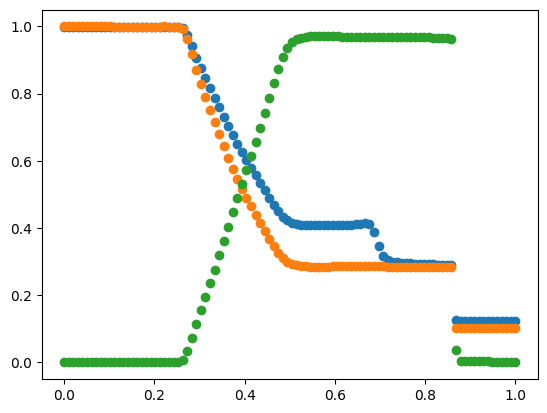

In [134]:
# first 15000step non-conservation
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(x[:],u_pred[:,0])
plt.scatter(x[:],u_pred[:,1])
plt.scatter(x[:],u_pred[:,2])
plt.show()


In [51]:
new_array = np.array(u_pred[:,2])
#new_array = np.array(x)
file = open("p.txt", "w+")
content = str(new_array)
file.write(content)
file.close()


In [74]:
xp= x.flatten()[:,None]
rhop= u_pred[:,0].flatten()[:,None]
up= u_pred[:,1].flatten()[:,None]
pp= u_pred[:,2].flatten()[:,None]
uxy= np.hstack((xp,rhop,up,pp))    
np.savetxt('shockCrho.dat', uxy)

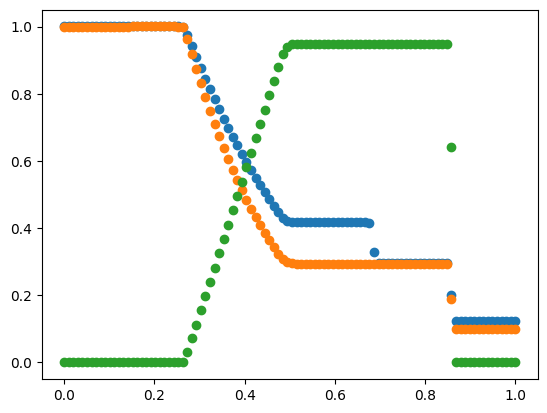

In [65]:
# first 15000step conservation
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(x[:],u_pred[:,0])
plt.scatter(x[:],u_pred[:,1])
plt.scatter(x[:],u_pred[:,2])
plt.show()

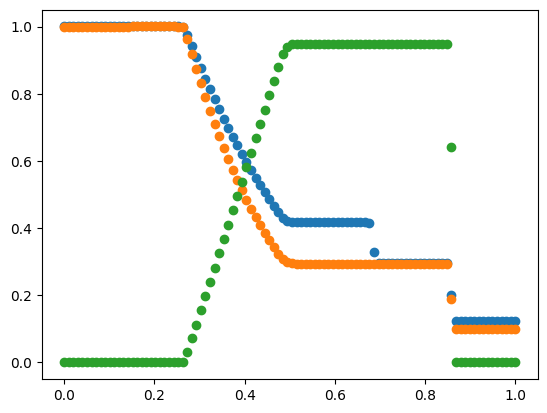

In [66]:
# first 15000step non-conservation
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(x[:],u_pred[:,0])
plt.scatter(x[:],u_pred[:,1])
plt.scatter(x[:],u_pred[:,2])
plt.show()

In [67]:
#np.size(id_f)
x_int_train = np.hstack((t_int, x_int))    # Random (x,t) - vectorized
#np.size(x_int_train)
#np.size(x_int)
#np.size(t_int)

In [68]:
def NewPoint(x,t):
    xl = -0.2
    xr = 1.8
    dgt = 0.0
    dg1 = np.array([])
    M = np.array([])
    N = np.size(x)
    L = np.array([])
    y = np.copy(x)
    for i in range(N):
        if i == 0:
            L = np.append(L,x[0]-xl)
            dgl = dg(x[0],t)
            dgr = dg(xl,t)
            dga = 0.5*(np.abs(dgl)+np.abs(dgr))
            dg1= np.append(dg1,dga)
            dgt += dga*L[i]
        elif i < N-1:
            L = np.append(L,x[i+1]-x[i])
            dgl = dg(x[i],t)
            dgr = dg(x[i+1],t)
            dga = 0.5*(np.abs(dgl)+np.abs(dgr))
            dg1= np.append(dg1,dga)
            dgt += dga*L[i]
        else:
            L = np.append(L,xr-x[N-1])
            dgl = dg(x[N-1],t)
            dgr = dg(xr,t)
            dga = 0.5*(np.abs(dgl)+np.abs(dgr))
            dg1= np.append(dg1,dga)
            dgt += dga*L[N-1]
    for i in range(N):
        M = np.append(M,int((dg1[i]*L[i])/dgt*N+0.5))

    print("M")
  #  print(M)
  #  print("L")
  #  print(L)
    print("dg1")
    print(dg1)
    Mt = 0

    for i in range(N):
        if i ==0 and M[0] > 0:
            for j in range(int(M[0])):
                y[j] = (x[0] - xl)/M[0]*(j+1) + xl
        elif i < N-1 and M[i]> 0 and Mt<N:
            for j in range(int(M[i])):
                y[j+Mt] = (x[i] - x[i-1])/M[i]*(j+1) + x[i-1]
        elif i==N-1 and M[N-1] >0:
            for j in range(int(M[N-1])):
                y[j+Mt] = (xr - x[N-1])/M[N-1]*(j+1) + x[N-1]
        
        Mt = Mt + int(M[i])
    return dg1



In [69]:
x = np.linspace(-0.2, 1.8, 100)                                   # Partitioned spatial axis
t = np.linspace(0, 0.2, 100)                                   # Partitioned spatial axis

In [ ]:
x_r = np.empty(10000, dtype=np.float32)
t_r = np.empty(10000, dtype=np.float32)
i=0
for i in range(np.size(t)):
    x_r[i*100:99+i*100] =NewPoint(x[0:99],t[99])
    t_r[i*100:99+i*100] =t[i]

In [70]:
x_r[600:699]

array([1.60326131e+22, 5.76465166e+22, 3.70957999e+24, 2.36209280e+08,
       5.44426439e-05, 1.62787000e+31, 2.71339503e+20, 8.00166625e+05,
       2.30321930e-07, 1.63223644e+34, 9.21301453e+02, 1.04500940e+12,
       8.04466938e+05, 8.82407375e+05, 4.04630494e+30, 1.30378596e+16,
       3.74023992e+33, 5.69934527e+13, 2.48317636e+26, 1.35164815e+10,
       6.66888847e+10, 5.99938017e+22, 6.24761462e+13, 3.97429464e+27,
       9.15677632e+14, 5.88571517e+22, 6.25707169e+01, 1.52182157e+25,
       1.58646385e+16, 1.00809555e+09, 6.25212734e+04, 4.01251659e+27,
       5.91548866e+13, 7.31270681e+28, 2.80446143e+03, 3.15070821e+12,
       7.32291394e-10, 2.61014860e+14, 3.98053244e+33, 3.54250340e-09,
       8.04056745e-13, 1.10771648e+33, 7.17675236e+25, 2.96474181e+35,
       1.19384877e-05, 7.46800288e-10, 8.82343000e+05, 6.35693008e+04,
       9.44837312e+08, 3.37953381e+21, 1.60242736e-10, 2.82971350e+20,
       1.65894244e+13, 6.38337681e+25, 1.14916658e+24, 1.61912344e+28,
      

In [71]:
plt.scatter(x[0:99],x_r[0:99])

ERROR! Session/line number was not unique in database. History logging moved to new session 4629


In [ ]:
x_r = np.empty(10000, dtype=np.float32)
t_r = np.empty(10000, dtype=np.float32)
for i in range(np.size(t)):
    x_r[i*100:99+i*100] =NewPoint(x_r[i*100:99+i*100],t[i])
    #t_r[i*100:99+i*100] =t[i]

In [ ]:
t[0]

In [ ]:
T = t_r.flatten()[:, None]                                         # Vectorized t_grid
X = x_r.flatten()[:, None]                                         # Vectorized x_grid
x_test = np.hstack((T, X))                                            # Vectorized whole domain

In [ ]:

y =NewPoint(x,t[1])

In [ ]:
dg(1.8,0.2)

In [ ]:
def dg(x,t):
    y_t=np.array([[x]])
    t_t=np.array([[t]])
    x_t = np.hstack((y_t,t_t))

    x_t = torch.tensor(x_t, requires_grad=True, dtype=torch.float32).to(device)
    loss = model.loss_pde(x_t)                                    # Loss function of PDE
    y = model.net(x_t)                                                # Neural network
    rho,p,u = y[:, 0:1], y[:, 1:2], y[:, 2:]                       # NN_{rho}, NN_{u}, NN_{p}
    drho_g = gradients(rho, x_t)[0]
    d = torch.tensor(drho_g, dtype=torch.float32).to(device1)
    return d.numpy()[0][0]


In [ ]:
x = np.linspace(-0.2, 1.8, 1000)                                   # Partitioned spatial axis
t = np.linspace(0.2, 0.2, 1)                                        # Partitioned time axis
t_grid, x_grid = np.meshgrid(t, x)                                    # (t,x) in [0,0.2]x[a,b]
T = t_grid.flatten()[:, None]                                        # Vectorized t_grid
X = x_grid.flatten()[:, None]                                         # Vectorized x_grid
x_test = np.hstack((T, X))                                            # Vectorized whole domain
x_test1 = torch.tensor(x_test, dtype=torch.float32).to(device)
u_pred1 = to_numpy(model(x_test1))

In [ ]:

plt.plot(x[:],u_pred[:,0])

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(x[:],u_pred[:,0])
plt.plot(x[:],u_pred[:,1])
plt.plot(x[:],u_pred[:,2])

In [ ]:
y = model.net(x_int_train)                                                # Neural network
rho,p,u = y[:, 0:1], y[:, 1:2], y[:, 2:]                       # NN_{rho}, NN_{u}, NN_{p}
drho_g = gradients(rho, x_int_train)[0]

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(x,u_pred[:,0])
plt.plot(x[:],u_pred[:,1])
plt.plot(x[:],u_pred[:,2])

In [386]:
#device1 = torch.device('cpu')                                          # Run on CPU
torch.save(model,'1.pt')

In [ ]:
model.load(torch.load(PATH))
model.to(device)

# 文件读取模型

In [ ]:

import matplotlib.pyplot as plt
x = np.linspace(-8.0 / 28.0, 20.0 / 28.0, num_x)  # Partitioned spatial axis
t = np.linspace(2.0, 2.0, 1)  # Partitioned time axis
t_grid, x_grid = np.meshgrid(t, x)  # (t,x) in [0,0.2]x[a,b]
T = t_grid.flatten()[:, None]  # Vectorized t_grid
X = x_grid.flatten()[:, None]  # Vectorized x_grid
x_test = np.hstack((T, X))                                            # Vectorized whole domain
x_test = torch.tensor(x_test, dtype=torch.float32).to('cpu')
u_pred = to_numpy(model(x_test))
plt.plot(x,u_pred[:,0])
plt.plot(x,u_pred[:,1])
plt.plot(x,u_pred[:,2])
plt.plot(x,u_pred[:,3])
plt.plot(x,u_pred[:,4])

In [ ]:

plt.plot(x,u_pred[:,4])

In [ ]:
#u_pred[:,0]
import matplotlib.pyplot as plt
plt.plot(x[300:700],u_pred[300:700,0])
plt.plot(x[300:700],u_pred[300:700,1])
plt.plot(x[300:700],u_pred[300:700,2])

In [ ]:
x = np.linspace(-1.5, 3.125, num_x)                                   # Partitioned spatial axis
t = np.linspace(0.2, 0.2, 1)                                        # Partitioned time axis
t_grid, x_grid = np.meshgrid(t, x)                                    # (t,x) in [0,0.2]x[a,b]
T = t_grid.flatten()[:, None]                                         # Vectorized t_grid
X = x_grid.flatten()[:, None]                                         # Vectorized x_grid
x_test = np.hstack((T, X))                                            # Vectorized whole domain
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
u_pred = to_numpy(model(x_test))

import matplotlib.pyplot as plt
plt.plot(x[300:700],u_pred[300:700,0])
plt.plot(x[300:700],u_pred[300:700,1])
plt.plot(x[300:700],u_pred[300:700,2])

In [ ]:
def fun(x):
    return x.mean()

fun([1,2,3,4;1,2,3,4])

In [ ]:
(1,2,3,4).mean()

In [ ]:
p = np.zeros(100)

In [ ]:
p.mean()